In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import os
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


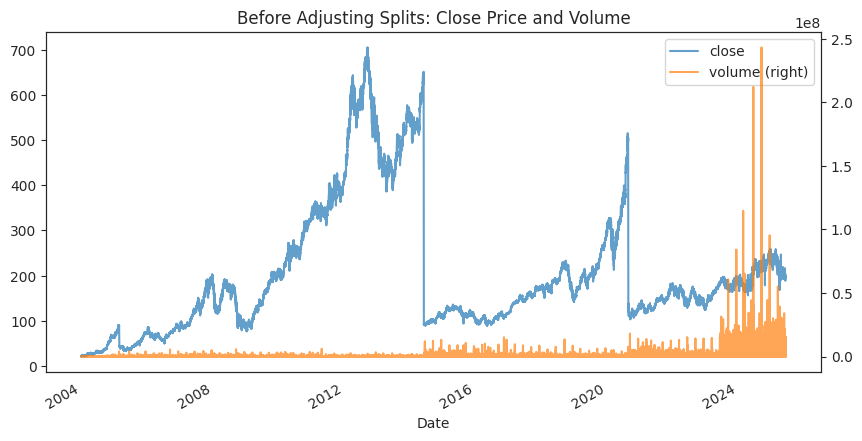

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


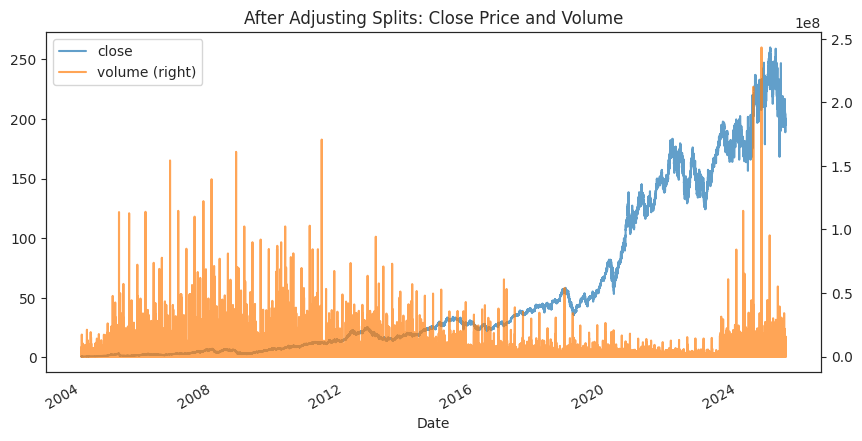

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764668,0.763904
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.913400,196.716600
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.773300,196.576700
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.768300,196.571700
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.338100,196.141900


In [3]:
n_trials = 500
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = params.ticker,
    bidask_spread_pct   = params.bidask_spread_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df: pd.DataFrame,
    min_prof_thr: float,
    max_down_prop: float,
    gain_tightening_factor: float,
    merging_retracement_thr: float,
    merging_time_gap_thr: float,
    tau_time: int,
    tau_dur: int,
    trailing_stop_pct: float,
    buy_threshold: float,
    beta_sat: float,
    smoothing_window: int
) -> float:
    """
    1) Run the full backtest pipeline to simulate trades and P&L per day.
    2) Extract each day’s performance stats (strategy return and trade returns).
    3) Free intermediate DataFrames and trade lists to minimize memory usage.
    4) Compute total and average daily P&L across all trading days.
    5) Compute total trades and average return per trade.
    6) Print a summary of P&L metrics.
    Returns the average daily P&L for Optuna’s objective.
    """
    # A) Execute the end-to-end trading simulation
    simulation = trades.run_trading_pipeline(
        df, 
        col_signal="signal",
        col_action="signal_action",
        min_prof_thr=min_prof_thr,
        max_down_prop=max_down_prop,
        gain_tightening_factor=gain_tightening_factor,
        merging_retracement_thr=merging_retracement_thr,
        merging_time_gap_thr=merging_time_gap_thr,
        tau_time=tau_time,
        tau_dur=tau_dur,
        trailing_stop_pct=trailing_stop_pct,
        buy_threshold=buy_threshold,
        beta_sat=beta_sat,
        smoothing_window=smoothing_window
    )
    
    # If pipeline returned None (no trading days), bail out
    if not simulation:
        return 0.0

    # B) Extract per-day performance stats from simulation output
    per_day_stats = [
        stats 
        for (_, (_, _, stats)) 
        in simulation.items()
    ]

    # C) Release DataFrames and trade lists to free memory
    for (_, (df_sim, trades_list, _)) in simulation.items():
        del df_sim, trades_list
    num_days = len(simulation)
    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # D) Compute total and average daily P&L
    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # E) Compute trade-level metrics: total trades and avg return per trade
    trades_only_days = [s for s in per_day_stats if s["Trades Returns ($)"]]
    total_trades     = sum(len(s["Trades Returns ($)"]) for s in trades_only_days)
    avg_per_trade    = (total_pnl / total_trades) if total_trades else 0.0

    # F) Print a summary of results
    print(f"→ Total P&L over {num_days} days   : ${total_pnl:.2f}")
    print(f"→ Avg daily P&L                    : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                     : {total_trades}")
    print(f"→ Avg return per trade            : ${avg_per_trade:.4f}\n")

    return avg_daily_pnl


In [7]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.1), # increasing min, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 3),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 5, 50),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 1, 7),
        "tau_time"                : trial.suggest_int("tau_time", 1, 60),
        "tau_dur"                 : trial.suggest_int("tau_dur", 60, 240),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.1), # increasing min, to reproduce a realistic scenario of trailing stop loss
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.1, 0.7),
        "beta_sat"                : trial.suggest_int("beta_sat", 1, 20),
        "smoothing_window"        : trial.suggest_int("smoothing_window", 30, 30)
    }
    print('---------------------------------------------------------------------------------------------------------------\n')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl

[I 2025-10-12 17:21:53,971] A new study created in RDB with name: no-name-0bd044ee-0a63-487b-a52d-1e513ea9760f


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.55day/s]
[I 2025-10-12 17:25:14,440] Trial 0 finished with value: 0.12381055555555555 and parameters: {'min_prof_thr': 0.0813657523668679, 'max_down_prop': 0.7223590173818318, 'gain_tightening_factor': 17.102204775678974, 'merging_retracement_thr': 0.7683962617136484, 'merging_time_gap_thr': 1.299655087632318, 'tau_time': 52, 'tau_dur': 130, 'trailing_stop_pct': 0.03435722532935831, 'buy_threshold': 0.5011076857293159, 'beta_sat': 7, 'smoothing_window': 30}. Best is trial 0 with value: 0.12381055555555555.


→ Total P&L over 5400 days   : $668.58
→ Avg daily P&L                    : $0.1238
→ Total trades                     : 2000
→ Avg return per trade            : $0.3343



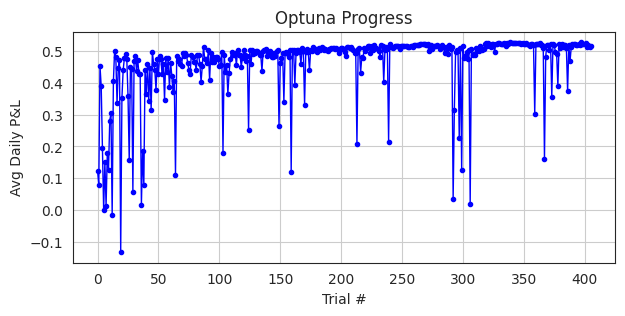

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:59<00:00, 30.06day/s]
[I 2025-10-12 17:28:32,212] Trial 1 finished with value: 0.07777351851851852 and parameters: {'min_prof_thr': 0.0627696655149986, 'max_down_prop': 2.3004292811720717, 'gain_tightening_factor': 30.42504996470181, 'merging_retracement_thr': 0.9908127105458373, 'merging_time_gap_thr': 1.0283096078726317, 'tau_time': 33, 'tau_dur': 225, 'trailing_stop_pct': 0.0355915361640549, 'buy_threshold': 0.40479969132765325, 'beta_sat': 5, 'smoothing_window': 30}. Best is trial 0 with value: 0.12381055555555555.


→ Total P&L over 5400 days   : $419.98
→ Avg daily P&L                    : $0.0778
→ Total trades                     : 1275
→ Avg return per trade            : $0.3294

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.96day/s]
[I 2025-10-12 17:31:55,638] Trial 2 finished with value: 0.45292092592592587 and parameters: {'min_prof_thr': 0.019482717963635644, 'max_down_prop': 1.8579191346474442, 'gain_tightening_factor': 40.66634056002213, 'merging_retracement_thr': 0.8650823670996437, 'merging_time_gap_thr': 6.094924224838325, 'tau_time': 22, 'tau_dur': 142, 'trailing_stop_pct': 0.0480802635990708, 'buy_threshold': 0.3533282919382207, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $2445.77
→ Avg daily P&L                    : $0.4529
→ Total trades                     : 11412
→ Avg return per trade            : $0.2143

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.53day/s]
[I 2025-10-12 17:35:05,981] Trial 3 finished with value: 0.3891625925925926 and parameters: {'min_prof_thr': 0.036098096700186814, 'max_down_prop': 0.19837926096512615, 'gain_tightening_factor': 22.526938572207612, 'merging_retracement_thr': 0.6847931849354612, 'merging_time_gap_thr': 2.310824533684098, 'tau_time': 55, 'tau_dur': 110, 'trailing_stop_pct': 0.05512234632192724, 'buy_threshold': 0.11117870272700002, 'beta_sat': 13, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $2101.48
→ Avg daily P&L                    : $0.3892
→ Total trades                     : 14670
→ Avg return per trade            : $0.1433

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.23day/s]
[I 2025-10-12 17:38:06,565] Trial 4 finished with value: 0.19563999999999998 and parameters: {'min_prof_thr': 0.09355822827944503, 'max_down_prop': 2.2000933997973475, 'gain_tightening_factor': 31.940470482212955, 'merging_retracement_thr': 0.48124077739450766, 'merging_time_gap_thr': 4.75631081748706, 'tau_time': 60, 'tau_dur': 217, 'trailing_stop_pct': 0.06356393053656473, 'buy_threshold': 0.5234039916760368, 'beta_sat': 11, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $1056.46
→ Avg daily P&L                    : $0.1956
→ Total trades                     : 3132
→ Avg return per trade            : $0.3373

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.73day/s]
[I 2025-10-12 17:40:58,155] Trial 5 finished with value: 0.0 and parameters: {'min_prof_thr': 0.0980028855051735, 'max_down_prop': 0.413281745906925, 'gain_tightening_factor': 46.138767235529905, 'merging_retracement_thr': 0.5599012855875741, 'merging_time_gap_thr': 2.95434313410499, 'tau_time': 8, 'tau_dur': 157, 'trailing_stop_pct': 0.0427250394893186, 'buy_threshold': 0.6747915809476985, 'beta_sat': 2, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $0.00
→ Avg daily P&L                    : $0.0000
→ Total trades                     : 0
→ Avg return per trade            : $0.0000

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.02day/s]
[I 2025-10-12 17:43:55,162] Trial 6 finished with value: 0.15037370370370368 and parameters: {'min_prof_thr': 0.08199872581099836, 'max_down_prop': 2.138741666363056, 'gain_tightening_factor': 28.699781442472275, 'merging_retracement_thr': 0.26279987999250615, 'merging_time_gap_thr': 6.529588643659359, 'tau_time': 13, 'tau_dur': 129, 'trailing_stop_pct': 0.04021490243433794, 'buy_threshold': 0.3584334605683419, 'beta_sat': 9, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $812.02
→ Avg daily P&L                    : $0.1504
→ Total trades                     : 2839
→ Avg return per trade            : $0.2860

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.41day/s]
[I 2025-10-12 17:46:50,724] Trial 7 finished with value: 0.012232222222222226 and parameters: {'min_prof_thr': 0.06294158161290711, 'max_down_prop': 2.3236844955350904, 'gain_tightening_factor': 40.145608608880046, 'merging_retracement_thr': 0.12068985792883552, 'merging_time_gap_thr': 3.3475814217749225, 'tau_time': 54, 'tau_dur': 164, 'trailing_stop_pct': 0.05629558257789051, 'buy_threshold': 0.6760917591504287, 'beta_sat': 12, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $66.05
→ Avg daily P&L                    : $0.0122
→ Total trades                     : 132
→ Avg return per trade            : $0.5004

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.59day/s]
[I 2025-10-12 17:49:55,143] Trial 8 finished with value: 0.17841462962962962 and parameters: {'min_prof_thr': 0.019386543272461327, 'max_down_prop': 1.3312281917805866, 'gain_tightening_factor': 36.30616849675354, 'merging_retracement_thr': 0.6980661408953462, 'merging_time_gap_thr': 5.336911636443852, 'tau_time': 45, 'tau_dur': 121, 'trailing_stop_pct': 0.04775984702818911, 'buy_threshold': 0.4261896771622439, 'beta_sat': 10, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $963.44
→ Avg daily P&L                    : $0.1784
→ Total trades                     : 3091
→ Avg return per trade            : $0.3117

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.83day/s]
[I 2025-10-12 17:52:51,627] Trial 9 finished with value: 0.12699462962962965 and parameters: {'min_prof_thr': 0.07539483876542154, 'max_down_prop': 1.1886688261255731, 'gain_tightening_factor': 24.33991900207694, 'merging_retracement_thr': 0.7979331723743448, 'merging_time_gap_thr': 2.4985076713398833, 'tau_time': 40, 'tau_dur': 239, 'trailing_stop_pct': 0.08666544492881367, 'buy_threshold': 0.5331010210262114, 'beta_sat': 8, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $685.77
→ Avg daily P&L                    : $0.1270
→ Total trades                     : 2135
→ Avg return per trade            : $0.3212

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:58<00:00, 30.22day/s]
[I 2025-10-12 17:56:12,613] Trial 10 finished with value: 0.28129351851851847 and parameters: {'min_prof_thr': 0.019002571243360453, 'max_down_prop': 2.9862117477505583, 'gain_tightening_factor': 5.736909786284393, 'merging_retracement_thr': 0.9877091105803025, 'merging_time_gap_thr': 6.686047769167051, 'tau_time': 19, 'tau_dur': 78, 'trailing_stop_pct': 0.07978828062984822, 'buy_threshold': 0.2251499137809115, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $1518.98
→ Avg daily P&L                    : $0.2813
→ Total trades                     : 17221
→ Avg return per trade            : $0.0882

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 31.03day/s]
[I 2025-10-12 17:59:38,205] Trial 11 finished with value: 0.30451888888888884 and parameters: {'min_prof_thr': 0.03514794298229401, 'max_down_prop': 1.7364239102169932, 'gain_tightening_factor': 16.74515712157308, 'merging_retracement_thr': 0.6027181696456674, 'merging_time_gap_thr': 4.476942593283837, 'tau_time': 27, 'tau_dur': 83, 'trailing_stop_pct': 0.07397610180162482, 'buy_threshold': 0.10223375839842452, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $1644.40
→ Avg daily P&L                    : $0.3045
→ Total trades                     : 17956
→ Avg return per trade            : $0.0916

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.37day/s]
[I 2025-10-12 18:02:57,069] Trial 12 finished with value: -0.014695925925925927 and parameters: {'min_prof_thr': 0.03900991892900946, 'max_down_prop': 0.9458005801135011, 'gain_tightening_factor': 49.6519795047939, 'merging_retracement_thr': 0.8506209031050026, 'merging_time_gap_thr': 5.509054333568689, 'tau_time': 2, 'tau_dur': 177, 'trailing_stop_pct': 0.09800910803053826, 'buy_threshold': 0.2378298431073239, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $-79.36
→ Avg daily P&L                    : $-0.0147
→ Total trades                     : 26466
→ Avg return per trade            : $-0.0030

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.06day/s]
[I 2025-10-12 18:06:16,756] Trial 13 finished with value: 0.4054203703703704 and parameters: {'min_prof_thr': 0.03820175769289984, 'max_down_prop': 0.13013175857809367, 'gain_tightening_factor': 20.294647884542293, 'merging_retracement_thr': 0.39726071016873377, 'merging_time_gap_thr': 2.1868929982204484, 'tau_time': 26, 'tau_dur': 91, 'trailing_stop_pct': 0.054939208857691255, 'buy_threshold': 0.10357235383643316, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 2 with value: 0.45292092592592587.


→ Total P&L over 5400 days   : $2189.27
→ Avg daily P&L                    : $0.4054
→ Total trades                     : 17583
→ Avg return per trade            : $0.1245

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.21day/s]
[I 2025-10-12 18:09:17,232] Trial 14 finished with value: 0.5022418518518519 and parameters: {'min_prof_thr': 0.04795904258029132, 'max_down_prop': 1.6101225274023085, 'gain_tightening_factor': 7.882594402255336, 'merging_retracement_thr': 0.40676350514498055, 'merging_time_gap_thr': 3.738961369443233, 'tau_time': 24, 'tau_dur': 96, 'trailing_stop_pct': 0.05183479124767279, 'buy_threshold': 0.2689757650207122, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2712.11
→ Avg daily P&L                    : $0.5022
→ Total trades                     : 16286
→ Avg return per trade            : $0.1665

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:55<00:00, 30.74day/s]
[I 2025-10-12 18:12:39,235] Trial 15 finished with value: 0.4809259259259259 and parameters: {'min_prof_thr': 0.04859786745983985, 'max_down_prop': 1.7301224588320445, 'gain_tightening_factor': 10.261097039034741, 'merging_retracement_thr': 0.39200999067515413, 'merging_time_gap_thr': 3.735407821958554, 'tau_time': 20, 'tau_dur': 60, 'trailing_stop_pct': 0.06864552950704447, 'buy_threshold': 0.29829236531695513, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2597.00
→ Avg daily P&L                    : $0.4809
→ Total trades                     : 16989
→ Avg return per trade            : $0.1529

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.04day/s]
[I 2025-10-12 18:15:37,355] Trial 16 finished with value: 0.33672370370370375 and parameters: {'min_prof_thr': 0.049837348795978564, 'max_down_prop': 2.758982366250349, 'gain_tightening_factor': 5.276307634961187, 'merging_retracement_thr': 0.3615719527878939, 'merging_time_gap_thr': 3.711743929493542, 'tau_time': 35, 'tau_dur': 60, 'trailing_stop_pct': 0.06516430525423599, 'buy_threshold': 0.25656764074820587, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $1818.31
→ Avg daily P&L                    : $0.3367
→ Total trades                     : 15766
→ Avg return per trade            : $0.1153

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.22day/s]
[I 2025-10-12 18:18:31,024] Trial 17 finished with value: 0.4484712962962963 and parameters: {'min_prof_thr': 0.05154589169818721, 'max_down_prop': 1.5327561342820482, 'gain_tightening_factor': 11.033608604137749, 'merging_retracement_thr': 0.22420265721427765, 'merging_time_gap_thr': 4.260554023625328, 'tau_time': 14, 'tau_dur': 63, 'trailing_stop_pct': 0.06902729287059517, 'buy_threshold': 0.30432390320090663, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2421.74
→ Avg daily P&L                    : $0.4485
→ Total trades                     : 14907
→ Avg return per trade            : $0.1625

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.40day/s]
[I 2025-10-12 18:21:24,840] Trial 18 finished with value: 0.47118259259259265 and parameters: {'min_prof_thr': 0.0618799180362173, 'max_down_prop': 1.7287015614601244, 'gain_tightening_factor': 11.57267329163469, 'merging_retracement_thr': 0.4434849352350518, 'merging_time_gap_thr': 3.4551827811997993, 'tau_time': 19, 'tau_dur': 100, 'trailing_stop_pct': 0.07990402276841213, 'buy_threshold': 0.21837746968435506, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2544.39
→ Avg daily P&L                    : $0.4712
→ Total trades                     : 15812
→ Avg return per trade            : $0.1609

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.13day/s]
[I 2025-10-12 18:24:37,241] Trial 19 finished with value: -0.13363518518518522 and parameters: {'min_prof_thr': 0.04738365755299845, 'max_down_prop': 1.1101334634184163, 'gain_tightening_factor': 9.743956278240276, 'merging_retracement_thr': 0.30676983752240033, 'merging_time_gap_thr': 5.039600706997286, 'tau_time': 2, 'tau_dur': 77, 'trailing_stop_pct': 0.06064054589574698, 'buy_threshold': 0.18106676385998582, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $-721.63
→ Avg daily P&L                    : $-0.1336
→ Total trades                     : 29415
→ Avg return per trade            : $-0.0245

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.48day/s]
[I 2025-10-12 18:27:46,308] Trial 20 finished with value: 0.3517609259259259 and parameters: {'min_prof_thr': 0.028185178074227723, 'max_down_prop': 0.7607255373982039, 'gain_tightening_factor': 14.717961832955904, 'merging_retracement_thr': 0.15119428022545234, 'merging_time_gap_thr': 4.046980574384089, 'tau_time': 11, 'tau_dur': 106, 'trailing_stop_pct': 0.0950385567250181, 'buy_threshold': 0.3040194384189102, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $1899.51
→ Avg daily P&L                    : $0.3518
→ Total trades                     : 9787
→ Avg return per trade            : $0.1941

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.11day/s]
[I 2025-10-12 18:30:42,323] Trial 21 finished with value: 0.4396937037037037 and parameters: {'min_prof_thr': 0.0629590302383753, 'max_down_prop': 1.8527045781421696, 'gain_tightening_factor': 11.347724594020578, 'merging_retracement_thr': 0.4388192923269298, 'merging_time_gap_thr': 3.2238267543155246, 'tau_time': 19, 'tau_dur': 98, 'trailing_stop_pct': 0.08060994167787607, 'buy_threshold': 0.1668482502284494, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2374.35
→ Avg daily P&L                    : $0.4397
→ Total trades                     : 19081
→ Avg return per trade            : $0.1244

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.75day/s]
[I 2025-10-12 18:33:29,215] Trial 22 finished with value: 0.4776546296296296 and parameters: {'min_prof_thr': 0.05701530472823605, 'max_down_prop': 1.500857992488141, 'gain_tightening_factor': 9.160922706835333, 'merging_retracement_thr': 0.492635719179042, 'merging_time_gap_thr': 3.6825160631397793, 'tau_time': 27, 'tau_dur': 74, 'trailing_stop_pct': 0.07171116392373615, 'buy_threshold': 0.2893711706395285, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2579.34
→ Avg daily P&L                    : $0.4777
→ Total trades                     : 12186
→ Avg return per trade            : $0.2117

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.76day/s]
[I 2025-10-12 18:36:21,193] Trial 23 finished with value: 0.4923331481481481 and parameters: {'min_prof_thr': 0.04527639200112558, 'max_down_prop': 1.4602366922294914, 'gain_tightening_factor': 6.4203764612909, 'merging_retracement_thr': 0.5107273180869684, 'merging_time_gap_thr': 2.769189050694525, 'tau_time': 28, 'tau_dur': 70, 'trailing_stop_pct': 0.07111800717192684, 'buy_threshold': 0.3216738664939316, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2658.60
→ Avg daily P&L                    : $0.4923
→ Total trades                     : 14148
→ Avg return per trade            : $0.1879

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.43day/s]
[I 2025-10-12 18:39:13,943] Trial 24 finished with value: 0.4762416666666667 and parameters: {'min_prof_thr': 0.044515274965319464, 'max_down_prop': 1.3829145124597475, 'gain_tightening_factor': 5.635050471953292, 'merging_retracement_thr': 0.33980400637577307, 'merging_time_gap_thr': 1.769511861893661, 'tau_time': 39, 'tau_dur': 63, 'trailing_stop_pct': 0.08911860721667209, 'buy_threshold': 0.36652033205599616, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2571.70
→ Avg daily P&L                    : $0.4762
→ Total trades                     : 11836
→ Avg return per trade            : $0.2173

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.45day/s]
[I 2025-10-12 18:42:32,687] Trial 25 finished with value: 0.35893018518518516 and parameters: {'min_prof_thr': 0.027527521448472137, 'max_down_prop': 2.015161361849643, 'gain_tightening_factor': 14.796520024283346, 'merging_retracement_thr': 0.5480914810302181, 'merging_time_gap_thr': 2.646477682387251, 'tau_time': 30, 'tau_dur': 89, 'trailing_stop_pct': 0.059785452925950486, 'buy_threshold': 0.46854739645587845, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $1938.22
→ Avg daily P&L                    : $0.3589
→ Total trades                     : 7307
→ Avg return per trade            : $0.2653

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.93day/s]
[I 2025-10-12 18:45:43,764] Trial 26 finished with value: 0.1576312962962963 and parameters: {'min_prof_thr': 0.07394458667371998, 'max_down_prop': 2.6187100040795217, 'gain_tightening_factor': 8.252472259391215, 'merging_retracement_thr': 0.23827841436987685, 'merging_time_gap_thr': 1.8377086485235932, 'tau_time': 24, 'tau_dur': 115, 'trailing_stop_pct': 0.06737306902179917, 'buy_threshold': 0.5874981231758197, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $851.21
→ Avg daily P&L                    : $0.1576
→ Total trades                     : 3690
→ Avg return per trade            : $0.2307

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.54day/s]
[I 2025-10-12 18:48:43,422] Trial 27 finished with value: 0.4495746296296297 and parameters: {'min_prof_thr': 0.0555861255852387, 'max_down_prop': 1.6624727033034736, 'gain_tightening_factor': 19.205992971932467, 'merging_retracement_thr': 0.5890178652565774, 'merging_time_gap_thr': 3.027767313129924, 'tau_time': 31, 'tau_dur': 198, 'trailing_stop_pct': 0.07329613112597758, 'buy_threshold': 0.33203396156295373, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2427.70
→ Avg daily P&L                    : $0.4496
→ Total trades                     : 10135
→ Avg return per trade            : $0.2395

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.75day/s]
[I 2025-10-12 18:51:40,187] Trial 28 finished with value: 0.44261703703703703 and parameters: {'min_prof_thr': 0.043851502070483134, 'max_down_prop': 1.0774321300417706, 'gain_tightening_factor': 13.772277131455562, 'merging_retracement_thr': 0.40076541715027986, 'merging_time_gap_thr': 3.9426849729519753, 'tau_time': 38, 'tau_dur': 68, 'trailing_stop_pct': 0.05027581691197058, 'buy_threshold': 0.17450205821203735, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2390.13
→ Avg daily P&L                    : $0.4426
→ Total trades                     : 15555
→ Avg return per trade            : $0.1537

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.09day/s]
[I 2025-10-12 18:54:35,223] Trial 29 finished with value: 0.057104999999999996 and parameters: {'min_prof_thr': 0.03151213283112815, 'max_down_prop': 0.8155877689079418, 'gain_tightening_factor': 24.875650342315428, 'merging_retracement_thr': 0.6454783012006673, 'merging_time_gap_thr': 1.6099196309856625, 'tau_time': 47, 'tau_dur': 145, 'trailing_stop_pct': 0.07607957453024311, 'buy_threshold': 0.46780622040708847, 'beta_sat': 6, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $308.37
→ Avg daily P&L                    : $0.0571
→ Total trades                     : 751
→ Avg return per trade            : $0.4106

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.34day/s]
[I 2025-10-12 18:57:35,671] Trial 30 finished with value: 0.46956407407407413 and parameters: {'min_prof_thr': 0.011262396613808096, 'max_down_prop': 0.5407237231299606, 'gain_tightening_factor': 7.838278146302829, 'merging_retracement_thr': 0.5070449666836856, 'merging_time_gap_thr': 2.8043439026170147, 'tau_time': 16, 'tau_dur': 92, 'trailing_stop_pct': 0.0871768608973024, 'buy_threshold': 0.26897218843107806, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2535.65
→ Avg daily P&L                    : $0.4696
→ Total trades                     : 14441
→ Avg return per trade            : $0.1756

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.98day/s]
[I 2025-10-12 19:00:30,439] Trial 31 finished with value: 0.48595648148148146 and parameters: {'min_prof_thr': 0.054588249165039904, 'max_down_prop': 1.480108218762338, 'gain_tightening_factor': 8.791583639955938, 'merging_retracement_thr': 0.48943613654472395, 'merging_time_gap_thr': 3.702601298615367, 'tau_time': 29, 'tau_dur': 78, 'trailing_stop_pct': 0.06998055176771688, 'buy_threshold': 0.30394409054953825, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2624.16
→ Avg daily P&L                    : $0.4860
→ Total trades                     : 12702
→ Avg return per trade            : $0.2066

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.59day/s]
[I 2025-10-12 19:03:22,501] Trial 32 finished with value: 0.43869685185185187 and parameters: {'min_prof_thr': 0.05476094708970322, 'max_down_prop': 1.2903797172403746, 'gain_tightening_factor': 12.954442891947, 'merging_retracement_thr': 0.429243614410841, 'merging_time_gap_thr': 4.2648099951198, 'tau_time': 22, 'tau_dur': 79, 'trailing_stop_pct': 0.06206470599901982, 'buy_threshold': 0.3277106824003883, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2368.96
→ Avg daily P&L                    : $0.4387
→ Total trades                     : 10708
→ Avg return per trade            : $0.2212

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.58day/s]
[I 2025-10-12 19:06:14,274] Trial 33 finished with value: 0.4723974074074075 and parameters: {'min_prof_thr': 0.06966354220001, 'max_down_prop': 1.9650369539519392, 'gain_tightening_factor': 17.209773663263704, 'merging_retracement_thr': 0.5303934353304923, 'merging_time_gap_thr': 3.5386895656179402, 'tau_time': 33, 'tau_dur': 73, 'trailing_stop_pct': 0.06937020726967061, 'buy_threshold': 0.36993075973391243, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2550.95
→ Avg daily P&L                    : $0.4724
→ Total trades                     : 11402
→ Avg return per trade            : $0.2237

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.56day/s]
[I 2025-10-12 19:09:06,811] Trial 34 finished with value: 0.4287327777777778 and parameters: {'min_prof_thr': 0.04159929191375759, 'max_down_prop': 1.4969345980086406, 'gain_tightening_factor': 7.393153945779453, 'merging_retracement_thr': 0.3091811579760765, 'merging_time_gap_thr': 3.8492190354663998, 'tau_time': 29, 'tau_dur': 130, 'trailing_stop_pct': 0.07637917520144959, 'buy_threshold': 0.41811317804818937, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2315.16
→ Avg daily P&L                    : $0.4287
→ Total trades                     : 9865
→ Avg return per trade            : $0.2347

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.61day/s]
[I 2025-10-12 19:12:18,102] Trial 35 finished with value: 0.42950962962962963 and parameters: {'min_prof_thr': 0.05231056316563309, 'max_down_prop': 2.453357074253333, 'gain_tightening_factor': 16.06066322540007, 'merging_retracement_thr': 0.4722747407972205, 'merging_time_gap_thr': 4.725484086679483, 'tau_time': 36, 'tau_dur': 86, 'trailing_stop_pct': 0.03641850221473457, 'buy_threshold': 0.38711338510875654, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2319.35
→ Avg daily P&L                    : $0.4295
→ Total trades                     : 9669
→ Avg return per trade            : $0.2399

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:58<00:00, 30.34day/s]
[I 2025-10-12 19:15:36,532] Trial 36 finished with value: 0.01650259259259259 and parameters: {'min_prof_thr': 0.05909241625942464, 'max_down_prop': 1.6497395901669076, 'gain_tightening_factor': 19.907890118366176, 'merging_retracement_thr': 0.6242975305066653, 'merging_time_gap_thr': 1.1880186725318587, 'tau_time': 23, 'tau_dur': 103, 'trailing_stop_pct': 0.050962980176117334, 'buy_threshold': 0.2777910660961514, 'beta_sat': 1, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $89.11
→ Avg daily P&L                    : $0.0165
→ Total trades                     : 152
→ Avg return per trade            : $0.5863

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:53<00:00, 31.09day/s]
[I 2025-10-12 19:18:52,035] Trial 37 finished with value: 0.18676925925925927 and parameters: {'min_prof_thr': 0.06708714216334902, 'max_down_prop': 1.8967708954994251, 'gain_tightening_factor': 9.824460313148148, 'merging_retracement_thr': 0.699286441511802, 'merging_time_gap_thr': 2.2265683303456125, 'tau_time': 6, 'tau_dur': 120, 'trailing_stop_pct': 0.06529994195295288, 'buy_threshold': 0.20359568330743572, 'beta_sat': 12, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $1008.55
→ Avg daily P&L                    : $0.1868
→ Total trades                     : 20975
→ Avg return per trade            : $0.0481

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.97day/s]
[I 2025-10-12 19:22:05,320] Trial 38 finished with value: 0.07969074074074074 and parameters: {'min_prof_thr': 0.04657306621114992, 'max_down_prop': 2.1352927978271987, 'gain_tightening_factor': 12.52004250226291, 'merging_retracement_thr': 0.37062028864262003, 'merging_time_gap_thr': 2.943406655438457, 'tau_time': 42, 'tau_dur': 69, 'trailing_stop_pct': 0.05662770150925062, 'buy_threshold': 0.33088636694270285, 'beta_sat': 4, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $430.33
→ Avg daily P&L                    : $0.0797
→ Total trades                     : 1180
→ Avg return per trade            : $0.3647

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.88day/s]
[I 2025-10-12 19:25:30,861] Trial 39 finished with value: 0.44217796296296297 and parameters: {'min_prof_thr': 0.03317224842446945, 'max_down_prop': 0.9528207989322706, 'gain_tightening_factor': 31.44805938814301, 'merging_retracement_thr': 0.2890149902556415, 'merging_time_gap_thr': 4.651019636593114, 'tau_time': 16, 'tau_dur': 110, 'trailing_stop_pct': 0.044443482888885825, 'buy_threshold': 0.25308359139309006, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2387.76
→ Avg daily P&L                    : $0.4422
→ Total trades                     : 11762
→ Avg return per trade            : $0.2030

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.74day/s]
[I 2025-10-12 19:28:47,077] Trial 40 finished with value: 0.3659675925925926 and parameters: {'min_prof_thr': 0.08249255575285391, 'max_down_prop': 1.3169911041021525, 'gain_tightening_factor': 36.077095780156824, 'merging_retracement_thr': 0.5551942670329375, 'merging_time_gap_thr': 3.1923878560304018, 'tau_time': 33, 'tau_dur': 60, 'trailing_stop_pct': 0.0574437421115337, 'buy_threshold': 0.1502809311874239, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $1976.22
→ Avg daily P&L                    : $0.3660
→ Total trades                     : 16502
→ Avg return per trade            : $0.1198

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.13day/s]
[I 2025-10-12 19:31:52,557] Trial 41 finished with value: 0.460932037037037 and parameters: {'min_prof_thr': 0.056963299926357056, 'max_down_prop': 1.4715643662156337, 'gain_tightening_factor': 8.819386867845775, 'merging_retracement_thr': 0.48769167412130404, 'merging_time_gap_thr': 3.636054130181345, 'tau_time': 25, 'tau_dur': 73, 'trailing_stop_pct': 0.07141561792948134, 'buy_threshold': 0.2930771867670114, 'beta_sat': 13, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2489.03
→ Avg daily P&L                    : $0.4609
→ Total trades                     : 11427
→ Avg return per trade            : $0.2178

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.27day/s]
[I 2025-10-12 19:34:57,981] Trial 42 finished with value: 0.3444281481481482 and parameters: {'min_prof_thr': 0.0489326181788942, 'max_down_prop': 1.6287512535291855, 'gain_tightening_factor': 6.452708803350567, 'merging_retracement_thr': 0.4691913711636335, 'merging_time_gap_thr': 4.146695226388901, 'tau_time': 21, 'tau_dur': 95, 'trailing_stop_pct': 0.0837353518698073, 'buy_threshold': 0.3237315704768088, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $1859.91
→ Avg daily P&L                    : $0.3444
→ Total trades                     : 8346
→ Avg return per trade            : $0.2229

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.70day/s]
[I 2025-10-12 19:38:05,229] Trial 43 finished with value: 0.4462762962962963 and parameters: {'min_prof_thr': 0.04180938618926537, 'max_down_prop': 1.792745647876934, 'gain_tightening_factor': 9.16712823955847, 'merging_retracement_thr': 0.5108467734864196, 'merging_time_gap_thr': 3.2776054618029824, 'tau_time': 28, 'tau_dur': 82, 'trailing_stop_pct': 0.07160066445865983, 'buy_threshold': 0.4010979714968776, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2409.89
→ Avg daily P&L                    : $0.4463
→ Total trades                     : 10583
→ Avg return per trade            : $0.2277

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.62day/s]
[I 2025-10-12 19:41:05,585] Trial 44 finished with value: 0.31513185185185183 and parameters: {'min_prof_thr': 0.05933261108800924, 'max_down_prop': 1.2105831257207864, 'gain_tightening_factor': 10.640195937534632, 'merging_retracement_thr': 0.4030163429213569, 'merging_time_gap_thr': 2.476708647537434, 'tau_time': 26, 'tau_dur': 71, 'trailing_stop_pct': 0.07665413992518802, 'buy_threshold': 0.3504610006851931, 'beta_sat': 11, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $1701.71
→ Avg daily P&L                    : $0.3151
→ Total trades                     : 5949
→ Avg return per trade            : $0.2861

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 31.01day/s]
[I 2025-10-12 19:44:22,697] Trial 45 finished with value: 0.4990968518518519 and parameters: {'min_prof_thr': 0.06573314496503534, 'max_down_prop': 1.457666884275297, 'gain_tightening_factor': 7.2806063776827195, 'merging_retracement_thr': 0.6511357257133304, 'merging_time_gap_thr': 5.907502567743379, 'tau_time': 33, 'tau_dur': 131, 'trailing_stop_pct': 0.06639764264455916, 'buy_threshold': 0.28672660813061707, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2695.12
→ Avg daily P&L                    : $0.4991
→ Total trades                     : 13398
→ Avg return per trade            : $0.2012

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.73day/s]
[I 2025-10-12 19:47:35,659] Trial 46 finished with value: 0.4612409259259259 and parameters: {'min_prof_thr': 0.0672646794752893, 'max_down_prop': 2.0590812797448454, 'gain_tightening_factor': 5.518826493528451, 'merging_retracement_thr': 0.7352856223010945, 'merging_time_gap_thr': 6.089894279123615, 'tau_time': 31, 'tau_dur': 133, 'trailing_stop_pct': 0.06616108538493118, 'buy_threshold': 0.24757041212856465, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2490.70
→ Avg daily P&L                    : $0.4612
→ Total trades                     : 12878
→ Avg return per trade            : $0.1934

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.40day/s]
[I 2025-10-12 19:50:25,731] Trial 47 finished with value: 0.4424938888888888 and parameters: {'min_prof_thr': 0.07653308568087058, 'max_down_prop': 1.3977825443777288, 'gain_tightening_factor': 7.083408077220761, 'merging_retracement_thr': 0.6450589841629706, 'merging_time_gap_thr': 5.694477523691293, 'tau_time': 36, 'tau_dur': 176, 'trailing_stop_pct': 0.06370846743730152, 'buy_threshold': 0.20716375542559384, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2389.47
→ Avg daily P&L                    : $0.4425
→ Total trades                     : 15677
→ Avg return per trade            : $0.1524

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.49day/s]
[I 2025-10-12 19:53:23,035] Trial 48 finished with value: 0.377772962962963 and parameters: {'min_prof_thr': 0.05154320817683739, 'max_down_prop': 2.306243502135694, 'gain_tightening_factor': 13.05553968414047, 'merging_retracement_thr': 0.5869156517442262, 'merging_time_gap_thr': 4.969534698260359, 'tau_time': 33, 'tau_dur': 156, 'trailing_stop_pct': 0.05172130951153935, 'buy_threshold': 0.1380982208470911, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2039.97
→ Avg daily P&L                    : $0.3778
→ Total trades                     : 17139
→ Avg return per trade            : $0.1190

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.67day/s]
[I 2025-10-12 19:56:19,832] Trial 49 finished with value: 0.4742942592592592 and parameters: {'min_prof_thr': 0.039696987092703084, 'max_down_prop': 1.5822777937046224, 'gain_tightening_factor': 18.047233576148642, 'merging_retracement_thr': 0.7606238169857891, 'merging_time_gap_thr': 6.88958978712371, 'tau_time': 42, 'tau_dur': 137, 'trailing_stop_pct': 0.06852851406442116, 'buy_threshold': 0.23366306595941155, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2561.19
→ Avg daily P&L                    : $0.4743
→ Total trades                     : 14169
→ Avg return per trade            : $0.1808

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.50day/s]
[I 2025-10-12 19:59:11,632] Trial 50 finished with value: 0.42740407407407405 and parameters: {'min_prof_thr': 0.06390481956502288, 'max_down_prop': 1.209482275541057, 'gain_tightening_factor': 28.239619215759085, 'merging_retracement_thr': 0.926217343583864, 'merging_time_gap_thr': 4.458715675470931, 'tau_time': 49, 'tau_dur': 119, 'trailing_stop_pct': 0.06154634958578665, 'buy_threshold': 0.44067599517224254, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2307.98
→ Avg daily P&L                    : $0.4274
→ Total trades                     : 9255
→ Avg return per trade            : $0.2494

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.64day/s]
[I 2025-10-12 20:02:03,884] Trial 51 finished with value: 0.4864198148148149 and parameters: {'min_prof_thr': 0.054808371730346965, 'max_down_prop': 1.4850730169231674, 'gain_tightening_factor': 8.27077329757375, 'merging_retracement_thr': 0.466005153086828, 'merging_time_gap_thr': 3.580279204483353, 'tau_time': 28, 'tau_dur': 84, 'trailing_stop_pct': 0.07193684340098801, 'buy_threshold': 0.28452033098099955, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2626.67
→ Avg daily P&L                    : $0.4864
→ Total trades                     : 12831
→ Avg return per trade            : $0.2047

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.32day/s]
[I 2025-10-12 20:04:56,655] Trial 52 finished with value: 0.47495777777777776 and parameters: {'min_prof_thr': 0.05274149148978227, 'max_down_prop': 1.7345557345573681, 'gain_tightening_factor': 5.229184537695895, 'merging_retracement_thr': 0.3673157274676877, 'merging_time_gap_thr': 3.8581017760047134, 'tau_time': 60, 'tau_dur': 85, 'trailing_stop_pct': 0.0752274186041343, 'buy_threshold': 0.3086770401680098, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2564.77
→ Avg daily P&L                    : $0.4750
→ Total trades                     : 12024
→ Avg return per trade            : $0.2133

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.66day/s]
[I 2025-10-12 20:07:50,841] Trial 53 finished with value: 0.4274833333333334 and parameters: {'min_prof_thr': 0.04690646357403712, 'max_down_prop': 1.0619840479145737, 'gain_tightening_factor': 11.066567770055357, 'merging_retracement_thr': 0.4420094468834994, 'merging_time_gap_thr': 3.492066854738601, 'tau_time': 19, 'tau_dur': 95, 'trailing_stop_pct': 0.07915419599601868, 'buy_threshold': 0.2738072889725092, 'beta_sat': 13, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2308.41
→ Avg daily P&L                    : $0.4275
→ Total trades                     : 10543
→ Avg return per trade            : $0.2190

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.54day/s]
[I 2025-10-12 20:10:42,452] Trial 54 finished with value: 0.4614822222222222 and parameters: {'min_prof_thr': 0.06008929969146811, 'max_down_prop': 1.4269374166299063, 'gain_tightening_factor': 7.239450604416617, 'merging_retracement_thr': 0.33409846914646285, 'merging_time_gap_thr': 2.8907628095959312, 'tau_time': 22, 'tau_dur': 66, 'trailing_stop_pct': 0.06946419930854655, 'buy_threshold': 0.3455531254394588, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2492.00
→ Avg daily P&L                    : $0.4615
→ Total trades                     : 12484
→ Avg return per trade            : $0.1996

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.53day/s]
[I 2025-10-12 20:13:30,822] Trial 55 finished with value: 0.34576055555555557 and parameters: {'min_prof_thr': 0.09009095864614597, 'max_down_prop': 1.9152974021215305, 'gain_tightening_factor': 14.814936193539456, 'merging_retracement_thr': 0.5632006812640495, 'merging_time_gap_thr': 6.2849434655948215, 'tau_time': 28, 'tau_dur': 80, 'trailing_stop_pct': 0.030876180198417816, 'buy_threshold': 0.3096862654856875, 'beta_sat': 9, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $1867.11
→ Avg daily P&L                    : $0.3458
→ Total trades                     : 7560
→ Avg return per trade            : $0.2470

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.43day/s]
[I 2025-10-12 20:16:26,192] Trial 56 finished with value: 0.4791153703703704 and parameters: {'min_prof_thr': 0.036610021243312585, 'max_down_prop': 1.5436680401667178, 'gain_tightening_factor': 12.052693602885775, 'merging_retracement_thr': 0.6754310408177026, 'merging_time_gap_thr': 4.424807601877886, 'tau_time': 16, 'tau_dur': 111, 'trailing_stop_pct': 0.053721574823079585, 'buy_threshold': 0.26559581149518324, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2587.22
→ Avg daily P&L                    : $0.4791
→ Total trades                     : 15452
→ Avg return per trade            : $0.1674

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.79day/s]
[I 2025-10-12 20:19:17,157] Trial 57 finished with value: 0.43619685185185186 and parameters: {'min_prof_thr': 0.044909082601102546, 'max_down_prop': 1.7934203970302882, 'gain_tightening_factor': 10.018707979443125, 'merging_retracement_thr': 0.5320165037677148, 'merging_time_gap_thr': 3.1272139514172315, 'tau_time': 25, 'tau_dur': 89, 'trailing_stop_pct': 0.05906456908251868, 'buy_threshold': 0.3799756630762161, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2355.46
→ Avg daily P&L                    : $0.4362
→ Total trades                     : 10617
→ Avg return per trade            : $0.2219

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.05day/s]
[I 2025-10-12 20:22:14,147] Trial 58 finished with value: 0.4775081481481481 and parameters: {'min_prof_thr': 0.06601600988361893, 'max_down_prop': 1.288541896924774, 'gain_tightening_factor': 8.160776916700945, 'merging_retracement_thr': 0.41735468202218573, 'merging_time_gap_thr': 3.327262137018357, 'tau_time': 31, 'tau_dur': 103, 'trailing_stop_pct': 0.06322533784768472, 'buy_threshold': 0.22655659287837132, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2578.54
→ Avg daily P&L                    : $0.4775
→ Total trades                     : 15634
→ Avg return per trade            : $0.1649

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.62day/s]
[I 2025-10-12 20:25:06,971] Trial 59 finished with value: 0.38652962962962967 and parameters: {'min_prof_thr': 0.049385484005085176, 'max_down_prop': 1.6643504976868875, 'gain_tightening_factor': 21.48797971972467, 'merging_retracement_thr': 0.1980546815312202, 'merging_time_gap_thr': 5.011987186744117, 'tau_time': 34, 'tau_dur': 78, 'trailing_stop_pct': 0.07249928780266582, 'buy_threshold': 0.29258098552991985, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2087.26
→ Avg daily P&L                    : $0.3865
→ Total trades                     : 9039
→ Avg return per trade            : $0.2309

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.15day/s]
[I 2025-10-12 20:28:00,584] Trial 60 finished with value: 0.46354833333333334 and parameters: {'min_prof_thr': 0.06966959693947725, 'max_down_prop': 1.8207315023711619, 'gain_tightening_factor': 43.867326334244396, 'merging_retracement_thr': 0.37879225818844897, 'merging_time_gap_thr': 2.695830011571655, 'tau_time': 20, 'tau_dur': 67, 'trailing_stop_pct': 0.06653493307500517, 'buy_threshold': 0.19941133292825547, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2503.16
→ Avg daily P&L                    : $0.4635
→ Total trades                     : 17213
→ Avg return per trade            : $0.1454

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.60day/s]
[I 2025-10-12 20:30:55,029] Trial 61 finished with value: 0.42155296296296296 and parameters: {'min_prof_thr': 0.03763917236432328, 'max_down_prop': 1.5320945684119516, 'gain_tightening_factor': 11.317824058335452, 'merging_retracement_thr': 0.669928341191562, 'merging_time_gap_thr': 5.752006246339093, 'tau_time': 11, 'tau_dur': 108, 'trailing_stop_pct': 0.043354605480275275, 'buy_threshold': 0.2686524481356947, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2276.39
→ Avg daily P&L                    : $0.4216
→ Total trades                     : 16531
→ Avg return per trade            : $0.1377

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:22<00:00, 37.80day/s]
[I 2025-10-12 20:33:35,444] Trial 62 finished with value: 0.37052037037037033 and parameters: {'min_prof_thr': 0.035224262756754374, 'max_down_prop': 1.5704020300900026, 'gain_tightening_factor': 5.026120156374243, 'merging_retracement_thr': 0.4588070707858522, 'merging_time_gap_thr': 5.319727843713794, 'tau_time': 16, 'tau_dur': 125, 'trailing_stop_pct': 0.05387573065035002, 'buy_threshold': 0.24406658841646633, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2000.81
→ Avg daily P&L                    : $0.3705
→ Total trades                     : 11723
→ Avg return per trade            : $0.1707

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.20day/s]
[I 2025-10-12 20:36:30,461] Trial 63 finished with value: 0.40526759259259254 and parameters: {'min_prof_thr': 0.028223286480108273, 'max_down_prop': 1.3806125133362883, 'gain_tightening_factor': 12.599765099250597, 'merging_retracement_thr': 0.7267926669119567, 'merging_time_gap_thr': 4.417793874655127, 'tau_time': 13, 'tau_dur': 115, 'trailing_stop_pct': 0.04710514609101283, 'buy_threshold': 0.3472770059778229, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2188.44
→ Avg daily P&L                    : $0.4053
→ Total trades                     : 11918
→ Avg return per trade            : $0.1836

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.49day/s]
[I 2025-10-12 20:39:20,579] Trial 64 finished with value: 0.11099574074074073 and parameters: {'min_prof_thr': 0.05408189775932499, 'max_down_prop': 1.1418179923384157, 'gain_tightening_factor': 7.067655321815853, 'merging_retracement_thr': 0.8121080865478075, 'merging_time_gap_thr': 4.077637515588107, 'tau_time': 24, 'tau_dur': 100, 'trailing_stop_pct': 0.0820306173982141, 'buy_threshold': 0.6357843722287325, 'beta_sat': 12, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $599.38
→ Avg daily P&L                    : $0.1110
→ Total trades                     : 1933
→ Avg return per trade            : $0.3101

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.16day/s]
[I 2025-10-12 20:42:11,875] Trial 65 finished with value: 0.48438870370370374 and parameters: {'min_prof_thr': 0.04257814596276934, 'max_down_prop': 0.9719654486068927, 'gain_tightening_factor': 8.823234529569318, 'merging_retracement_thr': 0.5735873590987566, 'merging_time_gap_thr': 3.73275171787407, 'tau_time': 17, 'tau_dur': 141, 'trailing_stop_pct': 0.053875285693594975, 'buy_threshold': 0.26413640105205366, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2615.70
→ Avg daily P&L                    : $0.4844
→ Total trades                     : 14876
→ Avg return per trade            : $0.1758

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.93day/s]
[I 2025-10-12 20:45:14,302] Trial 66 finished with value: 0.4685781481481482 and parameters: {'min_prof_thr': 0.04129381162579083, 'max_down_prop': 0.655890604112681, 'gain_tightening_factor': 8.835252187936337, 'merging_retracement_thr': 0.5751781709751029, 'merging_time_gap_thr': 3.7588700380023936, 'tau_time': 18, 'tau_dur': 146, 'trailing_stop_pct': 0.07856826729962653, 'buy_threshold': 0.2887097980233119, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2530.32
→ Avg daily P&L                    : $0.4686
→ Total trades                     : 13147
→ Avg return per trade            : $0.1925

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.58day/s]
[I 2025-10-12 20:48:19,199] Trial 67 finished with value: 0.47505148148148146 and parameters: {'min_prof_thr': 0.04395380837387406, 'max_down_prop': 0.8168612890155708, 'gain_tightening_factor': 15.635834719517957, 'merging_retracement_thr': 0.6140113748360921, 'merging_time_gap_thr': 3.48600379245326, 'tau_time': 29, 'tau_dur': 165, 'trailing_stop_pct': 0.039925942853501976, 'buy_threshold': 0.3255592582226882, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2565.28
→ Avg daily P&L                    : $0.4751
→ Total trades                     : 11806
→ Avg return per trade            : $0.2173

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.73day/s]
[I 2025-10-12 20:51:14,326] Trial 68 finished with value: 0.4609250000000001 and parameters: {'min_prof_thr': 0.049659440034406636, 'max_down_prop': 0.22805664814238802, 'gain_tightening_factor': 25.123259025108425, 'merging_retracement_thr': 0.5115627837332694, 'merging_time_gap_thr': 4.193838685585118, 'tau_time': 27, 'tau_dur': 204, 'trailing_stop_pct': 0.06992405060654182, 'buy_threshold': 0.3046852797081333, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2489.00
→ Avg daily P&L                    : $0.4609
→ Total trades                     : 11306
→ Avg return per trade            : $0.2201

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.16day/s]
[I 2025-10-12 20:54:16,158] Trial 69 finished with value: 0.4544514814814814 and parameters: {'min_prof_thr': 0.05602221421284064, 'max_down_prop': 1.287538065828414, 'gain_tightening_factor': 10.115182057572731, 'merging_retracement_thr': 0.5279068718797025, 'merging_time_gap_thr': 2.5181573357882874, 'tau_time': 57, 'tau_dur': 139, 'trailing_stop_pct': 0.07385393829685645, 'buy_threshold': 0.2187431365620472, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2454.04
→ Avg daily P&L                    : $0.4545
→ Total trades                     : 12653
→ Avg return per trade            : $0.1939

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.34day/s]
[I 2025-10-12 20:57:05,720] Trial 70 finished with value: 0.49408574074074074 and parameters: {'min_prof_thr': 0.06060966688663371, 'max_down_prop': 0.9824640868948658, 'gain_tightening_factor': 6.290202890901311, 'merging_retracement_thr': 0.3455596188885357, 'merging_time_gap_thr': 3.9340486561279864, 'tau_time': 23, 'tau_dur': 155, 'trailing_stop_pct': 0.059589274333216855, 'buy_threshold': 0.1872641419417927, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2668.06
→ Avg daily P&L                    : $0.4941
→ Total trades                     : 15939
→ Avg return per trade            : $0.1674

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.46day/s]
[I 2025-10-12 21:00:05,801] Trial 71 finished with value: 0.48466499999999996 and parameters: {'min_prof_thr': 0.06065902242745694, 'max_down_prop': 0.9146708454288567, 'gain_tightening_factor': 6.635912676631113, 'merging_retracement_thr': 0.42334975971626626, 'merging_time_gap_thr': 3.984105993733131, 'tau_time': 23, 'tau_dur': 153, 'trailing_stop_pct': 0.0641090179292256, 'buy_threshold': 0.2549002226333732, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2617.19
→ Avg daily P&L                    : $0.4847
→ Total trades                     : 12921
→ Avg return per trade            : $0.2026

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.85day/s]
[I 2025-10-12 21:03:20,061] Trial 72 finished with value: 0.4946075925925926 and parameters: {'min_prof_thr': 0.06299753361321998, 'max_down_prop': 0.9776859899875447, 'gain_tightening_factor': 6.492723425147128, 'merging_retracement_thr': 0.341806258402408, 'merging_time_gap_thr': 4.018512761389744, 'tau_time': 24, 'tau_dur': 152, 'trailing_stop_pct': 0.05915833640935896, 'buy_threshold': 0.1899723200565393, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2670.88
→ Avg daily P&L                    : $0.4946
→ Total trades                     : 15488
→ Avg return per trade            : $0.1724

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.90day/s]
[I 2025-10-12 21:06:39,279] Trial 73 finished with value: 0.4893807407407407 and parameters: {'min_prof_thr': 0.07264702352054073, 'max_down_prop': 0.8933603107297652, 'gain_tightening_factor': 6.675244718614435, 'merging_retracement_thr': 0.3360132302433543, 'merging_time_gap_thr': 3.996951494278792, 'tau_time': 23, 'tau_dur': 154, 'trailing_stop_pct': 0.05876744254750511, 'buy_threshold': 0.1820392519913446, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2642.66
→ Avg daily P&L                    : $0.4894
→ Total trades                     : 15012
→ Avg return per trade            : $0.1760

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.22day/s]
[I 2025-10-12 21:09:36,817] Trial 74 finished with value: 0.4631138888888889 and parameters: {'min_prof_thr': 0.0772012055420298, 'max_down_prop': 0.4862277281899942, 'gain_tightening_factor': 6.260655208033954, 'merging_retracement_thr': 0.3424057100253294, 'merging_time_gap_thr': 4.2737905342026075, 'tau_time': 30, 'tau_dur': 163, 'trailing_stop_pct': 0.058973811455957446, 'buy_threshold': 0.14067316000089242, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2500.82
→ Avg daily P&L                    : $0.4631
→ Total trades                     : 15064
→ Avg return per trade            : $0.1660

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.99day/s]
[I 2025-10-12 21:12:54,682] Trial 75 finished with value: 0.4419674074074075 and parameters: {'min_prof_thr': 0.07355033970844921, 'max_down_prop': 0.6597528147752106, 'gain_tightening_factor': 8.126793030216469, 'merging_retracement_thr': 0.28041618389358114, 'merging_time_gap_thr': 4.577587899150026, 'tau_time': 26, 'tau_dur': 173, 'trailing_stop_pct': 0.05840574511907532, 'buy_threshold': 0.18865973184975218, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2386.62
→ Avg daily P&L                    : $0.4420
→ Total trades                     : 10999
→ Avg return per trade            : $0.2170

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.58day/s]
[I 2025-10-12 21:16:19,638] Trial 76 finished with value: 0.42886574074074074 and parameters: {'min_prof_thr': 0.07180612398803277, 'max_down_prop': 1.0207469186408746, 'gain_tightening_factor': 13.94794880242254, 'merging_retracement_thr': 0.3137367180829403, 'merging_time_gap_thr': 3.406316235152105, 'tau_time': 21, 'tau_dur': 183, 'trailing_stop_pct': 0.04870453969802044, 'buy_threshold': 0.12359367976078219, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2315.88
→ Avg daily P&L                    : $0.4289
→ Total trades                     : 18248
→ Avg return per trade            : $0.1269

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.96day/s]
[I 2025-10-12 21:19:39,119] Trial 77 finished with value: 0.48903648148148154 and parameters: {'min_prof_thr': 0.0640040969770655, 'max_down_prop': 0.9025213874124254, 'gain_tightening_factor': 6.113191290555108, 'merging_retracement_thr': 0.25419293853777253, 'merging_time_gap_thr': 4.811614958271214, 'tau_time': 24, 'tau_dur': 148, 'trailing_stop_pct': 0.06242028396364614, 'buy_threshold': 0.16131038942695558, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2640.80
→ Avg daily P&L                    : $0.4890
→ Total trades                     : 16174
→ Avg return per trade            : $0.1633

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.60day/s]
[I 2025-10-12 21:23:01,679] Trial 78 finished with value: 0.48086074074074076 and parameters: {'min_prof_thr': 0.06442627273494539, 'max_down_prop': 0.8111629510321835, 'gain_tightening_factor': 6.295901447344406, 'merging_retracement_thr': 0.2591405102911521, 'merging_time_gap_thr': 3.925577046222736, 'tau_time': 24, 'tau_dur': 148, 'trailing_stop_pct': 0.05599379715837159, 'buy_threshold': 0.15609405169688206, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2596.65
→ Avg daily P&L                    : $0.4809
→ Total trades                     : 16223
→ Avg return per trade            : $0.1601

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.92day/s]
[I 2025-10-12 21:26:15,007] Trial 79 finished with value: 0.4665883333333334 and parameters: {'min_prof_thr': 0.08014548270493907, 'max_down_prop': 0.6934144611348696, 'gain_tightening_factor': 5.066442096156851, 'merging_retracement_thr': 0.20592813024751444, 'merging_time_gap_thr': 4.813515301302916, 'tau_time': 27, 'tau_dur': 161, 'trailing_stop_pct': 0.060956446816723124, 'buy_threshold': 0.16688281982460013, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2519.58
→ Avg daily P&L                    : $0.4666
→ Total trades                     : 13429
→ Avg return per trade            : $0.1876

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 31.02day/s]
[I 2025-10-12 21:29:33,504] Trial 80 finished with value: 0.46725259259259255 and parameters: {'min_prof_thr': 0.07057215413274977, 'max_down_prop': 0.8960328253113926, 'gain_tightening_factor': 7.502605381111467, 'merging_retracement_thr': 0.1493466849914909, 'merging_time_gap_thr': 2.016708686321042, 'tau_time': 32, 'tau_dur': 152, 'trailing_stop_pct': 0.062400242606867024, 'buy_threshold': 0.18728447499539652, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2523.16
→ Avg daily P&L                    : $0.4673
→ Total trades                     : 13765
→ Avg return per trade            : $0.1833

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:59<00:00, 30.15day/s]
[I 2025-10-12 21:33:01,351] Trial 81 finished with value: 0.44114222222222216 and parameters: {'min_prof_thr': 0.05805874525798596, 'max_down_prop': 1.1503089949512506, 'gain_tightening_factor': 9.487761404421187, 'merging_retracement_thr': 0.3431604354241571, 'merging_time_gap_thr': 3.6096751064758426, 'tau_time': 29, 'tau_dur': 157, 'trailing_stop_pct': 0.06717725102178572, 'buy_threshold': 0.125433751890371, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2382.17
→ Avg daily P&L                    : $0.4411
→ Total trades                     : 17053
→ Avg return per trade            : $0.1397

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.45day/s]
[I 2025-10-12 21:36:06,268] Trial 82 finished with value: 0.4873135185185185 and parameters: {'min_prof_thr': 0.06213456426182979, 'max_down_prop': 1.232475314257615, 'gain_tightening_factor': 7.88251677178355, 'merging_retracement_thr': 0.25162399832981164, 'merging_time_gap_thr': 5.438196984131632, 'tau_time': 22, 'tau_dur': 169, 'trailing_stop_pct': 0.06490886797955676, 'buy_threshold': 0.21803412149446905, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2631.49
→ Avg daily P&L                    : $0.4873
→ Total trades                     : 14425
→ Avg return per trade            : $0.1824

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.93day/s]
[I 2025-10-12 21:38:56,625] Trial 83 finished with value: 0.488714074074074 and parameters: {'min_prof_thr': 0.06265711254357895, 'max_down_prop': 1.2247766688386177, 'gain_tightening_factor': 6.221461456743171, 'merging_retracement_thr': 0.2408826841425086, 'merging_time_gap_thr': 5.202835379002627, 'tau_time': 23, 'tau_dur': 169, 'trailing_stop_pct': 0.060337216933562504, 'buy_threshold': 0.20662312353758286, 'beta_sat': 13, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2639.06
→ Avg daily P&L                    : $0.4887
→ Total trades                     : 13834
→ Avg return per trade            : $0.1908

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.70day/s]
[I 2025-10-12 21:41:54,547] Trial 84 finished with value: 0.45898481481481485 and parameters: {'min_prof_thr': 0.06765005967712018, 'max_down_prop': 1.032062477401964, 'gain_tightening_factor': 6.370088462128803, 'merging_retracement_thr': 0.2479776940776221, 'merging_time_gap_thr': 5.493211105650621, 'tau_time': 21, 'tau_dur': 172, 'trailing_stop_pct': 0.06030977052132936, 'buy_threshold': 0.21102528790026281, 'beta_sat': 13, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2478.52
→ Avg daily P&L                    : $0.4590
→ Total trades                     : 12145
→ Avg return per trade            : $0.2041

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.28day/s]
[I 2025-10-12 21:45:10,135] Trial 85 finished with value: 0.4036153703703704 and parameters: {'min_prof_thr': 0.06224719451655229, 'max_down_prop': 1.2417629617793324, 'gain_tightening_factor': 10.405537363573973, 'merging_retracement_thr': 0.22410818518116415, 'merging_time_gap_thr': 6.003400545259814, 'tau_time': 25, 'tau_dur': 185, 'trailing_stop_pct': 0.06479819969568774, 'buy_threshold': 0.17667676501382354, 'beta_sat': 10, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2179.52
→ Avg daily P&L                    : $0.4036
→ Total trades                     : 9625
→ Avg return per trade            : $0.2264

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.58day/s]
[I 2025-10-12 21:48:32,201] Trial 86 finished with value: 0.45368592592592594 and parameters: {'min_prof_thr': 0.06565831254605688, 'max_down_prop': 0.8710315853518474, 'gain_tightening_factor': 33.64812961023844, 'merging_retracement_thr': 0.28080206379088785, 'merging_time_gap_thr': 5.214259750253112, 'tau_time': 23, 'tau_dur': 170, 'trailing_stop_pct': 0.057137221511209695, 'buy_threshold': 0.19869015761384612, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 14 with value: 0.5022418518518519.


→ Total P&L over 5400 days   : $2449.90
→ Avg daily P&L                    : $0.4537
→ Total trades                     : 12539
→ Avg return per trade            : $0.1954

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.75day/s]
[I 2025-10-12 21:51:42,300] Trial 87 finished with value: 0.5141575925925926 and parameters: {'min_prof_thr': 0.06144662709868657, 'max_down_prop': 1.1040448596291657, 'gain_tightening_factor': 6.329922864601848, 'merging_retracement_thr': 0.15574304702635972, 'merging_time_gap_thr': 5.809031272489006, 'tau_time': 20, 'tau_dur': 181, 'trailing_stop_pct': 0.05254049098782359, 'buy_threshold': 0.15785542164802127, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2776.45
→ Avg daily P&L                    : $0.5142
→ Total trades                     : 17267
→ Avg return per trade            : $0.1608

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.47day/s]
[I 2025-10-12 21:54:36,351] Trial 88 finished with value: 0.4749148148148148 and parameters: {'min_prof_thr': 0.07932193421767998, 'max_down_prop': 1.1052792538446532, 'gain_tightening_factor': 5.878906889708076, 'merging_retracement_thr': 0.17191005786654384, 'merging_time_gap_thr': 5.66886756452351, 'tau_time': 18, 'tau_dur': 185, 'trailing_stop_pct': 0.054980897810473627, 'buy_threshold': 0.11609199574780898, 'beta_sat': 13, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2564.54
→ Avg daily P&L                    : $0.4749
→ Total trades                     : 19767
→ Avg return per trade            : $0.1297

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.50day/s]
[I 2025-10-12 21:57:29,832] Trial 89 finished with value: 0.47415296296296305 and parameters: {'min_prof_thr': 0.06863780022620741, 'max_down_prop': 0.7673875647973118, 'gain_tightening_factor': 7.317063780857817, 'merging_retracement_thr': 0.10964014581284143, 'merging_time_gap_thr': 6.388636476034018, 'tau_time': 20, 'tau_dur': 179, 'trailing_stop_pct': 0.051778706119462184, 'buy_threshold': 0.1507324427976993, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2560.43
→ Avg daily P&L                    : $0.4742
→ Total trades                     : 14306
→ Avg return per trade            : $0.1790

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.75day/s]
[I 2025-10-12 22:00:21,825] Trial 90 finished with value: 0.4617192592592592 and parameters: {'min_prof_thr': 0.07298757150642916, 'max_down_prop': 0.9924911493760273, 'gain_tightening_factor': 6.229283436589863, 'merging_retracement_thr': 0.14950335768209572, 'merging_time_gap_thr': 5.843413367871082, 'tau_time': 24, 'tau_dur': 158, 'trailing_stop_pct': 0.048547685134206, 'buy_threshold': 0.17064294540260855, 'beta_sat': 11, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2493.28
→ Avg daily P&L                    : $0.4617
→ Total trades                     : 12277
→ Avg return per trade            : $0.2031

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.02day/s]
[I 2025-10-12 22:03:12,639] Trial 91 finished with value: 0.5038779629629629 and parameters: {'min_prof_thr': 0.061817700546541766, 'max_down_prop': 1.147312469827999, 'gain_tightening_factor': 5.017512405261867, 'merging_retracement_thr': 0.29987217330341975, 'merging_time_gap_thr': 5.440761250808173, 'tau_time': 22, 'tau_dur': 190, 'trailing_stop_pct': 0.05809001233412565, 'buy_threshold': 0.2231611650443211, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2720.94
→ Avg daily P&L                    : $0.5039
→ Total trades                     : 15477
→ Avg return per trade            : $0.1758

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 32.93day/s]
[I 2025-10-12 22:06:18,018] Trial 92 finished with value: 0.4097868518518518 and parameters: {'min_prof_thr': 0.06380433186919217, 'max_down_prop': 0.5796596540534825, 'gain_tightening_factor': 5.1140544130379535, 'merging_retracement_thr': 0.31341575781351305, 'merging_time_gap_thr': 5.902685132772324, 'tau_time': 26, 'tau_dur': 194, 'trailing_stop_pct': 0.05299854500693887, 'buy_threshold': 0.23932713918764648, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2212.85
→ Avg daily P&L                    : $0.4098
→ Total trades                     : 9166
→ Avg return per trade            : $0.2414

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.85day/s]
[I 2025-10-12 22:09:30,396] Trial 93 finished with value: 0.49601462962962967 and parameters: {'min_prof_thr': 0.05814880124650747, 'max_down_prop': 1.354251623921382, 'gain_tightening_factor': 9.548874944268194, 'merging_retracement_thr': 0.2866145275918146, 'merging_time_gap_thr': 5.2021801758541475, 'tau_time': 22, 'tau_dur': 196, 'trailing_stop_pct': 0.05765709223147907, 'buy_threshold': 0.18680586177501815, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2678.48
→ Avg daily P&L                    : $0.4960
→ Total trades                     : 16509
→ Avg return per trade            : $0.1622

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.60day/s]
[I 2025-10-12 22:12:53,537] Trial 94 finished with value: 0.4666868518518518 and parameters: {'min_prof_thr': 0.05785902860750279, 'max_down_prop': 1.3823529035769, 'gain_tightening_factor': 9.332299656889921, 'merging_retracement_thr': 0.29619151635265295, 'merging_time_gap_thr': 4.791078987217041, 'tau_time': 14, 'tau_dur': 226, 'trailing_stop_pct': 0.05779839784689702, 'buy_threshold': 0.18977048426168433, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2520.11
→ Avg daily P&L                    : $0.4667
→ Total trades                     : 19973
→ Avg return per trade            : $0.1262

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:53<00:00, 31.14day/s]
[I 2025-10-12 22:16:12,641] Trial 95 finished with value: 0.48302833333333334 and parameters: {'min_prof_thr': 0.060821114363796114, 'max_down_prop': 1.0922633696309543, 'gain_tightening_factor': 7.620276832269321, 'merging_retracement_thr': 0.33069375266148393, 'merging_time_gap_thr': 5.594924373747235, 'tau_time': 20, 'tau_dur': 192, 'trailing_stop_pct': 0.045801736372202737, 'buy_threshold': 0.16105617107761805, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2608.35
→ Avg daily P&L                    : $0.4830
→ Total trades                     : 18197
→ Avg return per trade            : $0.1433

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:58<00:00, 30.23day/s]
[I 2025-10-12 22:19:39,084] Trial 96 finished with value: 0.4650324074074074 and parameters: {'min_prof_thr': 0.06573574656149303, 'max_down_prop': 1.1691426949181059, 'gain_tightening_factor': 11.714779331675556, 'merging_retracement_thr': 0.3841755852030032, 'merging_time_gap_thr': 4.932117994241574, 'tau_time': 18, 'tau_dur': 207, 'trailing_stop_pct': 0.04984937176148121, 'buy_threshold': 0.13794283470327928, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2511.18
→ Avg daily P&L                    : $0.4650
→ Total trades                     : 18484
→ Avg return per trade            : $0.1359

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.91day/s]
[I 2025-10-12 22:22:30,346] Trial 97 finished with value: 0.48303203703703707 and parameters: {'min_prof_thr': 0.051572735931573084, 'max_down_prop': 1.3293120813037538, 'gain_tightening_factor': 8.380941599119328, 'merging_retracement_thr': 0.20680009136858576, 'merging_time_gap_thr': 5.215587325272848, 'tau_time': 37, 'tau_dur': 135, 'trailing_stop_pct': 0.055911370102351775, 'buy_threshold': 0.22834088360003404, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2608.37
→ Avg daily P&L                    : $0.4830
→ Total trades                     : 14019
→ Avg return per trade            : $0.1861

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.36day/s]
[I 2025-10-12 22:25:16,391] Trial 98 finished with value: 0.48148074074074076 and parameters: {'min_prof_thr': 0.059211498007990485, 'max_down_prop': 0.8693721651531701, 'gain_tightening_factor': 10.715419707863845, 'merging_retracement_thr': 0.35622955740693607, 'merging_time_gap_thr': 6.162913152409223, 'tau_time': 21, 'tau_dur': 126, 'trailing_stop_pct': 0.06279759990088891, 'buy_threshold': 0.18047562335344636, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2600.00
→ Avg daily P&L                    : $0.4815
→ Total trades                     : 15701
→ Avg return per trade            : $0.1656

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.17day/s]
[I 2025-10-12 22:28:14,643] Trial 99 finished with value: 0.47626629629629624 and parameters: {'min_prof_thr': 0.053440739201757105, 'max_down_prop': 1.4401448281632783, 'gain_tightening_factor': 6.932150889137379, 'merging_retracement_thr': 0.27235753073776364, 'merging_time_gap_thr': 5.405545599042796, 'tau_time': 25, 'tau_dur': 216, 'trailing_stop_pct': 0.059015974079908315, 'buy_threshold': 0.14727465355765956, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2571.84
→ Avg daily P&L                    : $0.4763
→ Total trades                     : 18206
→ Avg return per trade            : $0.1413

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.91day/s]
[I 2025-10-12 22:31:30,336] Trial 100 finished with value: 0.4544774074074075 and parameters: {'min_prof_thr': 0.08420908463184884, 'max_down_prop': 0.9572417101527517, 'gain_tightening_factor': 5.722396098818192, 'merging_retracement_thr': 0.17781251275395812, 'merging_time_gap_thr': 5.822636007476633, 'tau_time': 22, 'tau_dur': 150, 'trailing_stop_pct': 0.05300170730484569, 'buy_threshold': 0.23710517504783732, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2454.18
→ Avg daily P&L                    : $0.4545
→ Total trades                     : 12064
→ Avg return per trade            : $0.2034

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.43day/s]
[I 2025-10-12 22:34:49,298] Trial 101 finished with value: 0.45734407407407407 and parameters: {'min_prof_thr': 0.06251613331795518, 'max_down_prop': 1.0439540808495265, 'gain_tightening_factor': 9.510306252998735, 'merging_retracement_thr': 0.23329027818644849, 'merging_time_gap_thr': 5.237665973577747, 'tau_time': 23, 'tau_dur': 191, 'trailing_stop_pct': 0.060010211178099584, 'buy_threshold': 0.21175400065429795, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2469.66
→ Avg daily P&L                    : $0.4573
→ Total trades                     : 12751
→ Avg return per trade            : $0.1937

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.17day/s]
[I 2025-10-12 22:37:53,474] Trial 102 finished with value: 0.49862740740740746 and parameters: {'min_prof_thr': 0.07071407119436196, 'max_down_prop': 1.243007698545506, 'gain_tightening_factor': 6.68466059461284, 'merging_retracement_thr': 0.3264446654368281, 'merging_time_gap_thr': 5.101922331522705, 'tau_time': 24, 'tau_dur': 167, 'trailing_stop_pct': 0.061285723676206015, 'buy_threshold': 0.19507048457532047, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2692.59
→ Avg daily P&L                    : $0.4986
→ Total trades                     : 15541
→ Avg return per trade            : $0.1733

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.27day/s]
[I 2025-10-12 22:41:05,097] Trial 103 finished with value: 0.180352037037037 and parameters: {'min_prof_thr': 0.07123725248938749, 'max_down_prop': 1.3305308514595926, 'gain_tightening_factor': 8.039569899533877, 'merging_retracement_thr': 0.3187627789099732, 'merging_time_gap_thr': 5.588286804846343, 'tau_time': 27, 'tau_dur': 189, 'trailing_stop_pct': 0.06158909733300355, 'buy_threshold': 0.19335569092420693, 'beta_sat': 4, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $973.90
→ Avg daily P&L                    : $0.1804
→ Total trades                     : 3095
→ Avg return per trade            : $0.3147

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.02day/s]
[I 2025-10-12 22:44:18,120] Trial 104 finished with value: 0.48927518518518526 and parameters: {'min_prof_thr': 0.06522409765580699, 'max_down_prop': 0.7340116930143339, 'gain_tightening_factor': 6.759516610521979, 'merging_retracement_thr': 0.405080926822064, 'merging_time_gap_thr': 5.078769814068988, 'tau_time': 19, 'tau_dur': 201, 'trailing_stop_pct': 0.05523246625627113, 'buy_threshold': 0.16866281191111573, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2642.09
→ Avg daily P&L                    : $0.4893
→ Total trades                     : 16323
→ Avg return per trade            : $0.1619

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:04<00:00, 29.23day/s]
[I 2025-10-12 22:47:48,492] Trial 105 finished with value: 0.4341174074074074 and parameters: {'min_prof_thr': 0.0689150349235767, 'max_down_prop': 1.6197075576119657, 'gain_tightening_factor': 7.085019134980201, 'merging_retracement_thr': 0.40090173669763024, 'merging_time_gap_thr': 5.077646608156466, 'tau_time': 19, 'tau_dur': 201, 'trailing_stop_pct': 0.05541694398415312, 'buy_threshold': 0.17719873162341013, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2344.23
→ Avg daily P&L                    : $0.4341
→ Total trades                     : 19508
→ Avg return per trade            : $0.1202

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:16<00:00, 27.49day/s]
[I 2025-10-12 22:51:29,752] Trial 106 finished with value: 0.4560511111111111 and parameters: {'min_prof_thr': 0.0754798665230984, 'max_down_prop': 0.7296604462177212, 'gain_tightening_factor': 8.76136632911593, 'merging_retracement_thr': 0.4137706916407308, 'merging_time_gap_thr': 6.390479837557723, 'tau_time': 17, 'tau_dur': 214, 'trailing_stop_pct': 0.057698674171818495, 'buy_threshold': 0.22700275891469376, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2462.68
→ Avg daily P&L                    : $0.4561
→ Total trades                     : 12788
→ Avg return per trade            : $0.1926

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.28day/s]
[I 2025-10-12 22:54:43,250] Trial 107 finished with value: 0.36438166666666666 and parameters: {'min_prof_thr': 0.06627113912720352, 'max_down_prop': 1.1237959780894715, 'gain_tightening_factor': 10.164125850934306, 'merging_retracement_thr': 0.3605525211500154, 'merging_time_gap_thr': 5.3291407623672615, 'tau_time': 21, 'tau_dur': 195, 'trailing_stop_pct': 0.06806310531840114, 'buy_threshold': 0.10210766755824652, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $1967.66
→ Avg daily P&L                    : $0.3644
→ Total trades                     : 19379
→ Avg return per trade            : $0.1015

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:03<00:00, 29.38day/s]
[I 2025-10-12 22:58:13,543] Trial 108 finished with value: 0.4306472222222223 and parameters: {'min_prof_thr': 0.05695936721948373, 'max_down_prop': 1.7068752586240103, 'gain_tightening_factor': 40.17283954292405, 'merging_retracement_thr': 0.44867282817592685, 'merging_time_gap_thr': 4.311950617573616, 'tau_time': 15, 'tau_dur': 178, 'trailing_stop_pct': 0.051673315678552885, 'buy_threshold': 0.13228450444190826, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2325.50
→ Avg daily P&L                    : $0.4306
→ Total trades                     : 19812
→ Avg return per trade            : $0.1174

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:51<00:00, 31.41day/s]
[I 2025-10-12 23:01:30,767] Trial 109 finished with value: 0.47632370370370375 and parameters: {'min_prof_thr': 0.06021821352993692, 'max_down_prop': 1.4405983397411344, 'gain_tightening_factor': 5.0346192844122495, 'merging_retracement_thr': 0.3507679065367386, 'merging_time_gap_thr': 5.989746481605095, 'tau_time': 28, 'tau_dur': 210, 'trailing_stop_pct': 0.054536902291579765, 'buy_threshold': 0.19894483068509206, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2572.15
→ Avg daily P&L                    : $0.4763
→ Total trades                     : 12330
→ Avg return per trade            : $0.2086

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.08day/s]
[I 2025-10-12 23:04:35,737] Trial 110 finished with value: 0.49667259259259255 and parameters: {'min_prof_thr': 0.068593137917083, 'max_down_prop': 1.2687834790135426, 'gain_tightening_factor': 7.197594923639895, 'merging_retracement_thr': 0.38746464782148393, 'merging_time_gap_thr': 6.68449699346383, 'tau_time': 26, 'tau_dur': 143, 'trailing_stop_pct': 0.05603175335110726, 'buy_threshold': 0.24885316415631978, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2682.03
→ Avg daily P&L                    : $0.4967
→ Total trades                     : 14035
→ Avg return per trade            : $0.1911

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.47day/s]
[I 2025-10-12 23:07:34,994] Trial 111 finished with value: 0.4895781481481481 and parameters: {'min_prof_thr': 0.06805524848213555, 'max_down_prop': 1.1888075512460405, 'gain_tightening_factor': 7.631545374437637, 'merging_retracement_thr': 0.39028293352487137, 'merging_time_gap_thr': 6.99109357850051, 'tau_time': 26, 'tau_dur': 145, 'trailing_stop_pct': 0.05690452929115049, 'buy_threshold': 0.2525894970595994, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2643.72
→ Avg daily P&L                    : $0.4896
→ Total trades                     : 13339
→ Avg return per trade            : $0.1982

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.16day/s]
[I 2025-10-12 23:10:37,157] Trial 112 finished with value: 0.4884375925925926 and parameters: {'min_prof_thr': 0.07257098794770905, 'max_down_prop': 1.2772426487991693, 'gain_tightening_factor': 7.6792352577969565, 'merging_retracement_thr': 0.37497042422071325, 'merging_time_gap_thr': 6.7277389096525555, 'tau_time': 26, 'tau_dur': 165, 'trailing_stop_pct': 0.056638848327715596, 'buy_threshold': 0.25738967815357217, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2637.56
→ Avg daily P&L                    : $0.4884
→ Total trades                     : 13236
→ Avg return per trade            : $0.1993

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:09<00:00, 28.55day/s]
[I 2025-10-12 23:14:09,528] Trial 113 finished with value: 0.4936061111111111 and parameters: {'min_prof_thr': 0.0671484568047119, 'max_down_prop': 1.3823132832104603, 'gain_tightening_factor': 8.943805397229616, 'merging_retracement_thr': 0.3217130354307282, 'merging_time_gap_thr': 6.880448593807205, 'tau_time': 30, 'tau_dur': 141, 'trailing_stop_pct': 0.05272086272852578, 'buy_threshold': 0.24504373233919002, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2665.47
→ Avg daily P&L                    : $0.4936
→ Total trades                     : 13368
→ Avg return per trade            : $0.1994

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.80day/s]
[I 2025-10-12 23:17:15,451] Trial 114 finished with value: 0.45789425925925925 and parameters: {'min_prof_thr': 0.06764987114569394, 'max_down_prop': 1.3699395681544175, 'gain_tightening_factor': 11.659789307929652, 'merging_retracement_thr': 0.3046364544906227, 'merging_time_gap_thr': 6.568712079067763, 'tau_time': 32, 'tau_dur': 141, 'trailing_stop_pct': 0.050651815631054614, 'buy_threshold': 0.2770753880550987, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2472.63
→ Avg daily P&L                    : $0.4579
→ Total trades                     : 11155
→ Avg return per trade            : $0.2217

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:05<00:00, 29.05day/s]
[I 2025-10-12 23:20:44,871] Trial 115 finished with value: 0.5033562962962963 and parameters: {'min_prof_thr': 0.06984946301311659, 'max_down_prop': 1.49113002264054, 'gain_tightening_factor': 9.27103816321294, 'merging_retracement_thr': 0.39301885399266484, 'merging_time_gap_thr': 6.974162940583144, 'tau_time': 29, 'tau_dur': 133, 'trailing_stop_pct': 0.052404663408728354, 'buy_threshold': 0.24720925480261255, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2718.12
→ Avg daily P&L                    : $0.5034
→ Total trades                     : 14887
→ Avg return per trade            : $0.1826

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:14<00:00, 27.81day/s]
[I 2025-10-12 23:24:28,184] Trial 116 finished with value: 0.4895374074074074 and parameters: {'min_prof_thr': 0.0702320670123843, 'max_down_prop': 1.583491676248326, 'gain_tightening_factor': 8.906815403708226, 'merging_retracement_thr': 0.4287052447312486, 'merging_time_gap_thr': 6.782814222589976, 'tau_time': 30, 'tau_dur': 125, 'trailing_stop_pct': 0.0466781861440242, 'buy_threshold': 0.23919991407997446, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2643.50
→ Avg daily P&L                    : $0.4895
→ Total trades                     : 15970
→ Avg return per trade            : $0.1655

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.64day/s]
[I 2025-10-12 23:27:37,009] Trial 117 finished with value: 0.488274074074074 and parameters: {'min_prof_thr': 0.04585258129334555, 'max_down_prop': 1.4649239899612296, 'gain_tightening_factor': 9.675923870007171, 'merging_retracement_thr': 0.32547054425211364, 'merging_time_gap_thr': 6.628645035163448, 'tau_time': 32, 'tau_dur': 133, 'trailing_stop_pct': 0.05250331427342731, 'buy_threshold': 0.28313510125559493, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2636.68
→ Avg daily P&L                    : $0.4883
→ Total trades                     : 12818
→ Avg return per trade            : $0.2057

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.90day/s]
[I 2025-10-12 23:30:46,444] Trial 118 finished with value: 0.4512340740740741 and parameters: {'min_prof_thr': 0.07483023194852488, 'max_down_prop': 1.4967310353643173, 'gain_tightening_factor': 49.18861097443805, 'merging_retracement_thr': 0.29051612682578354, 'merging_time_gap_thr': 6.872071767280441, 'tau_time': 34, 'tau_dur': 143, 'trailing_stop_pct': 0.0499022257169828, 'buy_threshold': 0.22090158568695772, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2436.66
→ Avg daily P&L                    : $0.4512
→ Total trades                     : 11858
→ Avg return per trade            : $0.2055

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.18day/s]
[I 2025-10-12 23:33:53,357] Trial 119 finished with value: 0.4801790740740741 and parameters: {'min_prof_thr': 0.055736967318499864, 'max_down_prop': 1.2652792004452398, 'gain_tightening_factor': 10.59596730607069, 'merging_retracement_thr': 0.363656790333125, 'merging_time_gap_thr': 6.166331050124998, 'tau_time': 29, 'tau_dur': 161, 'trailing_stop_pct': 0.04902272634690945, 'buy_threshold': 0.2606011893773467, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2592.97
→ Avg daily P&L                    : $0.4802
→ Total trades                     : 12208
→ Avg return per trade            : $0.2124

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.05day/s]
[I 2025-10-12 23:36:55,573] Trial 120 finished with value: 0.5026477777777778 and parameters: {'min_prof_thr': 0.04789681850000537, 'max_down_prop': 1.3695524218990427, 'gain_tightening_factor': 5.736619979420736, 'merging_retracement_thr': 0.3854314142194428, 'merging_time_gap_thr': 6.4397675133096905, 'tau_time': 31, 'tau_dur': 131, 'trailing_stop_pct': 0.05341428087843828, 'buy_threshold': 0.31524803500596055, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2714.30
→ Avg daily P&L                    : $0.5026
→ Total trades                     : 13384
→ Avg return per trade            : $0.2028

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.61day/s]
[I 2025-10-12 23:39:54,360] Trial 121 finished with value: 0.48905888888888893 and parameters: {'min_prof_thr': 0.048200728615602914, 'max_down_prop': 1.375754154685124, 'gain_tightening_factor': 5.817686821338345, 'merging_retracement_thr': 0.3252851348809313, 'merging_time_gap_thr': 6.959505953715195, 'tau_time': 35, 'tau_dur': 132, 'trailing_stop_pct': 0.05430872889112504, 'buy_threshold': 0.33854289661467263, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2640.92
→ Avg daily P&L                    : $0.4891
→ Total trades                     : 12243
→ Avg return per trade            : $0.2157

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.22day/s]
[I 2025-10-12 23:42:52,295] Trial 122 finished with value: 0.46962796296296294 and parameters: {'min_prof_thr': 0.05131299598691835, 'max_down_prop': 1.5374474024656997, 'gain_tightening_factor': 8.535033931390693, 'merging_retracement_thr': 0.34879505522971105, 'merging_time_gap_thr': 6.466866023173092, 'tau_time': 30, 'tau_dur': 137, 'trailing_stop_pct': 0.052984237890537536, 'buy_threshold': 0.3606986076754419, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2535.99
→ Avg daily P&L                    : $0.4696
→ Total trades                     : 11441
→ Avg return per trade            : $0.2217

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:05<00:00, 42.98day/s]
[I 2025-10-12 23:45:17,994] Trial 123 finished with value: 0.48366574074074076 and parameters: {'min_prof_thr': 0.06102222832997511, 'max_down_prop': 1.3296299428314695, 'gain_tightening_factor': 5.83540472742294, 'merging_retracement_thr': 0.3847541947143293, 'merging_time_gap_thr': 6.801812918915606, 'tau_time': 28, 'tau_dur': 116, 'trailing_stop_pct': 0.05092583603371518, 'buy_threshold': 0.3149773585245985, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2611.80
→ Avg daily P&L                    : $0.4837
→ Total trades                     : 12506
→ Avg return per trade            : $0.2088

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.27day/s]
[I 2025-10-12 23:48:10,272] Trial 124 finished with value: 0.2507375925925926 and parameters: {'min_prof_thr': 0.06479411823878786, 'max_down_prop': 1.1684982547283835, 'gain_tightening_factor': 13.236258698085972, 'merging_retracement_thr': 0.44478653322414596, 'merging_time_gap_thr': 6.256431944804359, 'tau_time': 31, 'tau_dur': 123, 'trailing_stop_pct': 0.0578956657055258, 'buy_threshold': 0.5504277435663112, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $1353.98
→ Avg daily P&L                    : $0.2507
→ Total trades                     : 4632
→ Avg return per trade            : $0.2923

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.08day/s]
[I 2025-10-12 23:51:07,593] Trial 125 finished with value: 0.5035503703703704 and parameters: {'min_prof_thr': 0.059006357631313566, 'max_down_prop': 1.428551424033998, 'gain_tightening_factor': 6.982570405317995, 'merging_retracement_thr': 0.26755211178602234, 'merging_time_gap_thr': 6.4831695338805195, 'tau_time': 25, 'tau_dur': 129, 'trailing_stop_pct': 0.06121721998973093, 'buy_threshold': 0.24544673169561493, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2719.17
→ Avg daily P&L                    : $0.5036
→ Total trades                     : 16693
→ Avg return per trade            : $0.1629

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.09day/s]
[I 2025-10-12 23:54:09,402] Trial 126 finished with value: 0.4587244444444444 and parameters: {'min_prof_thr': 0.05890103853521301, 'max_down_prop': 1.4403111168033584, 'gain_tightening_factor': 26.536735132067697, 'merging_retracement_thr': 0.29405879271519064, 'merging_time_gap_thr': 6.613286922935852, 'tau_time': 25, 'tau_dur': 128, 'trailing_stop_pct': 0.06088320802844925, 'buy_threshold': 0.24369179595473092, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2477.11
→ Avg daily P&L                    : $0.4587
→ Total trades                     : 12408
→ Avg return per trade            : $0.1996

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.88day/s]
[I 2025-10-12 23:57:11,627] Trial 127 finished with value: 0.5036611111111111 and parameters: {'min_prof_thr': 0.05672512143190714, 'max_down_prop': 1.08132494668832, 'gain_tightening_factor': 5.034503657173795, 'merging_retracement_thr': 0.2615624933946696, 'merging_time_gap_thr': 6.7232998613086625, 'tau_time': 25, 'tau_dur': 130, 'trailing_stop_pct': 0.059440277233666246, 'buy_threshold': 0.26842545519822153, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2719.77
→ Avg daily P&L                    : $0.5037
→ Total trades                     : 15099
→ Avg return per trade            : $0.1801

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.98day/s]
[I 2025-10-13 00:00:00,013] Trial 128 finished with value: 0.49127185185185185 and parameters: {'min_prof_thr': 0.05693229588086584, 'max_down_prop': 1.068433402529048, 'gain_tightening_factor': 5.02954270789491, 'merging_retracement_thr': 0.2229409602145759, 'merging_time_gap_thr': 6.32178043529561, 'tau_time': 24, 'tau_dur': 130, 'trailing_stop_pct': 0.06619678436731088, 'buy_threshold': 0.29580297324914095, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2652.87
→ Avg daily P&L                    : $0.4913
→ Total trades                     : 14067
→ Avg return per trade            : $0.1886

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.48day/s]
[I 2025-10-13 00:02:38,602] Trial 129 finished with value: 0.49582981481481475 and parameters: {'min_prof_thr': 0.05326125244638944, 'max_down_prop': 1.2092077351764097, 'gain_tightening_factor': 6.9838748568153655, 'merging_retracement_thr': 0.2691958041570248, 'merging_time_gap_thr': 6.470039062122879, 'tau_time': 27, 'tau_dur': 118, 'trailing_stop_pct': 0.06384362444522765, 'buy_threshold': 0.2704871092489586, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2677.48
→ Avg daily P&L                    : $0.4958
→ Total trades                     : 13888
→ Avg return per trade            : $0.1928

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.43day/s]
[I 2025-10-13 00:05:33,104] Trial 130 finished with value: 0.5019314814814816 and parameters: {'min_prof_thr': 0.053403791020628644, 'max_down_prop': 1.257045298438181, 'gain_tightening_factor': 7.02294620810832, 'merging_retracement_thr': 0.18174508032217174, 'merging_time_gap_thr': 6.564810995064195, 'tau_time': 27, 'tau_dur': 112, 'trailing_stop_pct': 0.06363100801992032, 'buy_threshold': 0.2703335474463746, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2710.43
→ Avg daily P&L                    : $0.5019
→ Total trades                     : 14785
→ Avg return per trade            : $0.1833

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.21day/s]
[I 2025-10-13 00:08:20,561] Trial 131 finished with value: 0.5004711111111111 and parameters: {'min_prof_thr': 0.054060559382120836, 'max_down_prop': 1.2309786895077162, 'gain_tightening_factor': 7.199621248529752, 'merging_retracement_thr': 0.12987627177115135, 'merging_time_gap_thr': 6.676119801616805, 'tau_time': 27, 'tau_dur': 120, 'trailing_stop_pct': 0.06259322446334359, 'buy_threshold': 0.2742275330820616, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2702.54
→ Avg daily P&L                    : $0.5005
→ Total trades                     : 14307
→ Avg return per trade            : $0.1889

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.18day/s]
[I 2025-10-13 00:11:19,951] Trial 132 finished with value: 0.49803518518518525 and parameters: {'min_prof_thr': 0.05413627625625364, 'max_down_prop': 1.2362342701781708, 'gain_tightening_factor': 7.400488039424111, 'merging_retracement_thr': 0.12763523961840773, 'merging_time_gap_thr': 6.469414334705906, 'tau_time': 27, 'tau_dur': 119, 'trailing_stop_pct': 0.0636793327920436, 'buy_threshold': 0.2714300825263749, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2689.39
→ Avg daily P&L                    : $0.4980
→ Total trades                     : 14325
→ Avg return per trade            : $0.1877

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.38day/s]
[I 2025-10-13 00:14:19,473] Trial 133 finished with value: 0.48945648148148146 and parameters: {'min_prof_thr': 0.05420969040915595, 'max_down_prop': 1.2774918312746082, 'gain_tightening_factor': 7.886425571568553, 'merging_retracement_thr': 0.1311028149840436, 'merging_time_gap_thr': 6.678980473754683, 'tau_time': 27, 'tau_dur': 114, 'trailing_stop_pct': 0.06547961138463156, 'buy_threshold': 0.284357579360333, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2643.07
→ Avg daily P&L                    : $0.4895
→ Total trades                     : 13738
→ Avg return per trade            : $0.1924

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.17day/s]
[I 2025-10-13 00:17:18,957] Trial 134 finished with value: 0.488772037037037 and parameters: {'min_prof_thr': 0.05048622667661703, 'max_down_prop': 1.1189089873244553, 'gain_tightening_factor': 7.341285088226789, 'merging_retracement_thr': 0.10186202225866259, 'merging_time_gap_thr': 6.508690433794383, 'tau_time': 26, 'tau_dur': 112, 'trailing_stop_pct': 0.0634617531285826, 'buy_threshold': 0.26444659009903365, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2639.37
→ Avg daily P&L                    : $0.4888
→ Total trades                     : 14018
→ Avg return per trade            : $0.1883

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.91day/s]
[I 2025-10-13 00:20:15,228] Trial 135 finished with value: 0.43773685185185185 and parameters: {'min_prof_thr': 0.04687134018800079, 'max_down_prop': 1.2418712264141891, 'gain_tightening_factor': 9.562473252741293, 'merging_retracement_thr': 0.12927877151872874, 'merging_time_gap_thr': 6.222401386452286, 'tau_time': 29, 'tau_dur': 120, 'trailing_stop_pct': 0.06212223279074084, 'buy_threshold': 0.2981734190217352, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2363.78
→ Avg daily P&L                    : $0.4377
→ Total trades                     : 11354
→ Avg return per trade            : $0.2082

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.39day/s]
[I 2025-10-13 00:23:21,246] Trial 136 finished with value: 0.50192 and parameters: {'min_prof_thr': 0.055748370222277646, 'max_down_prop': 1.3263143976435274, 'gain_tightening_factor': 8.29369849722054, 'merging_retracement_thr': 0.18676034000714264, 'merging_time_gap_thr': 6.055513310526908, 'tau_time': 25, 'tau_dur': 107, 'trailing_stop_pct': 0.06086571349956931, 'buy_threshold': 0.2515985954838945, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2710.37
→ Avg daily P&L                    : $0.5019
→ Total trades                     : 15725
→ Avg return per trade            : $0.1724

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.98day/s]
[I 2025-10-13 00:26:13,110] Trial 137 finished with value: 0.5035625925925925 and parameters: {'min_prof_thr': 0.05558560775750774, 'max_down_prop': 1.165013138528673, 'gain_tightening_factor': 5.6491066757180395, 'merging_retracement_thr': 0.1706984019383097, 'merging_time_gap_thr': 6.093865049512794, 'tau_time': 25, 'tau_dur': 104, 'trailing_stop_pct': 0.06710244263526521, 'buy_threshold': 0.2724206410441364, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2719.24
→ Avg daily P&L                    : $0.5036
→ Total trades                     : 15398
→ Avg return per trade            : $0.1766

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.59day/s]
[I 2025-10-13 00:29:12,037] Trial 138 finished with value: 0.507091111111111 and parameters: {'min_prof_thr': 0.05467747756026759, 'max_down_prop': 1.1452530243585155, 'gain_tightening_factor': 5.475888020220129, 'merging_retracement_thr': 0.17539834882306762, 'merging_time_gap_thr': 6.06614252744807, 'tau_time': 28, 'tau_dur': 106, 'trailing_stop_pct': 0.06704522316074013, 'buy_threshold': 0.27590876505868966, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2738.29
→ Avg daily P&L                    : $0.5071
→ Total trades                     : 14830
→ Avg return per trade            : $0.1846

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.57day/s]
[I 2025-10-13 00:32:01,934] Trial 139 finished with value: 0.4841366666666667 and parameters: {'min_prof_thr': 0.056158823307557185, 'max_down_prop': 1.1839334189643365, 'gain_tightening_factor': 5.578514915530366, 'merging_retracement_thr': 0.16919454173621412, 'merging_time_gap_thr': 6.015979712205607, 'tau_time': 32, 'tau_dur': 104, 'trailing_stop_pct': 0.0677594598336229, 'buy_threshold': 0.3141278067154887, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2614.34
→ Avg daily P&L                    : $0.4841
→ Total trades                     : 12668
→ Avg return per trade            : $0.2064

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.89day/s]
[I 2025-10-13 00:35:10,611] Trial 140 finished with value: 0.498925925925926 and parameters: {'min_prof_thr': 0.04908638903498959, 'max_down_prop': 1.0769534499117754, 'gain_tightening_factor': 5.048069378174004, 'merging_retracement_thr': 0.19227412776749503, 'merging_time_gap_thr': 6.1077874016184035, 'tau_time': 34, 'tau_dur': 98, 'trailing_stop_pct': 0.07012300255940403, 'buy_threshold': 0.2810619827936056, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2694.20
→ Avg daily P&L                    : $0.4989
→ Total trades                     : 14042
→ Avg return per trade            : $0.1919

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.30day/s]
[I 2025-10-13 00:38:00,486] Trial 141 finished with value: 0.4906101851851852 and parameters: {'min_prof_thr': 0.04948148427238322, 'max_down_prop': 1.1027021027674933, 'gain_tightening_factor': 5.646926791677356, 'merging_retracement_thr': 0.1956280924683969, 'merging_time_gap_thr': 6.109855296888051, 'tau_time': 34, 'tau_dur': 107, 'trailing_stop_pct': 0.06996554606064248, 'buy_threshold': 0.2860564853209912, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2649.30
→ Avg daily P&L                    : $0.4906
→ Total trades                     : 13477
→ Avg return per trade            : $0.1966

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.88day/s]
[I 2025-10-13 00:40:56,648] Trial 142 finished with value: 0.4997859259259259 and parameters: {'min_prof_thr': 0.051948245337085766, 'max_down_prop': 1.1560706700680512, 'gain_tightening_factor': 5.2004549759099215, 'merging_retracement_thr': 0.18741417737421648, 'merging_time_gap_thr': 5.899295869778905, 'tau_time': 36, 'tau_dur': 95, 'trailing_stop_pct': 0.06643279786357141, 'buy_threshold': 0.27683828037717645, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2698.84
→ Avg daily P&L                    : $0.4998
→ Total trades                     : 14404
→ Avg return per trade            : $0.1874

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.21day/s]
[I 2025-10-13 00:43:43,086] Trial 143 finished with value: 0.48276166666666664 and parameters: {'min_prof_thr': 0.05164531219928934, 'max_down_prop': 1.0289079408535307, 'gain_tightening_factor': 5.2504078970730514, 'merging_retracement_thr': 0.18327027212682961, 'merging_time_gap_thr': 5.926949090464047, 'tau_time': 40, 'tau_dur': 97, 'trailing_stop_pct': 0.06682016721145312, 'buy_threshold': 0.27968785053420164, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2606.91
→ Avg daily P&L                    : $0.4828
→ Total trades                     : 13213
→ Avg return per trade            : $0.1973

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.14day/s]
[I 2025-10-13 00:46:33,725] Trial 144 finished with value: 0.4825487037037037 and parameters: {'min_prof_thr': 0.04850480984338419, 'max_down_prop': 1.1405207523753043, 'gain_tightening_factor': 6.105755839300954, 'merging_retracement_thr': 0.158603323237077, 'merging_time_gap_thr': 5.785830704088114, 'tau_time': 38, 'tau_dur': 91, 'trailing_stop_pct': 0.07068126558588295, 'buy_threshold': 0.29814273853087314, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2605.76
→ Avg daily P&L                    : $0.4825
→ Total trades                     : 12943
→ Avg return per trade            : $0.2013

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.74day/s]
[I 2025-10-13 00:49:17,894] Trial 145 finished with value: 0.4952488888888888 and parameters: {'min_prof_thr': 0.05261928617836732, 'max_down_prop': 1.0669428561119667, 'gain_tightening_factor': 5.075895468059304, 'merging_retracement_thr': 0.21575716713917503, 'merging_time_gap_thr': 6.332803788125629, 'tau_time': 35, 'tau_dur': 99, 'trailing_stop_pct': 0.06522965674877387, 'buy_threshold': 0.2548377864917077, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2674.34
→ Avg daily P&L                    : $0.4952
→ Total trades                     : 14414
→ Avg return per trade            : $0.1855

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.79day/s]
[I 2025-10-13 00:52:06,800] Trial 146 finished with value: 0.4851438888888889 and parameters: {'min_prof_thr': 0.05570217749355508, 'max_down_prop': 1.3405999242270068, 'gain_tightening_factor': 8.348710285626819, 'merging_retracement_thr': 0.19228228608095477, 'merging_time_gap_thr': 6.078529858506219, 'tau_time': 36, 'tau_dur': 101, 'trailing_stop_pct': 0.06863661210108547, 'buy_threshold': 0.27136152614955233, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2619.78
→ Avg daily P&L                    : $0.4851
→ Total trades                     : 13764
→ Avg return per trade            : $0.1903

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.13day/s]
[I 2025-10-13 00:55:01,730] Trial 147 finished with value: 0.5007205555555556 and parameters: {'min_prof_thr': 0.05025904168054277, 'max_down_prop': 1.5166983686192368, 'gain_tightening_factor': 6.310147002851839, 'merging_retracement_thr': 0.14970840359812915, 'merging_time_gap_thr': 6.1713190173527375, 'tau_time': 33, 'tau_dur': 109, 'trailing_stop_pct': 0.06657882437754463, 'buy_threshold': 0.31907690668920813, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2703.89
→ Avg daily P&L                    : $0.5007
→ Total trades                     : 13644
→ Avg return per trade            : $0.1982

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.24day/s]
[I 2025-10-13 00:57:53,723] Trial 148 finished with value: 0.5038722222222223 and parameters: {'min_prof_thr': 0.050816587231766436, 'max_down_prop': 1.614432051921348, 'gain_tightening_factor': 6.692253920833399, 'merging_retracement_thr': 0.14288726962953713, 'merging_time_gap_thr': 5.685413974222114, 'tau_time': 33, 'tau_dur': 110, 'trailing_stop_pct': 0.06528102915931527, 'buy_threshold': 0.31486826819750174, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2720.91
→ Avg daily P&L                    : $0.5039
→ Total trades                     : 13950
→ Avg return per trade            : $0.1950

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.24day/s]
[I 2025-10-13 01:00:29,574] Trial 149 finished with value: 0.26397666666666664 and parameters: {'min_prof_thr': 0.050987403533755915, 'max_down_prop': 1.6470168671184289, 'gain_tightening_factor': 37.30476286416413, 'merging_retracement_thr': 0.15100691506637806, 'merging_time_gap_thr': 5.66691148553018, 'tau_time': 31, 'tau_dur': 109, 'trailing_stop_pct': 0.0643794588352275, 'buy_threshold': 0.32653289588939594, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $1425.47
→ Avg daily P&L                    : $0.2640
→ Total trades                     : 5330
→ Avg return per trade            : $0.2674

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.66day/s]
[I 2025-10-13 01:03:18,356] Trial 150 finished with value: 0.4637783333333334 and parameters: {'min_prof_thr': 0.045565750466443525, 'max_down_prop': 1.58570798078338, 'gain_tightening_factor': 6.510236035328311, 'merging_retracement_thr': 0.13706602785208147, 'merging_time_gap_thr': 6.221300820460402, 'tau_time': 29, 'tau_dur': 105, 'trailing_stop_pct': 0.06743913542311629, 'buy_threshold': 0.3079723861153093, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2504.40
→ Avg daily P&L                    : $0.4638
→ Total trades                     : 11677
→ Avg return per trade            : $0.2145

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.56day/s]
[I 2025-10-13 01:06:06,998] Trial 151 finished with value: 0.47925592592592603 and parameters: {'min_prof_thr': 0.054691404498772994, 'max_down_prop': 1.5177027211529768, 'gain_tightening_factor': 8.066801223352464, 'merging_retracement_thr': 0.1649454401714387, 'merging_time_gap_thr': 5.751735295261447, 'tau_time': 33, 'tau_dur': 111, 'trailing_stop_pct': 0.06620753140984617, 'buy_threshold': 0.3182813259126329, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2587.98
→ Avg daily P&L                    : $0.4793
→ Total trades                     : 12574
→ Avg return per trade            : $0.2058

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.03day/s]
[I 2025-10-13 01:08:54,261] Trial 152 finished with value: 0.4934405555555556 and parameters: {'min_prof_thr': 0.05252478066227525, 'max_down_prop': 1.4224344182178579, 'gain_tightening_factor': 6.571012666021801, 'merging_retracement_thr': 0.10850611938037125, 'merging_time_gap_thr': 5.89462826722366, 'tau_time': 28, 'tau_dur': 106, 'trailing_stop_pct': 0.0630102275735246, 'buy_threshold': 0.3362567572115256, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2664.58
→ Avg daily P&L                    : $0.4934
→ Total trades                     : 13415
→ Avg return per trade            : $0.1986

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.65day/s]
[I 2025-10-13 01:11:48,607] Trial 153 finished with value: 0.34090314814814815 and parameters: {'min_prof_thr': 0.04310058576704002, 'max_down_prop': 1.6915803112218921, 'gain_tightening_factor': 22.43416383225056, 'merging_retracement_thr': 0.14815683213587988, 'merging_time_gap_thr': 6.36244185868242, 'tau_time': 36, 'tau_dur': 122, 'trailing_stop_pct': 0.06633864125421715, 'buy_threshold': 0.2963871670378293, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $1840.88
→ Avg daily P&L                    : $0.3409
→ Total trades                     : 7822
→ Avg return per trade            : $0.2353

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.61day/s]
[I 2025-10-13 01:14:45,838] Trial 154 finished with value: 0.4944057407407408 and parameters: {'min_prof_thr': 0.058669261835991394, 'max_down_prop': 1.6096610666845217, 'gain_tightening_factor': 6.0866503180117135, 'merging_retracement_thr': 0.1741575806330308, 'merging_time_gap_thr': 5.9312421077504, 'tau_time': 25, 'tau_dur': 94, 'trailing_stop_pct': 0.06840410203468811, 'buy_threshold': 0.2629344410762948, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2669.79
→ Avg daily P&L                    : $0.4944
→ Total trades                     : 15134
→ Avg return per trade            : $0.1764

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.25day/s]
[I 2025-10-13 01:17:42,457] Trial 155 finished with value: 0.4962877777777778 and parameters: {'min_prof_thr': 0.04720190117435715, 'max_down_prop': 1.4785983921132488, 'gain_tightening_factor': 7.836934596655885, 'merging_retracement_thr': 0.208320821518445, 'merging_time_gap_thr': 6.568314147788939, 'tau_time': 31, 'tau_dur': 114, 'trailing_stop_pct': 0.06464887974409733, 'buy_threshold': 0.2908196699378703, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2679.95
→ Avg daily P&L                    : $0.4963
→ Total trades                     : 13760
→ Avg return per trade            : $0.1948

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.97day/s]
[I 2025-10-13 01:20:28,647] Trial 156 finished with value: 0.49079592592592586 and parameters: {'min_prof_thr': 0.05701823393331894, 'max_down_prop': 1.7408366691099812, 'gain_tightening_factor': 6.917565424796228, 'merging_retracement_thr': 0.11691145814485676, 'merging_time_gap_thr': 6.00337435132343, 'tau_time': 32, 'tau_dur': 128, 'trailing_stop_pct': 0.09255965688977069, 'buy_threshold': 0.2536866170790676, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2650.30
→ Avg daily P&L                    : $0.4908
→ Total trades                     : 13823
→ Avg return per trade            : $0.1917

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.70day/s]
[I 2025-10-13 01:23:22,135] Trial 157 finished with value: 0.4817935185185185 and parameters: {'min_prof_thr': 0.05003214750861548, 'max_down_prop': 1.3157016225093168, 'gain_tightening_factor': 8.766026931656583, 'merging_retracement_thr': 0.14013261291459325, 'merging_time_gap_thr': 5.575566756126118, 'tau_time': 38, 'tau_dur': 87, 'trailing_stop_pct': 0.06183270478405807, 'buy_threshold': 0.23084356145740526, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2601.68
→ Avg daily P&L                    : $0.4818
→ Total trades                     : 14717
→ Avg return per trade            : $0.1768

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.77day/s]
[I 2025-10-13 01:26:23,289] Trial 158 finished with value: 0.5037762962962962 and parameters: {'min_prof_thr': 0.05550458526700729, 'max_down_prop': 1.535669244336972, 'gain_tightening_factor': 6.027363940257263, 'merging_retracement_thr': 0.18251375202138537, 'merging_time_gap_thr': 6.300127715366437, 'tau_time': 33, 'tau_dur': 102, 'trailing_stop_pct': 0.059934460626803375, 'buy_threshold': 0.26735134906864705, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2720.39
→ Avg daily P&L                    : $0.5038
→ Total trades                     : 14137
→ Avg return per trade            : $0.1924

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.55day/s]
[I 2025-10-13 01:29:22,284] Trial 159 finished with value: 0.12090944444444446 and parameters: {'min_prof_thr': 0.053588971348958375, 'max_down_prop': 1.764507966463382, 'gain_tightening_factor': 5.945956732554891, 'merging_retracement_thr': 0.23112057086108645, 'merging_time_gap_thr': 6.755869462015394, 'tau_time': 28, 'tau_dur': 102, 'trailing_stop_pct': 0.06009296987975055, 'buy_threshold': 0.6905024419131655, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $652.91
→ Avg daily P&L                    : $0.1209
→ Total trades                     : 2360
→ Avg return per trade            : $0.2767

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.96day/s]
[I 2025-10-13 01:31:59,094] Trial 160 finished with value: 0.5029712962962962 and parameters: {'min_prof_thr': 0.05562289014331515, 'max_down_prop': 1.5489030604382756, 'gain_tightening_factor': 6.828065785651648, 'merging_retracement_thr': 0.17947102970135848, 'merging_time_gap_thr': 6.264718464372127, 'tau_time': 25, 'tau_dur': 108, 'trailing_stop_pct': 0.06252601797369607, 'buy_threshold': 0.23573899800305842, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2716.04
→ Avg daily P&L                    : $0.5030
→ Total trades                     : 17366
→ Avg return per trade            : $0.1564

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.32day/s]
[I 2025-10-13 01:34:58,143] Trial 161 finished with value: 0.5037377777777777 and parameters: {'min_prof_thr': 0.056091004935711695, 'max_down_prop': 1.5547829932115265, 'gain_tightening_factor': 6.920049261264445, 'merging_retracement_thr': 0.18520512416764778, 'merging_time_gap_thr': 6.260925088464864, 'tau_time': 25, 'tau_dur': 108, 'trailing_stop_pct': 0.06209382632511517, 'buy_threshold': 0.23692939333641852, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2720.18
→ Avg daily P&L                    : $0.5037
→ Total trades                     : 17306
→ Avg return per trade            : $0.1572

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.67day/s]
[I 2025-10-13 01:37:41,753] Trial 162 finished with value: 0.393557962962963 and parameters: {'min_prof_thr': 0.055321282221958826, 'max_down_prop': 1.5435820707412706, 'gain_tightening_factor': 29.81547615598344, 'merging_retracement_thr': 0.16040541253344867, 'merging_time_gap_thr': 6.391279180271918, 'tau_time': 25, 'tau_dur': 109, 'trailing_stop_pct': 0.06112999957162796, 'buy_threshold': 0.23232402985351566, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2125.21
→ Avg daily P&L                    : $0.3936
→ Total trades                     : 10360
→ Avg return per trade            : $0.2051

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.18day/s]
[I 2025-10-13 01:40:47,842] Trial 163 finished with value: 0.49457962962962954 and parameters: {'min_prof_thr': 0.05871249806807216, 'max_down_prop': 1.6284655283175096, 'gain_tightening_factor': 7.108639176700749, 'merging_retracement_thr': 0.17380933454769734, 'merging_time_gap_thr': 6.236089672822007, 'tau_time': 22, 'tau_dur': 116, 'trailing_stop_pct': 0.06293297312355564, 'buy_threshold': 0.2384057983659785, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2670.73
→ Avg daily P&L                    : $0.4946
→ Total trades                     : 17892
→ Avg return per trade            : $0.1493

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.71day/s]
[I 2025-10-13 01:43:44,557] Trial 164 finished with value: 0.503252037037037 and parameters: {'min_prof_thr': 0.0572318311577041, 'max_down_prop': 1.4038427170202896, 'gain_tightening_factor': 8.458307410650756, 'merging_retracement_thr': 0.20630422791822065, 'merging_time_gap_thr': 6.536432058291303, 'tau_time': 25, 'tau_dur': 112, 'trailing_stop_pct': 0.05915226694624181, 'buy_threshold': 0.21715658103766664, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2717.56
→ Avg daily P&L                    : $0.5033
→ Total trades                     : 17324
→ Avg return per trade            : $0.1569

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.43day/s]
[I 2025-10-13 01:46:39,888] Trial 165 finished with value: 0.5039755555555555 and parameters: {'min_prof_thr': 0.05713662684597193, 'max_down_prop': 1.5508103285726427, 'gain_tightening_factor': 8.359646290183912, 'merging_retracement_thr': 0.21141761448113489, 'merging_time_gap_thr': 6.523101237424005, 'tau_time': 24, 'tau_dur': 104, 'trailing_stop_pct': 0.05858663209574903, 'buy_threshold': 0.21847586994355458, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2721.47
→ Avg daily P&L                    : $0.5040
→ Total trades                     : 17706
→ Avg return per trade            : $0.1537

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.36day/s]
[I 2025-10-13 01:49:43,747] Trial 166 finished with value: 0.49924018518518515 and parameters: {'min_prof_thr': 0.060885815423376316, 'max_down_prop': 1.6671302900396918, 'gain_tightening_factor': 8.338152333960817, 'merging_retracement_thr': 0.2068915539124448, 'merging_time_gap_thr': 6.517576709378079, 'tau_time': 24, 'tau_dur': 105, 'trailing_stop_pct': 0.059127226624012395, 'buy_threshold': 0.22248539687746463, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2695.90
→ Avg daily P&L                    : $0.4992
→ Total trades                     : 17904
→ Avg return per trade            : $0.1506

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.19day/s]
[I 2025-10-13 01:52:40,474] Trial 167 finished with value: 0.4597170370370371 and parameters: {'min_prof_thr': 0.057687036456537395, 'max_down_prop': 2.9552669817679273, 'gain_tightening_factor': 9.114065995614002, 'merging_retracement_thr': 0.2476599859142477, 'merging_time_gap_thr': 6.376015203835391, 'tau_time': 23, 'tau_dur': 103, 'trailing_stop_pct': 0.060250403205202516, 'buy_threshold': 0.21350293717023813, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2482.47
→ Avg daily P&L                    : $0.4597
→ Total trades                     : 16759
→ Avg return per trade            : $0.1481

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.70day/s]
[I 2025-10-13 01:55:32,984] Trial 168 finished with value: 0.5088131481481483 and parameters: {'min_prof_thr': 0.05590656198010347, 'max_down_prop': 1.864682163130583, 'gain_tightening_factor': 10.394205734040568, 'merging_retracement_thr': 0.2209505087059911, 'merging_time_gap_thr': 6.817922532844779, 'tau_time': 26, 'tau_dur': 113, 'trailing_stop_pct': 0.05864033725881777, 'buy_threshold': 0.25156039548450465, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2747.59
→ Avg daily P&L                    : $0.5088
→ Total trades                     : 16791
→ Avg return per trade            : $0.1636

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.24day/s]
[I 2025-10-13 01:58:19,589] Trial 169 finished with value: 0.5007729629629629 and parameters: {'min_prof_thr': 0.057216576149756906, 'max_down_prop': 1.8945636313826446, 'gain_tightening_factor': 10.933560391308953, 'merging_retracement_thr': 0.225233004773824, 'merging_time_gap_thr': 6.800644117297642, 'tau_time': 20, 'tau_dur': 113, 'trailing_stop_pct': 0.05854033759358771, 'buy_threshold': 0.239496896490402, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2704.17
→ Avg daily P&L                    : $0.5008
→ Total trades                     : 18379
→ Avg return per trade            : $0.1471

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.21day/s]
[I 2025-10-13 02:01:06,960] Trial 170 finished with value: 0.3321940740740741 and parameters: {'min_prof_thr': 0.060497791568977874, 'max_down_prop': 1.5454126003072977, 'gain_tightening_factor': 10.447360585025475, 'merging_retracement_thr': 0.25980001495613886, 'merging_time_gap_thr': 6.560595270612919, 'tau_time': 26, 'tau_dur': 99, 'trailing_stop_pct': 0.05590952474678315, 'buy_threshold': 0.22491219466218218, 'beta_sat': 8, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $1793.85
→ Avg daily P&L                    : $0.3322
→ Total trades                     : 6992
→ Avg return per trade            : $0.2566

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.71day/s]
[I 2025-10-13 02:04:02,332] Trial 171 finished with value: 0.49821537037037034 and parameters: {'min_prof_thr': 0.055839663265655815, 'max_down_prop': 2.079108220747303, 'gain_tightening_factor': 8.429552006054443, 'merging_retracement_thr': 0.21434424824101725, 'merging_time_gap_thr': 6.935082193510316, 'tau_time': 25, 'tau_dur': 107, 'trailing_stop_pct': 0.05979027326049735, 'buy_threshold': 0.24942146104428203, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2690.36
→ Avg daily P&L                    : $0.4982
→ Total trades                     : 15282
→ Avg return per trade            : $0.1760

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.85day/s]
[I 2025-10-13 02:07:04,527] Trial 172 finished with value: 0.507122037037037 and parameters: {'min_prof_thr': 0.05859850082149302, 'max_down_prop': 1.4128983538455353, 'gain_tightening_factor': 7.793125547948828, 'merging_retracement_thr': 0.19009616148851396, 'merging_time_gap_thr': 6.4627189185110305, 'tau_time': 22, 'tau_dur': 112, 'trailing_stop_pct': 0.058009608759153786, 'buy_threshold': 0.24831725412760444, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2738.46
→ Avg daily P&L                    : $0.5071
→ Total trades                     : 17026
→ Avg return per trade            : $0.1608

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.99day/s]
[I 2025-10-13 02:09:57,313] Trial 173 finished with value: 0.49881277777777777 and parameters: {'min_prof_thr': 0.05908630815676616, 'max_down_prop': 1.836986131327713, 'gain_tightening_factor': 7.521458477112933, 'merging_retracement_thr': 0.2419307154273314, 'merging_time_gap_thr': 6.4487976176882995, 'tau_time': 22, 'tau_dur': 112, 'trailing_stop_pct': 0.05700681560939356, 'buy_threshold': 0.20875431055539673, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2693.59
→ Avg daily P&L                    : $0.4988
→ Total trades                     : 16199
→ Avg return per trade            : $0.1663

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:08<00:00, 42.00day/s]
[I 2025-10-13 02:12:26,225] Trial 174 finished with value: 0.439635 and parameters: {'min_prof_thr': 0.062068685011836176, 'max_down_prop': 2.191546668581532, 'gain_tightening_factor': 6.147399588702539, 'merging_retracement_thr': 0.19840145484487595, 'merging_time_gap_thr': 6.665932668651918, 'tau_time': 21, 'tau_dur': 117, 'trailing_stop_pct': 0.05437994529802392, 'buy_threshold': 0.2622567840133199, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2374.03
→ Avg daily P&L                    : $0.4396
→ Total trades                     : 14465
→ Avg return per trade            : $0.1641

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.11day/s]
[I 2025-10-13 02:15:25,224] Trial 175 finished with value: 0.5041068518518519 and parameters: {'min_prof_thr': 0.057647075484078866, 'max_down_prop': 1.4456844374920381, 'gain_tightening_factor': 9.894004388999155, 'merging_retracement_thr': 0.17829499135556312, 'merging_time_gap_thr': 6.276551900249673, 'tau_time': 23, 'tau_dur': 123, 'trailing_stop_pct': 0.05782211493982993, 'buy_threshold': 0.23819460567259795, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2722.18
→ Avg daily P&L                    : $0.5041
→ Total trades                     : 16311
→ Avg return per trade            : $0.1669

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.06day/s]
[I 2025-10-13 02:18:20,738] Trial 176 finished with value: 0.5006727777777779 and parameters: {'min_prof_thr': 0.05981888094116726, 'max_down_prop': 1.4234131219296213, 'gain_tightening_factor': 9.479094979563175, 'merging_retracement_thr': 0.229250873308657, 'merging_time_gap_thr': 6.263508728048065, 'tau_time': 23, 'tau_dur': 123, 'trailing_stop_pct': 0.05799482694176029, 'buy_threshold': 0.23381258082080897, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2703.63
→ Avg daily P&L                    : $0.5007
→ Total trades                     : 16031
→ Avg return per trade            : $0.1687

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.09day/s]
[I 2025-10-13 02:21:08,367] Trial 177 finished with value: 0.5121501851851853 and parameters: {'min_prof_thr': 0.0575252872046566, 'max_down_prop': 1.4833462179227968, 'gain_tightening_factor': 9.83272787229356, 'merging_retracement_thr': 0.1672036680690934, 'merging_time_gap_thr': 6.825494013847667, 'tau_time': 22, 'tau_dur': 102, 'trailing_stop_pct': 0.05508256062799373, 'buy_threshold': 0.21861500496595457, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2765.61
→ Avg daily P&L                    : $0.5122
→ Total trades                     : 17928
→ Avg return per trade            : $0.1543

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:12<00:00, 40.77day/s]
[I 2025-10-13 02:23:41,050] Trial 178 finished with value: 0.5031622222222222 and parameters: {'min_prof_thr': 0.09966470157537813, 'max_down_prop': 1.4869149836150333, 'gain_tightening_factor': 12.112206142652283, 'merging_retracement_thr': 0.20422557876177172, 'merging_time_gap_thr': 6.851353484058075, 'tau_time': 21, 'tau_dur': 127, 'trailing_stop_pct': 0.05505801911376192, 'buy_threshold': 0.22161207014399645, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2717.08
→ Avg daily P&L                    : $0.5032
→ Total trades                     : 16677
→ Avg return per trade            : $0.1629

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.51day/s]
[I 2025-10-13 02:26:36,422] Trial 179 finished with value: 0.5080781481481481 and parameters: {'min_prof_thr': 0.014078267180541885, 'max_down_prop': 1.5766587545775455, 'gain_tightening_factor': 11.979578280854962, 'merging_retracement_thr': 0.20606374178073644, 'merging_time_gap_thr': 6.745625132019106, 'tau_time': 21, 'tau_dur': 125, 'trailing_stop_pct': 0.05623597975045647, 'buy_threshold': 0.2148377371964751, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2743.62
→ Avg daily P&L                    : $0.5081
→ Total trades                     : 17612
→ Avg return per trade            : $0.1558

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.44day/s]
[I 2025-10-13 02:29:43,743] Trial 180 finished with value: 0.4983214814814814 and parameters: {'min_prof_thr': 0.0954956843066378, 'max_down_prop': 1.4828442772753367, 'gain_tightening_factor': 11.72673366870509, 'merging_retracement_thr': 0.20638495888353248, 'merging_time_gap_thr': 6.780896253528907, 'tau_time': 19, 'tau_dur': 126, 'trailing_stop_pct': 0.05641745485772452, 'buy_threshold': 0.20499350823016424, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2690.94
→ Avg daily P&L                    : $0.4983
→ Total trades                     : 18304
→ Avg return per trade            : $0.1470

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.91day/s]
[I 2025-10-13 02:32:40,743] Trial 181 finished with value: 0.5075570370370371 and parameters: {'min_prof_thr': 0.09766957733514012, 'max_down_prop': 1.6048541679776471, 'gain_tightening_factor': 12.575280370953706, 'merging_retracement_thr': 0.16693488237543586, 'merging_time_gap_thr': 6.873335767204627, 'tau_time': 21, 'tau_dur': 122, 'trailing_stop_pct': 0.0584307399619756, 'buy_threshold': 0.21329339182321702, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2740.81
→ Avg daily P&L                    : $0.5076
→ Total trades                     : 17584
→ Avg return per trade            : $0.1559

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.91day/s]
[I 2025-10-13 02:35:40,848] Trial 182 finished with value: 0.5113716666666667 and parameters: {'min_prof_thr': 0.015533553715216083, 'max_down_prop': 1.598552706945834, 'gain_tightening_factor': 12.712664192613792, 'merging_retracement_thr': 0.16349153800218902, 'merging_time_gap_thr': 6.8721024724247135, 'tau_time': 21, 'tau_dur': 122, 'trailing_stop_pct': 0.05825651537093518, 'buy_threshold': 0.22071143093616707, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2761.41
→ Avg daily P&L                    : $0.5114
→ Total trades                     : 17194
→ Avg return per trade            : $0.1606

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.83day/s]
[I 2025-10-13 02:38:52,771] Trial 183 finished with value: 0.5028714814814815 and parameters: {'min_prof_thr': 0.010854037222729889, 'max_down_prop': 1.5985715498233866, 'gain_tightening_factor': 13.583659818047748, 'merging_retracement_thr': 0.16062109792372894, 'merging_time_gap_thr': 6.8292836303393125, 'tau_time': 20, 'tau_dur': 123, 'trailing_stop_pct': 0.058101674639709264, 'buy_threshold': 0.2094857844045773, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2715.51
→ Avg daily P&L                    : $0.5029
→ Total trades                     : 17733
→ Avg return per trade            : $0.1531

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.52day/s]
[I 2025-10-13 02:42:01,600] Trial 184 finished with value: 0.5122937037037038 and parameters: {'min_prof_thr': 0.016285800364450174, 'max_down_prop': 1.70374072671943, 'gain_tightening_factor': 12.19211374332794, 'merging_retracement_thr': 0.16613091957798715, 'merging_time_gap_thr': 6.966187409007956, 'tau_time': 22, 'tau_dur': 116, 'trailing_stop_pct': 0.05888104334071539, 'buy_threshold': 0.21314879189987707, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2766.39
→ Avg daily P&L                    : $0.5123
→ Total trades                     : 17985
→ Avg return per trade            : $0.1538

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.75day/s]
[I 2025-10-13 02:44:58,007] Trial 185 finished with value: 0.5117844444444445 and parameters: {'min_prof_thr': 0.01693837416607626, 'max_down_prop': 1.7039458731480714, 'gain_tightening_factor': 10.915949976285418, 'merging_retracement_thr': 0.16593671225818174, 'merging_time_gap_thr': 6.977375165169366, 'tau_time': 22, 'tau_dur': 118, 'trailing_stop_pct': 0.05710219092276474, 'buy_threshold': 0.24594373379571355, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2763.64
→ Avg daily P&L                    : $0.5118
→ Total trades                     : 16998
→ Avg return per trade            : $0.1626

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.94day/s]
[I 2025-10-13 02:47:51,229] Trial 186 finished with value: 0.5038661111111111 and parameters: {'min_prof_thr': 0.015005359887681993, 'max_down_prop': 1.7121564457588232, 'gain_tightening_factor': 14.353605533254843, 'merging_retracement_thr': 0.15761790293530997, 'merging_time_gap_thr': 6.955133819142326, 'tau_time': 22, 'tau_dur': 117, 'trailing_stop_pct': 0.05645449636660831, 'buy_threshold': 0.22902539725610718, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2720.88
→ Avg daily P&L                    : $0.5039
→ Total trades                     : 16484
→ Avg return per trade            : $0.1651

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.25day/s]
[I 2025-10-13 02:50:49,225] Trial 187 finished with value: 0.5066742592592592 and parameters: {'min_prof_thr': 0.019962346870131643, 'max_down_prop': 1.979569845532757, 'gain_tightening_factor': 16.034812364078814, 'merging_retracement_thr': 0.16487991133602556, 'merging_time_gap_thr': 6.9450073957230956, 'tau_time': 21, 'tau_dur': 118, 'trailing_stop_pct': 0.05705250603310653, 'buy_threshold': 0.20186257633549215, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2736.04
→ Avg daily P&L                    : $0.5067
→ Total trades                     : 18611
→ Avg return per trade            : $0.1470

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.18day/s]
[I 2025-10-13 02:53:54,183] Trial 188 finished with value: 0.5040505555555554 and parameters: {'min_prof_thr': 0.01590750917680769, 'max_down_prop': 1.719990644133068, 'gain_tightening_factor': 11.377445182687671, 'merging_retracement_thr': 0.15754764726646653, 'merging_time_gap_thr': 6.941370031055964, 'tau_time': 22, 'tau_dur': 117, 'trailing_stop_pct': 0.057514233427867656, 'buy_threshold': 0.2002513143230841, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2721.87
→ Avg daily P&L                    : $0.5041
→ Total trades                     : 18795
→ Avg return per trade            : $0.1448

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.41day/s]
[I 2025-10-13 02:56:50,296] Trial 189 finished with value: 0.5001201851851852 and parameters: {'min_prof_thr': 0.014963062807698881, 'max_down_prop': 1.9572217689277187, 'gain_tightening_factor': 14.498357853036993, 'merging_retracement_thr': 0.1410039068168979, 'merging_time_gap_thr': 6.872561053475873, 'tau_time': 18, 'tau_dur': 118, 'trailing_stop_pct': 0.056816147996154094, 'buy_threshold': 0.19837966724544875, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2700.65
→ Avg daily P&L                    : $0.5001
→ Total trades                     : 19989
→ Avg return per trade            : $0.1351

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.20day/s]
[I 2025-10-13 02:59:59,010] Trial 190 finished with value: 0.5074844444444444 and parameters: {'min_prof_thr': 0.016972727686840976, 'max_down_prop': 1.768158079808614, 'gain_tightening_factor': 15.74592530885458, 'merging_retracement_thr': 0.1618370037320741, 'merging_time_gap_thr': 6.97934962129372, 'tau_time': 20, 'tau_dur': 116, 'trailing_stop_pct': 0.05541946778412834, 'buy_threshold': 0.21720367329772497, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2740.42
→ Avg daily P&L                    : $0.5075
→ Total trades                     : 17398
→ Avg return per trade            : $0.1575

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.61day/s]
[I 2025-10-13 03:03:05,102] Trial 191 finished with value: 0.5074657407407407 and parameters: {'min_prof_thr': 0.0172357316818217, 'max_down_prop': 1.8053229934108346, 'gain_tightening_factor': 16.67768645336038, 'merging_retracement_thr': 0.1536280954188736, 'merging_time_gap_thr': 6.881838206680076, 'tau_time': 20, 'tau_dur': 121, 'trailing_stop_pct': 0.055203267949342695, 'buy_threshold': 0.21963672431135148, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2740.31
→ Avg daily P&L                    : $0.5075
→ Total trades                     : 17050
→ Avg return per trade            : $0.1607

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.17day/s]
[I 2025-10-13 03:06:17,810] Trial 192 finished with value: 0.5119474074074073 and parameters: {'min_prof_thr': 0.017160730063971185, 'max_down_prop': 1.796870887162087, 'gain_tightening_factor': 16.097957371759335, 'merging_retracement_thr': 0.12024529001026255, 'merging_time_gap_thr': 6.982640022044773, 'tau_time': 20, 'tau_dur': 116, 'trailing_stop_pct': 0.05477022590988457, 'buy_threshold': 0.21824898186407696, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2764.52
→ Avg daily P&L                    : $0.5119
→ Total trades                     : 17372
→ Avg return per trade            : $0.1591

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.29day/s]
[I 2025-10-13 03:09:08,931] Trial 193 finished with value: 0.5110835185185184 and parameters: {'min_prof_thr': 0.021474324132108986, 'max_down_prop': 1.816667602755622, 'gain_tightening_factor': 16.452799980996325, 'merging_retracement_thr': 0.10199001628954688, 'merging_time_gap_thr': 6.982027869523788, 'tau_time': 20, 'tau_dur': 116, 'trailing_stop_pct': 0.05525717198198584, 'buy_threshold': 0.20224437888590796, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2759.85
→ Avg daily P&L                    : $0.5111
→ Total trades                     : 18223
→ Avg return per trade            : $0.1514

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.49day/s]
[I 2025-10-13 03:12:07,097] Trial 194 finished with value: 0.5088562962962964 and parameters: {'min_prof_thr': 0.021520161725240208, 'max_down_prop': 1.879542398170176, 'gain_tightening_factor': 16.482267727766587, 'merging_retracement_thr': 0.12003634848323422, 'merging_time_gap_thr': 6.986651025538326, 'tau_time': 20, 'tau_dur': 121, 'trailing_stop_pct': 0.05481004872898454, 'buy_threshold': 0.20504971873895142, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2747.82
→ Avg daily P&L                    : $0.5089
→ Total trades                     : 18294
→ Avg return per trade            : $0.1502

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.84day/s]
[I 2025-10-13 03:15:02,724] Trial 195 finished with value: 0.5081283333333333 and parameters: {'min_prof_thr': 0.02174068659811857, 'max_down_prop': 1.8404683714938341, 'gain_tightening_factor': 17.541572552881505, 'merging_retracement_thr': 0.11371939756333765, 'merging_time_gap_thr': 6.983662919936126, 'tau_time': 20, 'tau_dur': 121, 'trailing_stop_pct': 0.05471231669440385, 'buy_threshold': 0.20335888865654583, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2743.89
→ Avg daily P&L                    : $0.5081
→ Total trades                     : 17894
→ Avg return per trade            : $0.1533

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.65day/s]
[I 2025-10-13 03:18:04,042] Trial 196 finished with value: 0.5097459259259258 and parameters: {'min_prof_thr': 0.023161479931872175, 'max_down_prop': 1.8692338105866582, 'gain_tightening_factor': 17.43165445942615, 'merging_retracement_thr': 0.12696996698569274, 'merging_time_gap_thr': 6.994172297717176, 'tau_time': 20, 'tau_dur': 121, 'trailing_stop_pct': 0.05495857582679751, 'buy_threshold': 0.20306638675525587, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2752.63
→ Avg daily P&L                    : $0.5097
→ Total trades                     : 18026
→ Avg return per trade            : $0.1527

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.52day/s]
[I 2025-10-13 03:20:49,803] Trial 197 finished with value: 0.5083846296296296 and parameters: {'min_prof_thr': 0.022417021634360955, 'max_down_prop': 1.8603329676899687, 'gain_tightening_factor': 17.82771813975204, 'merging_retracement_thr': 0.1251049570235819, 'merging_time_gap_thr': 6.992707901590587, 'tau_time': 20, 'tau_dur': 123, 'trailing_stop_pct': 0.054349011100002766, 'buy_threshold': 0.19846641666752435, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2745.28
→ Avg daily P&L                    : $0.5084
→ Total trades                     : 18098
→ Avg return per trade            : $0.1517

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.82day/s]
[I 2025-10-13 03:23:28,527] Trial 198 finished with value: 0.49326314814814815 and parameters: {'min_prof_thr': 0.021883853763974195, 'max_down_prop': 1.987457031610048, 'gain_tightening_factor': 17.838683800307905, 'merging_retracement_thr': 0.11640259274827798, 'merging_time_gap_thr': 6.97793949418624, 'tau_time': 17, 'tau_dur': 122, 'trailing_stop_pct': 0.0547314224105086, 'buy_threshold': 0.18028254146524364, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2663.62
→ Avg daily P&L                    : $0.4933
→ Total trades                     : 20518
→ Avg return per trade            : $0.1298

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.95day/s]
[I 2025-10-13 03:26:30,501] Trial 199 finished with value: 0.5035225925925926 and parameters: {'min_prof_thr': 0.022279124962520797, 'max_down_prop': 1.8321230947691256, 'gain_tightening_factor': 19.334743951219025, 'merging_retracement_thr': 0.108924904757348, 'merging_time_gap_thr': 6.990524743213871, 'tau_time': 19, 'tau_dur': 122, 'trailing_stop_pct': 0.0539696330116967, 'buy_threshold': 0.2026270503624002, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2719.02
→ Avg daily P&L                    : $0.5035
→ Total trades                     : 17726
→ Avg return per trade            : $0.1534

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.77day/s]
[I 2025-10-13 03:29:12,997] Trial 200 finished with value: 0.5099246296296297 and parameters: {'min_prof_thr': 0.017395415318849392, 'max_down_prop': 1.8876452915485278, 'gain_tightening_factor': 17.18535871497001, 'merging_retracement_thr': 0.13239645834538838, 'merging_time_gap_thr': 6.829898148330922, 'tau_time': 20, 'tau_dur': 120, 'trailing_stop_pct': 0.05532224701752942, 'buy_threshold': 0.19640922916674852, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2753.59
→ Avg daily P&L                    : $0.5099
→ Total trades                     : 18519
→ Avg return per trade            : $0.1487

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.45day/s]
[I 2025-10-13 03:32:11,743] Trial 201 finished with value: 0.5094972222222222 and parameters: {'min_prof_thr': 0.017772232608422076, 'max_down_prop': 1.8793678004150625, 'gain_tightening_factor': 16.27424838139197, 'merging_retracement_thr': 0.10123764408247898, 'merging_time_gap_thr': 6.856862913258637, 'tau_time': 20, 'tau_dur': 120, 'trailing_stop_pct': 0.05537370042347562, 'buy_threshold': 0.21199489264286675, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2751.28
→ Avg daily P&L                    : $0.5095
→ Total trades                     : 17998
→ Avg return per trade            : $0.1529

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.57day/s]
[I 2025-10-13 03:35:04,539] Trial 202 finished with value: 0.5069801851851852 and parameters: {'min_prof_thr': 0.01817880664953365, 'max_down_prop': 1.8894135659199698, 'gain_tightening_factor': 15.480366647160038, 'merging_retracement_thr': 0.10047831028043495, 'merging_time_gap_thr': 6.825153922041598, 'tau_time': 20, 'tau_dur': 120, 'trailing_stop_pct': 0.05558410998519077, 'buy_threshold': 0.19103395184694635, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2737.69
→ Avg daily P&L                    : $0.5070
→ Total trades                     : 19281
→ Avg return per trade            : $0.1420

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.12day/s]
[I 2025-10-13 03:38:06,265] Trial 203 finished with value: 0.49819462962962957 and parameters: {'min_prof_thr': 0.017083976827099508, 'max_down_prop': 1.8961641971561924, 'gain_tightening_factor': 16.866384752457584, 'merging_retracement_thr': 0.10296727089011212, 'merging_time_gap_thr': 6.794516807575615, 'tau_time': 18, 'tau_dur': 120, 'trailing_stop_pct': 0.0552995063771486, 'buy_threshold': 0.18744825751037075, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2690.25
→ Avg daily P&L                    : $0.4982
→ Total trades                     : 19814
→ Avg return per trade            : $0.1358

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.12day/s]
[I 2025-10-13 03:40:59,080] Trial 204 finished with value: 0.48374981481481477 and parameters: {'min_prof_thr': 0.024545103253674195, 'max_down_prop': 1.810512148535598, 'gain_tightening_factor': 15.257239696162545, 'merging_retracement_thr': 0.12383432834848489, 'merging_time_gap_thr': 6.8400742270161645, 'tau_time': 20, 'tau_dur': 115, 'trailing_stop_pct': 0.05190944477648315, 'buy_threshold': 0.16885127359967328, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2612.25
→ Avg daily P&L                    : $0.4837
→ Total trades                     : 20072
→ Avg return per trade            : $0.1301

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.70day/s]
[I 2025-10-13 03:44:11,396] Trial 205 finished with value: 0.5129803703703704 and parameters: {'min_prof_thr': 0.012944444318960729, 'max_down_prop': 1.9202128919617467, 'gain_tightening_factor': 17.94164346275795, 'merging_retracement_thr': 0.12382016886802374, 'merging_time_gap_thr': 6.7579658429211324, 'tau_time': 17, 'tau_dur': 125, 'trailing_stop_pct': 0.05401507817894495, 'buy_threshold': 0.216101238882237, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2770.09
→ Avg daily P&L                    : $0.5130
→ Total trades                     : 18197
→ Avg return per trade            : $0.1522

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.24day/s]
[I 2025-10-13 03:47:12,880] Trial 206 finished with value: 0.5122805555555555 and parameters: {'min_prof_thr': 0.01304348664617861, 'max_down_prop': 2.0361628022020546, 'gain_tightening_factor': 18.374418129194787, 'merging_retracement_thr': 0.12341246601572539, 'merging_time_gap_thr': 6.694797469179932, 'tau_time': 16, 'tau_dur': 125, 'trailing_stop_pct': 0.05368376624192694, 'buy_threshold': 0.20865670070738454, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2766.31
→ Avg daily P&L                    : $0.5123
→ Total trades                     : 19401
→ Avg return per trade            : $0.1426

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.51day/s]
[I 2025-10-13 03:50:00,920] Trial 207 finished with value: 0.5097796296296296 and parameters: {'min_prof_thr': 0.013393039161151123, 'max_down_prop': 2.0415926421152957, 'gain_tightening_factor': 18.326546242531336, 'merging_retracement_thr': 0.13491056651214303, 'merging_time_gap_thr': 6.700127030315935, 'tau_time': 16, 'tau_dur': 125, 'trailing_stop_pct': 0.05373673031460705, 'buy_threshold': 0.20764452346298995, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2752.81
→ Avg daily P&L                    : $0.5098
→ Total trades                     : 19497
→ Avg return per trade            : $0.1412

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.92day/s]
[I 2025-10-13 03:53:01,639] Trial 208 finished with value: 0.5123222222222221 and parameters: {'min_prof_thr': 0.01301701131506752, 'max_down_prop': 1.9278590691568147, 'gain_tightening_factor': 18.272428542308756, 'merging_retracement_thr': 0.12433612652526643, 'merging_time_gap_thr': 6.697538243200399, 'tau_time': 16, 'tau_dur': 126, 'trailing_stop_pct': 0.053458442703493515, 'buy_threshold': 0.21169655342827212, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2766.54
→ Avg daily P&L                    : $0.5123
→ Total trades                     : 18764
→ Avg return per trade            : $0.1474

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.80day/s]
[I 2025-10-13 03:56:02,998] Trial 209 finished with value: 0.5062737037037036 and parameters: {'min_prof_thr': 0.012799390768353389, 'max_down_prop': 2.065290862482831, 'gain_tightening_factor': 18.44446277211651, 'merging_retracement_thr': 0.1238236225907862, 'merging_time_gap_thr': 6.711070803162964, 'tau_time': 15, 'tau_dur': 126, 'trailing_stop_pct': 0.05333956531110302, 'buy_threshold': 0.21076234743527733, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2733.88
→ Avg daily P&L                    : $0.5063
→ Total trades                     : 19733
→ Avg return per trade            : $0.1385

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.63day/s]
[I 2025-10-13 03:59:11,548] Trial 210 finished with value: 0.5051816666666668 and parameters: {'min_prof_thr': 0.013928464295666394, 'max_down_prop': 1.9433076397233877, 'gain_tightening_factor': 17.990520565074473, 'merging_retracement_thr': 0.1252625496292695, 'merging_time_gap_thr': 6.99687369223226, 'tau_time': 16, 'tau_dur': 126, 'trailing_stop_pct': 0.051687269177765977, 'buy_threshold': 0.1942397662217544, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2727.98
→ Avg daily P&L                    : $0.5052
→ Total trades                     : 19929
→ Avg return per trade            : $0.1369

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.61day/s]
[I 2025-10-13 04:02:21,135] Trial 211 finished with value: 0.4942581481481481 and parameters: {'min_prof_thr': 0.02012202428489625, 'max_down_prop': 1.7781792494997224, 'gain_tightening_factor': 20.67829901528134, 'merging_retracement_thr': 0.13784209672181325, 'merging_time_gap_thr': 6.727173393866624, 'tau_time': 17, 'tau_dur': 124, 'trailing_stop_pct': 0.0540828443543931, 'buy_threshold': 0.21281128286417247, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2668.99
→ Avg daily P&L                    : $0.4943
→ Total trades                     : 17017
→ Avg return per trade            : $0.1568

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.10day/s]
[I 2025-10-13 04:05:16,431] Trial 212 finished with value: 0.49373018518518513 and parameters: {'min_prof_thr': 0.012776133864942365, 'max_down_prop': 2.0338073070706364, 'gain_tightening_factor': 16.811993443473856, 'merging_retracement_thr': 0.11642722990050654, 'merging_time_gap_thr': 6.859474702223303, 'tau_time': 14, 'tau_dur': 121, 'trailing_stop_pct': 0.053152779576628145, 'buy_threshold': 0.2061519197571428, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2666.14
→ Avg daily P&L                    : $0.4937
→ Total trades                     : 20819
→ Avg return per trade            : $0.1281

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.37day/s]
[I 2025-10-13 04:08:09,393] Trial 213 finished with value: 0.20773388888888888 and parameters: {'min_prof_thr': 0.016874871705523882, 'max_down_prop': 1.8641602115527525, 'gain_tightening_factor': 18.64003087397746, 'merging_retracement_thr': 0.13495244059914427, 'merging_time_gap_thr': 6.692433769450529, 'tau_time': 18, 'tau_dur': 128, 'trailing_stop_pct': 0.05457556586286697, 'buy_threshold': 0.1787134052553708, 'beta_sat': 6, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $1121.76
→ Avg daily P&L                    : $0.2077
→ Total trades                     : 4409
→ Avg return per trade            : $0.2544

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.30day/s]
[I 2025-10-13 04:10:46,218] Trial 214 finished with value: 0.5072962962962964 and parameters: {'min_prof_thr': 0.018349198387819822, 'max_down_prop': 1.810685985682638, 'gain_tightening_factor': 17.339850506191045, 'merging_retracement_thr': 0.12043953544248549, 'merging_time_gap_thr': 6.862623245335875, 'tau_time': 19, 'tau_dur': 124, 'trailing_stop_pct': 0.05548464317965114, 'buy_threshold': 0.21754851171088194, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2739.40
→ Avg daily P&L                    : $0.5073
→ Total trades                     : 17262
→ Avg return per trade            : $0.1587

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.31day/s]
[I 2025-10-13 04:13:27,809] Trial 215 finished with value: 0.5102646296296296 and parameters: {'min_prof_thr': 0.022330589003750435, 'max_down_prop': 1.8727910276361026, 'gain_tightening_factor': 16.33118418570599, 'merging_retracement_thr': 0.14242628812817426, 'merging_time_gap_thr': 6.998691390856479, 'tau_time': 17, 'tau_dur': 135, 'trailing_stop_pct': 0.05133453755821611, 'buy_threshold': 0.19853555121041122, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2755.43
→ Avg daily P&L                    : $0.5103
→ Total trades                     : 19390
→ Avg return per trade            : $0.1421

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.99day/s]
[I 2025-10-13 04:16:21,035] Trial 216 finished with value: 0.43206611111111115 and parameters: {'min_prof_thr': 0.025776889762281534, 'max_down_prop': 1.9273944990049636, 'gain_tightening_factor': 19.45928110477623, 'merging_retracement_thr': 0.10007407594014114, 'merging_time_gap_thr': 6.990754507221409, 'tau_time': 15, 'tau_dur': 136, 'trailing_stop_pct': 0.050353267429916235, 'buy_threshold': 0.19276706329704327, 'beta_sat': 12, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2333.16
→ Avg daily P&L                    : $0.4321
→ Total trades                     : 12877
→ Avg return per trade            : $0.1812

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.92day/s]
[I 2025-10-13 04:19:21,748] Trial 217 finished with value: 0.48334166666666667 and parameters: {'min_prof_thr': 0.021399869507433014, 'max_down_prop': 1.8650250325556166, 'gain_tightening_factor': 20.359941698280167, 'merging_retracement_thr': 0.13579514287575054, 'merging_time_gap_thr': 6.652439966492062, 'tau_time': 12, 'tau_dur': 116, 'trailing_stop_pct': 0.05171252537567548, 'buy_threshold': 0.20296062073449536, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2610.05
→ Avg daily P&L                    : $0.4833
→ Total trades                     : 20935
→ Avg return per trade            : $0.1247

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.56day/s]
[I 2025-10-13 04:22:14,256] Trial 218 finished with value: 0.4782131481481482 and parameters: {'min_prof_thr': 0.02408196286048786, 'max_down_prop': 2.114992331498505, 'gain_tightening_factor': 16.165731310264963, 'merging_retracement_thr': 0.12027587495327266, 'merging_time_gap_thr': 6.996420634426745, 'tau_time': 16, 'tau_dur': 130, 'trailing_stop_pct': 0.053020976933124644, 'buy_threshold': 0.1788367767111322, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2582.35
→ Avg daily P&L                    : $0.4782
→ Total trades                     : 21335
→ Avg return per trade            : $0.1210

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.43day/s]
[I 2025-10-13 04:25:12,419] Trial 219 finished with value: 0.5117064814814815 and parameters: {'min_prof_thr': 0.013263666353050626, 'max_down_prop': 2.0123527999331605, 'gain_tightening_factor': 12.657188766889442, 'merging_retracement_thr': 0.1424241788674749, 'merging_time_gap_thr': 6.767275487143014, 'tau_time': 18, 'tau_dur': 134, 'trailing_stop_pct': 0.05062193762540897, 'buy_threshold': 0.21098465040642495, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2763.22
→ Avg daily P&L                    : $0.5117
→ Total trades                     : 19395
→ Avg return per trade            : $0.1425

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 32.96day/s]
[I 2025-10-13 04:28:22,974] Trial 220 finished with value: 0.5012440740740741 and parameters: {'min_prof_thr': 0.012570408721506972, 'max_down_prop': 2.0115650757465118, 'gain_tightening_factor': 12.940575300447957, 'merging_retracement_thr': 0.1391652529609013, 'merging_time_gap_thr': 6.766880378638597, 'tau_time': 17, 'tau_dur': 133, 'trailing_stop_pct': 0.05091505092255175, 'buy_threshold': 0.19352883596234777, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2706.72
→ Avg daily P&L                    : $0.5012
→ Total trades                     : 20357
→ Avg return per trade            : $0.1330

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.71day/s]
[I 2025-10-13 04:31:32,555] Trial 221 finished with value: 0.5100201851851852 and parameters: {'min_prof_thr': 0.01123118542880027, 'max_down_prop': 1.9285737389119089, 'gain_tightening_factor': 18.635785289842953, 'merging_retracement_thr': 0.14566576259420694, 'merging_time_gap_thr': 6.756905800521655, 'tau_time': 19, 'tau_dur': 126, 'trailing_stop_pct': 0.04816367543861204, 'buy_threshold': 0.21151865441797454, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 87 with value: 0.5141575925925926.


→ Total P&L over 5400 days   : $2754.11
→ Avg daily P&L                    : $0.5100
→ Total trades                     : 17705
→ Avg return per trade            : $0.1556

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.57day/s]
[I 2025-10-13 04:34:25,871] Trial 222 finished with value: 0.5162414814814815 and parameters: {'min_prof_thr': 0.014437184110248817, 'max_down_prop': 1.9480579987376003, 'gain_tightening_factor': 18.435730207544417, 'merging_retracement_thr': 0.10160480364481785, 'merging_time_gap_thr': 6.734874982164131, 'tau_time': 18, 'tau_dur': 126, 'trailing_stop_pct': 0.04899535509302671, 'buy_threshold': 0.20799340330931249, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 222 with value: 0.5162414814814815.


→ Total P&L over 5400 days   : $2787.70
→ Avg daily P&L                    : $0.5162
→ Total trades                     : 18296
→ Avg return per trade            : $0.1524

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.22day/s]
[I 2025-10-13 04:37:31,389] Trial 223 finished with value: 0.5172066666666666 and parameters: {'min_prof_thr': 0.011375087728425576, 'max_down_prop': 1.9645905388460174, 'gain_tightening_factor': 18.755013647429863, 'merging_retracement_thr': 0.11196791129654358, 'merging_time_gap_thr': 6.666459717197604, 'tau_time': 17, 'tau_dur': 126, 'trailing_stop_pct': 0.047553052121545154, 'buy_threshold': 0.20159803307558294, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 223 with value: 0.5172066666666666.


→ Total P&L over 5400 days   : $2792.92
→ Avg daily P&L                    : $0.5172
→ Total trades                     : 18985
→ Avg return per trade            : $0.1471

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.34day/s]
[I 2025-10-13 04:40:30,567] Trial 224 finished with value: 0.494785 and parameters: {'min_prof_thr': 0.011043044757878222, 'max_down_prop': 1.9509072486902623, 'gain_tightening_factor': 18.4133379766223, 'merging_retracement_thr': 0.10006068281627364, 'merging_time_gap_thr': 6.637762611859581, 'tau_time': 18, 'tau_dur': 134, 'trailing_stop_pct': 0.04895291326386602, 'buy_threshold': 0.16181434275627696, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 223 with value: 0.5172066666666666.


→ Total P&L over 5400 days   : $2671.84
→ Avg daily P&L                    : $0.4948
→ Total trades                     : 20370
→ Avg return per trade            : $0.1312

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.26day/s]
[I 2025-10-13 04:43:32,889] Trial 225 finished with value: 0.5152125925925926 and parameters: {'min_prof_thr': 0.012138895449816075, 'max_down_prop': 2.007724785723722, 'gain_tightening_factor': 17.357896446191738, 'merging_retracement_thr': 0.11991619549425131, 'merging_time_gap_thr': 6.766560445835266, 'tau_time': 17, 'tau_dur': 128, 'trailing_stop_pct': 0.04819721774163102, 'buy_threshold': 0.2012938132795946, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 223 with value: 0.5172066666666666.


→ Total P&L over 5400 days   : $2782.15
→ Avg daily P&L                    : $0.5152
→ Total trades                     : 19606
→ Avg return per trade            : $0.1419

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.50day/s]
[I 2025-10-13 04:46:37,813] Trial 226 finished with value: 0.5037229629629629 and parameters: {'min_prof_thr': 0.012288316074753858, 'max_down_prop': 2.1994396622591115, 'gain_tightening_factor': 18.731799202404513, 'merging_retracement_thr': 0.12864416639173387, 'merging_time_gap_thr': 6.632027283457187, 'tau_time': 16, 'tau_dur': 129, 'trailing_stop_pct': 0.04521143634377171, 'buy_threshold': 0.18537632381476643, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 223 with value: 0.5172066666666666.


→ Total P&L over 5400 days   : $2720.10
→ Avg daily P&L                    : $0.5037
→ Total trades                     : 20535
→ Avg return per trade            : $0.1325

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.73day/s]
[I 2025-10-13 04:49:40,700] Trial 227 finished with value: 0.5199187037037037 and parameters: {'min_prof_thr': 0.01492956701182515, 'max_down_prop': 2.025322437118564, 'gain_tightening_factor': 17.29482119919178, 'merging_retracement_thr': 0.13900381864305408, 'merging_time_gap_thr': 6.778903572347137, 'tau_time': 17, 'tau_dur': 128, 'trailing_stop_pct': 0.04645786778034596, 'buy_threshold': 0.22526113491318842, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2807.56
→ Avg daily P&L                    : $0.5199
→ Total trades                     : 18339
→ Avg return per trade            : $0.1531

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.10day/s]
[I 2025-10-13 04:52:35,743] Trial 228 finished with value: 0.5099046296296298 and parameters: {'min_prof_thr': 0.015009401242690306, 'max_down_prop': 2.0952098798304233, 'gain_tightening_factor': 16.60135042432014, 'merging_retracement_thr': 0.14529010002104317, 'merging_time_gap_thr': 6.7583550248010145, 'tau_time': 14, 'tau_dur': 131, 'trailing_stop_pct': 0.04768411425307961, 'buy_threshold': 0.22428537714172897, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2753.49
→ Avg daily P&L                    : $0.5099
→ Total trades                     : 20036
→ Avg return per trade            : $0.1374

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.07day/s]
[I 2025-10-13 04:55:35,790] Trial 229 finished with value: 0.5110107407407407 and parameters: {'min_prof_thr': 0.010063380170866065, 'max_down_prop': 2.1144940928101428, 'gain_tightening_factor': 16.859277411657448, 'merging_retracement_thr': 0.1441427270446765, 'merging_time_gap_thr': 6.688146477983379, 'tau_time': 14, 'tau_dur': 137, 'trailing_stop_pct': 0.04737806210142535, 'buy_threshold': 0.22777721022729996, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2759.46
→ Avg daily P&L                    : $0.5110
→ Total trades                     : 19122
→ Avg return per trade            : $0.1443

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.61day/s]
[I 2025-10-13 04:58:35,996] Trial 230 finished with value: 0.5069737037037036 and parameters: {'min_prof_thr': 0.010664717890334255, 'max_down_prop': 2.1193732315214984, 'gain_tightening_factor': 17.17580937144989, 'merging_retracement_thr': 0.14876907158337194, 'merging_time_gap_thr': 6.705533271962922, 'tau_time': 13, 'tau_dur': 138, 'trailing_stop_pct': 0.04746385952499354, 'buy_threshold': 0.22586720398607354, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2737.66
→ Avg daily P&L                    : $0.5070
→ Total trades                     : 19699
→ Avg return per trade            : $0.1390

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.35day/s]
[I 2025-10-13 05:01:33,999] Trial 231 finished with value: 0.5024681481481482 and parameters: {'min_prof_thr': 0.014442025611955912, 'max_down_prop': 2.01837664673261, 'gain_tightening_factor': 16.39141185190712, 'merging_retracement_thr': 0.14343180691453997, 'merging_time_gap_thr': 6.775063982542512, 'tau_time': 13, 'tau_dur': 131, 'trailing_stop_pct': 0.046118443770048936, 'buy_threshold': 0.2284903349959424, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2713.33
→ Avg daily P&L                    : $0.5025
→ Total trades                     : 20132
→ Avg return per trade            : $0.1348

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.74day/s]
[I 2025-10-13 05:04:29,882] Trial 232 finished with value: 0.4808737037037036 and parameters: {'min_prof_thr': 0.015927550206310134, 'max_down_prop': 2.061099988938244, 'gain_tightening_factor': 19.237390850122466, 'merging_retracement_thr': 0.11320047046654928, 'merging_time_gap_thr': 6.6334144694959365, 'tau_time': 11, 'tau_dur': 127, 'trailing_stop_pct': 0.043458759098466145, 'buy_threshold': 0.20673338365373903, 'beta_sat': 20, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2596.72
→ Avg daily P&L                    : $0.4809
→ Total trades                     : 22268
→ Avg return per trade            : $0.1166

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.39day/s]
[I 2025-10-13 05:07:27,833] Trial 233 finished with value: 0.5183272222222222 and parameters: {'min_prof_thr': 0.013247031069684006, 'max_down_prop': 1.9864535419033222, 'gain_tightening_factor': 15.278158415449322, 'merging_retracement_thr': 0.10018912684746867, 'merging_time_gap_thr': 6.833813217479047, 'tau_time': 15, 'tau_dur': 137, 'trailing_stop_pct': 0.04769819366146211, 'buy_threshold': 0.22305163993754654, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2798.97
→ Avg daily P&L                    : $0.5183
→ Total trades                     : 18989
→ Avg return per trade            : $0.1474

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.91day/s]
[I 2025-10-13 05:10:35,857] Trial 234 finished with value: 0.5169475925925926 and parameters: {'min_prof_thr': 0.010285414331380648, 'max_down_prop': 1.955247158310211, 'gain_tightening_factor': 15.112432371838194, 'merging_retracement_thr': 0.10019197231536914, 'merging_time_gap_thr': 6.756026743445466, 'tau_time': 15, 'tau_dur': 137, 'trailing_stop_pct': 0.04769259578490431, 'buy_threshold': 0.22430779093003944, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2791.52
→ Avg daily P&L                    : $0.5169
→ Total trades                     : 18857
→ Avg return per trade            : $0.1480

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.18day/s]
[I 2025-10-13 05:13:39,438] Trial 235 finished with value: 0.40267925925925924 and parameters: {'min_prof_thr': 0.01040494892085078, 'max_down_prop': 1.9874432158197952, 'gain_tightening_factor': 14.688956398532985, 'merging_retracement_thr': 0.13817533704497617, 'merging_time_gap_thr': 6.615603606591748, 'tau_time': 8, 'tau_dur': 135, 'trailing_stop_pct': 0.04726014518889852, 'buy_threshold': 0.225258368235525, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2174.47
→ Avg daily P&L                    : $0.4027
→ Total trades                     : 24274
→ Avg return per trade            : $0.0896

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:11<00:00, 41.04day/s]
[I 2025-10-13 05:16:13,250] Trial 236 finished with value: 0.5035464814814814 and parameters: {'min_prof_thr': 0.013199790507787662, 'max_down_prop': 2.2654073450509493, 'gain_tightening_factor': 15.164376258742363, 'merging_retracement_thr': 0.13292548179138966, 'merging_time_gap_thr': 6.742305101303243, 'tau_time': 14, 'tau_dur': 137, 'trailing_stop_pct': 0.04934650608947218, 'buy_threshold': 0.2274994588621708, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2719.15
→ Avg daily P&L                    : $0.5035
→ Total trades                     : 20152
→ Avg return per trade            : $0.1349

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.23day/s]
[I 2025-10-13 05:19:03,061] Trial 237 finished with value: 0.5124877777777778 and parameters: {'min_prof_thr': 0.012134943711029599, 'max_down_prop': 2.153595963364591, 'gain_tightening_factor': 19.90137294539819, 'merging_retracement_thr': 0.1476810539328413, 'merging_time_gap_thr': 6.744664365705285, 'tau_time': 15, 'tau_dur': 138, 'trailing_stop_pct': 0.04439346779041215, 'buy_threshold': 0.21919066017796482, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2767.43
→ Avg daily P&L                    : $0.5125
→ Total trades                     : 18372
→ Avg return per trade            : $0.1506

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.96day/s]
[I 2025-10-13 05:21:59,164] Trial 238 finished with value: 0.5066588888888889 and parameters: {'min_prof_thr': 0.011669186353337026, 'max_down_prop': 2.059955050395079, 'gain_tightening_factor': 20.118436724509845, 'merging_retracement_thr': 0.14761903757235015, 'merging_time_gap_thr': 6.6098564013420535, 'tau_time': 15, 'tau_dur': 139, 'trailing_stop_pct': 0.04139824735291483, 'buy_threshold': 0.22666791057219998, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $2735.96
→ Avg daily P&L                    : $0.5067
→ Total trades                     : 17375
→ Avg return per trade            : $0.1575

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.88day/s]
[I 2025-10-13 05:24:49,590] Trial 239 finished with value: 0.2153201851851852 and parameters: {'min_prof_thr': 0.01003384032768716, 'max_down_prop': 2.1587648260477232, 'gain_tightening_factor': 21.22748066150941, 'merging_retracement_thr': 0.14876196094687763, 'merging_time_gap_thr': 6.753087384646351, 'tau_time': 15, 'tau_dur': 133, 'trailing_stop_pct': 0.04832685843711055, 'buy_threshold': 0.4683679672360675, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 227 with value: 0.5199187037037037.


→ Total P&L over 5400 days   : $1162.73
→ Avg daily P&L                    : $0.2153
→ Total trades                     : 4804
→ Avg return per trade            : $0.2420

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.71day/s]
[I 2025-10-13 05:28:03,073] Trial 240 finished with value: 0.5230764814814816 and parameters: {'min_prof_thr': 0.01504351675897013, 'max_down_prop': 2.1067325725405133, 'gain_tightening_factor': 13.804413598236986, 'merging_retracement_thr': 0.10105771686652026, 'merging_time_gap_thr': 6.833800462627846, 'tau_time': 17, 'tau_dur': 140, 'trailing_stop_pct': 0.04466284946372085, 'buy_threshold': 0.2173892040555548, 'beta_sat': 19, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2824.61
→ Avg daily P&L                    : $0.5231
→ Total trades                     : 19354
→ Avg return per trade            : $0.1459

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.64day/s]
[I 2025-10-13 05:30:59,975] Trial 241 finished with value: 0.5137938888888889 and parameters: {'min_prof_thr': 0.014582845067383055, 'max_down_prop': 2.2659674501484632, 'gain_tightening_factor': 13.966139310008664, 'merging_retracement_thr': 0.10302590755095964, 'merging_time_gap_thr': 6.8201848301306365, 'tau_time': 17, 'tau_dur': 145, 'trailing_stop_pct': 0.04605442836538919, 'buy_threshold': 0.2184814956710428, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2774.49
→ Avg daily P&L                    : $0.5138
→ Total trades                     : 19238
→ Avg return per trade            : $0.1442

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.03day/s]
[I 2025-10-13 05:34:13,087] Trial 242 finished with value: 0.5137014814814814 and parameters: {'min_prof_thr': 0.015024227963815136, 'max_down_prop': 2.2564167640401185, 'gain_tightening_factor': 13.24117273023225, 'merging_retracement_thr': 0.10514562302449017, 'merging_time_gap_thr': 6.841229096617303, 'tau_time': 17, 'tau_dur': 145, 'trailing_stop_pct': 0.04416262766544296, 'buy_threshold': 0.2223476006024192, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2773.99
→ Avg daily P&L                    : $0.5137
→ Total trades                     : 19226
→ Avg return per trade            : $0.1443

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.67day/s]
[I 2025-10-13 05:37:15,630] Trial 243 finished with value: 0.5090285185185186 and parameters: {'min_prof_thr': 0.015585206004846275, 'max_down_prop': 2.323509199933588, 'gain_tightening_factor': 13.805909746570258, 'merging_retracement_thr': 0.10587822617850248, 'merging_time_gap_thr': 6.850205254129654, 'tau_time': 17, 'tau_dur': 146, 'trailing_stop_pct': 0.04624447714294789, 'buy_threshold': 0.2157246176839, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2748.75
→ Avg daily P&L                    : $0.5090
→ Total trades                     : 19520
→ Avg return per trade            : $0.1408

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.85day/s]
[I 2025-10-13 05:40:12,432] Trial 244 finished with value: 0.5153979629629629 and parameters: {'min_prof_thr': 0.01225117795296687, 'max_down_prop': 2.2617248305184017, 'gain_tightening_factor': 13.680363711204246, 'merging_retracement_thr': 0.1142279496496203, 'merging_time_gap_thr': 6.814435492917308, 'tau_time': 17, 'tau_dur': 140, 'trailing_stop_pct': 0.04443228501974306, 'buy_threshold': 0.23397150495908176, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2783.15
→ Avg daily P&L                    : $0.5154
→ Total trades                     : 18636
→ Avg return per trade            : $0.1493

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.34day/s]
[I 2025-10-13 05:43:10,567] Trial 245 finished with value: 0.516327037037037 and parameters: {'min_prof_thr': 0.012649732822419178, 'max_down_prop': 2.2959216668948015, 'gain_tightening_factor': 13.806221770886621, 'merging_retracement_thr': 0.11269324727232492, 'merging_time_gap_thr': 6.593527925997344, 'tau_time': 17, 'tau_dur': 142, 'trailing_stop_pct': 0.043712131714359996, 'buy_threshold': 0.23261744047676847, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2788.17
→ Avg daily P&L                    : $0.5163
→ Total trades                     : 18755
→ Avg return per trade            : $0.1487

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.51day/s]
[I 2025-10-13 05:46:11,880] Trial 246 finished with value: 0.5163614814814815 and parameters: {'min_prof_thr': 0.013715701780818499, 'max_down_prop': 2.2526356207979408, 'gain_tightening_factor': 14.184565593517098, 'merging_retracement_thr': 0.10428034593208721, 'merging_time_gap_thr': 6.877148323705878, 'tau_time': 17, 'tau_dur': 142, 'trailing_stop_pct': 0.04442900169294679, 'buy_threshold': 0.2353972740182612, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2788.35
→ Avg daily P&L                    : $0.5164
→ Total trades                     : 18322
→ Avg return per trade            : $0.1522

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.80day/s]
[I 2025-10-13 05:49:15,649] Trial 247 finished with value: 0.5165244444444443 and parameters: {'min_prof_thr': 0.01353702994809517, 'max_down_prop': 2.2207094611051974, 'gain_tightening_factor': 14.225152681532213, 'merging_retracement_thr': 0.10208199733980328, 'merging_time_gap_thr': 6.647395000091568, 'tau_time': 17, 'tau_dur': 141, 'trailing_stop_pct': 0.04404612665679633, 'buy_threshold': 0.23470874420301382, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2789.23
→ Avg daily P&L                    : $0.5165
→ Total trades                     : 18238
→ Avg return per trade            : $0.1529

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.74day/s]
[I 2025-10-13 05:52:33,175] Trial 248 finished with value: 0.5080918518518519 and parameters: {'min_prof_thr': 0.014089936515829658, 'max_down_prop': 2.3920433144868127, 'gain_tightening_factor': 13.628586391945955, 'merging_retracement_thr': 0.10037273472254148, 'merging_time_gap_thr': 6.580323224336463, 'tau_time': 16, 'tau_dur': 143, 'trailing_stop_pct': 0.044285847514162535, 'buy_threshold': 0.23744102964276126, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2743.70
→ Avg daily P&L                    : $0.5081
→ Total trades                     : 19173
→ Avg return per trade            : $0.1431

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.95day/s]
[I 2025-10-13 05:55:34,887] Trial 249 finished with value: 0.5180342592592593 and parameters: {'min_prof_thr': 0.012864190040742967, 'max_down_prop': 2.2399543973308087, 'gain_tightening_factor': 13.05651414576298, 'merging_retracement_thr': 0.11607849831802713, 'merging_time_gap_thr': 6.849651422590242, 'tau_time': 18, 'tau_dur': 141, 'trailing_stop_pct': 0.04324600475021796, 'buy_threshold': 0.23614411565258775, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2797.39
→ Avg daily P&L                    : $0.5180
→ Total trades                     : 18424
→ Avg return per trade            : $0.1518

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.83day/s]
[I 2025-10-13 05:58:29,221] Trial 250 finished with value: 0.5159985185185185 and parameters: {'min_prof_thr': 0.01335029165590052, 'max_down_prop': 2.2736615152912574, 'gain_tightening_factor': 12.9229445793955, 'merging_retracement_thr': 0.11562283342125511, 'merging_time_gap_thr': 6.577386345001798, 'tau_time': 17, 'tau_dur': 148, 'trailing_stop_pct': 0.04161251246870465, 'buy_threshold': 0.23962569554758803, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2786.39
→ Avg daily P&L                    : $0.5160
→ Total trades                     : 18626
→ Avg return per trade            : $0.1496

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.55day/s]
[I 2025-10-13 06:01:17,426] Trial 251 finished with value: 0.5152444444444445 and parameters: {'min_prof_thr': 0.01240363690932323, 'max_down_prop': 2.274178820399833, 'gain_tightening_factor': 14.288198603244942, 'merging_retracement_thr': 0.117745348992188, 'merging_time_gap_thr': 6.5607875226791545, 'tau_time': 17, 'tau_dur': 149, 'trailing_stop_pct': 0.0415361982466007, 'buy_threshold': 0.24060210491286166, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2782.32
→ Avg daily P&L                    : $0.5152
→ Total trades                     : 18108
→ Avg return per trade            : $0.1537

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.34day/s]
[I 2025-10-13 06:04:15,049] Trial 252 finished with value: 0.5165774074074074 and parameters: {'min_prof_thr': 0.01217623108877071, 'max_down_prop': 2.418247377577887, 'gain_tightening_factor': 14.070222144531652, 'merging_retracement_thr': 0.11528740445067309, 'merging_time_gap_thr': 6.549215931820168, 'tau_time': 17, 'tau_dur': 149, 'trailing_stop_pct': 0.042015186773117656, 'buy_threshold': 0.2414594882226843, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2789.52
→ Avg daily P&L                    : $0.5166
→ Total trades                     : 18603
→ Avg return per trade            : $0.1499

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.01day/s]
[I 2025-10-13 06:07:14,382] Trial 253 finished with value: 0.5179114814814816 and parameters: {'min_prof_thr': 0.012265273877378217, 'max_down_prop': 2.248369070364153, 'gain_tightening_factor': 14.080331448915873, 'merging_retracement_thr': 0.11802371137482649, 'merging_time_gap_thr': 6.527360728963888, 'tau_time': 17, 'tau_dur': 149, 'trailing_stop_pct': 0.038704660853606666, 'buy_threshold': 0.23790350933041543, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2796.72
→ Avg daily P&L                    : $0.5179
→ Total trades                     : 18214
→ Avg return per trade            : $0.1535

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.46day/s]
[I 2025-10-13 06:10:12,977] Trial 254 finished with value: 0.5169466666666667 and parameters: {'min_prof_thr': 0.012293346321878925, 'max_down_prop': 2.269969131257705, 'gain_tightening_factor': 14.546690301694575, 'merging_retracement_thr': 0.11500511434903098, 'merging_time_gap_thr': 6.576286551988481, 'tau_time': 17, 'tau_dur': 150, 'trailing_stop_pct': 0.04007959827549577, 'buy_threshold': 0.2381900218705182, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2791.51
→ Avg daily P&L                    : $0.5169
→ Total trades                     : 18102
→ Avg return per trade            : $0.1542

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.77day/s]
[I 2025-10-13 06:13:19,139] Trial 255 finished with value: 0.5127857407407408 and parameters: {'min_prof_thr': 0.012183621723608411, 'max_down_prop': 2.2408993281397698, 'gain_tightening_factor': 14.316100510486018, 'merging_retracement_thr': 0.11182169588209058, 'merging_time_gap_thr': 6.530653813579948, 'tau_time': 16, 'tau_dur': 149, 'trailing_stop_pct': 0.039742028931932995, 'buy_threshold': 0.24117402694179857, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2769.04
→ Avg daily P&L                    : $0.5128
→ Total trades                     : 18258
→ Avg return per trade            : $0.1517

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.62day/s]
[I 2025-10-13 06:16:23,134] Trial 256 finished with value: 0.5139814814814814 and parameters: {'min_prof_thr': 0.011872495685607836, 'max_down_prop': 2.2589420645111336, 'gain_tightening_factor': 14.267023077846872, 'merging_retracement_thr': 0.10065687228224483, 'merging_time_gap_thr': 6.517840148389697, 'tau_time': 17, 'tau_dur': 149, 'trailing_stop_pct': 0.0400216107063545, 'buy_threshold': 0.24100849081844797, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2775.50
→ Avg daily P&L                    : $0.5140
→ Total trades                     : 18038
→ Avg return per trade            : $0.1539

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.78day/s]
[I 2025-10-13 06:19:26,601] Trial 257 finished with value: 0.5158462962962963 and parameters: {'min_prof_thr': 0.012082920654308157, 'max_down_prop': 2.2570536500065117, 'gain_tightening_factor': 14.558888754063588, 'merging_retracement_thr': 0.11249193900084957, 'merging_time_gap_thr': 6.539519312055213, 'tau_time': 17, 'tau_dur': 150, 'trailing_stop_pct': 0.03921360466310645, 'buy_threshold': 0.24144589805376507, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2785.57
→ Avg daily P&L                    : $0.5158
→ Total trades                     : 17870
→ Avg return per trade            : $0.1559

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.96day/s]
[I 2025-10-13 06:22:24,659] Trial 258 finished with value: 0.5181068518518519 and parameters: {'min_prof_thr': 0.011602650675631595, 'max_down_prop': 2.27780977852873, 'gain_tightening_factor': 13.996916448514128, 'merging_retracement_thr': 0.10015671652068434, 'merging_time_gap_thr': 6.529631076514792, 'tau_time': 17, 'tau_dur': 148, 'trailing_stop_pct': 0.03816706090577274, 'buy_threshold': 0.24545272916225996, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2797.78
→ Avg daily P&L                    : $0.5181
→ Total trades                     : 17905
→ Avg return per trade            : $0.1563

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.64day/s]
[I 2025-10-13 06:25:29,527] Trial 259 finished with value: 0.5147794444444445 and parameters: {'min_prof_thr': 0.011477061375424983, 'max_down_prop': 2.253479046902915, 'gain_tightening_factor': 14.268747852074497, 'merging_retracement_thr': 0.10066118593709739, 'merging_time_gap_thr': 6.474973147064298, 'tau_time': 17, 'tau_dur': 148, 'trailing_stop_pct': 0.03806830451677524, 'buy_threshold': 0.24392791834999267, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2779.81
→ Avg daily P&L                    : $0.5148
→ Total trades                     : 17810
→ Avg return per trade            : $0.1561

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.92day/s]
[I 2025-10-13 06:28:28,107] Trial 260 finished with value: 0.519535 and parameters: {'min_prof_thr': 0.014403440628049078, 'max_down_prop': 2.3783077919002067, 'gain_tightening_factor': 13.893845885096344, 'merging_retracement_thr': 0.10363007076132508, 'merging_time_gap_thr': 6.44945069021111, 'tau_time': 17, 'tau_dur': 150, 'trailing_stop_pct': 0.03803232790092685, 'buy_threshold': 0.24322977323597858, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2805.49
→ Avg daily P&L                    : $0.5195
→ Total trades                     : 18431
→ Avg return per trade            : $0.1522

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.63day/s]
[I 2025-10-13 06:31:25,412] Trial 261 finished with value: 0.5206433333333332 and parameters: {'min_prof_thr': 0.01036062361000243, 'max_down_prop': 2.401340535660472, 'gain_tightening_factor': 13.800918786794648, 'merging_retracement_thr': 0.10253415460367292, 'merging_time_gap_thr': 6.426062466637192, 'tau_time': 18, 'tau_dur': 151, 'trailing_stop_pct': 0.038031111277160946, 'buy_threshold': 0.25622574893542255, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2811.47
→ Avg daily P&L                    : $0.5206
→ Total trades                     : 17513
→ Avg return per trade            : $0.1605

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.07day/s]
[I 2025-10-13 06:34:32,677] Trial 262 finished with value: 0.5208175925925926 and parameters: {'min_prof_thr': 0.010594310393884322, 'max_down_prop': 2.4016187423024515, 'gain_tightening_factor': 14.076410399000617, 'merging_retracement_thr': 0.10176604427121744, 'merging_time_gap_thr': 6.415480832736959, 'tau_time': 18, 'tau_dur': 153, 'trailing_stop_pct': 0.037565480001696856, 'buy_threshold': 0.25723517163287796, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2812.41
→ Avg daily P&L                    : $0.5208
→ Total trades                     : 17369
→ Avg return per trade            : $0.1619

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.51day/s]
[I 2025-10-13 06:37:16,384] Trial 263 finished with value: 0.5183685185185185 and parameters: {'min_prof_thr': 0.010173007006240468, 'max_down_prop': 2.4245577775893223, 'gain_tightening_factor': 14.981667425779044, 'merging_retracement_thr': 0.10081935202658908, 'merging_time_gap_thr': 6.426497585551784, 'tau_time': 18, 'tau_dur': 151, 'trailing_stop_pct': 0.03712922027711209, 'buy_threshold': 0.25187215669813007, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2799.19
→ Avg daily P&L                    : $0.5184
→ Total trades                     : 17408
→ Avg return per trade            : $0.1608

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.60day/s]
[I 2025-10-13 06:40:06,528] Trial 264 finished with value: 0.5212525925925925 and parameters: {'min_prof_thr': 0.010200816316308873, 'max_down_prop': 2.5222338001033333, 'gain_tightening_factor': 14.961263803923975, 'merging_retracement_thr': 0.10121906664457193, 'merging_time_gap_thr': 6.464800782214245, 'tau_time': 18, 'tau_dur': 153, 'trailing_stop_pct': 0.036611616397265456, 'buy_threshold': 0.25529564387510534, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2814.76
→ Avg daily P&L                    : $0.5213
→ Total trades                     : 17524
→ Avg return per trade            : $0.1606

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.33day/s]
[I 2025-10-13 06:42:58,352] Trial 265 finished with value: 0.5217907407407407 and parameters: {'min_prof_thr': 0.010102302766444731, 'max_down_prop': 2.5526560288171263, 'gain_tightening_factor': 15.163709084646648, 'merging_retracement_thr': 0.11561907058023949, 'merging_time_gap_thr': 6.411820685750888, 'tau_time': 18, 'tau_dur': 153, 'trailing_stop_pct': 0.03747508047712032, 'buy_threshold': 0.24778590599245928, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2817.67
→ Avg daily P&L                    : $0.5218
→ Total trades                     : 17944
→ Avg return per trade            : $0.1570

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.42day/s]
[I 2025-10-13 06:45:45,295] Trial 266 finished with value: 0.5222901851851851 and parameters: {'min_prof_thr': 0.010273088996601013, 'max_down_prop': 2.569637386130501, 'gain_tightening_factor': 15.031866991616953, 'merging_retracement_thr': 0.11459897279422036, 'merging_time_gap_thr': 6.38588657418526, 'tau_time': 18, 'tau_dur': 154, 'trailing_stop_pct': 0.035062088108279786, 'buy_threshold': 0.25686298946070096, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2820.37
→ Avg daily P&L                    : $0.5223
→ Total trades                     : 17521
→ Avg return per trade            : $0.1610

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.24day/s]
[I 2025-10-13 06:48:40,540] Trial 267 finished with value: 0.5214316666666666 and parameters: {'min_prof_thr': 0.011149372937375088, 'max_down_prop': 2.556104760465851, 'gain_tightening_factor': 14.999613713297823, 'merging_retracement_thr': 0.10064311728351923, 'merging_time_gap_thr': 6.434467422644797, 'tau_time': 18, 'tau_dur': 154, 'trailing_stop_pct': 0.03682069830583619, 'buy_threshold': 0.25707116922456363, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2815.73
→ Avg daily P&L                    : $0.5214
→ Total trades                     : 17506
→ Avg return per trade            : $0.1608

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 36.00day/s]
[I 2025-10-13 06:51:33,202] Trial 268 finished with value: 0.5218303703703704 and parameters: {'min_prof_thr': 0.010135828213634939, 'max_down_prop': 2.5302203532664462, 'gain_tightening_factor': 15.000308915568153, 'merging_retracement_thr': 0.11499231296546482, 'merging_time_gap_thr': 6.385760366103146, 'tau_time': 18, 'tau_dur': 155, 'trailing_stop_pct': 0.0362844723844457, 'buy_threshold': 0.25715411540015953, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2817.88
→ Avg daily P&L                    : $0.5218
→ Total trades                     : 17410
→ Avg return per trade            : $0.1619

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.87day/s]
[I 2025-10-13 06:54:36,103] Trial 269 finished with value: 0.5219351851851851 and parameters: {'min_prof_thr': 0.01138062259916271, 'max_down_prop': 2.6223764383179375, 'gain_tightening_factor': 15.301663803536115, 'merging_retracement_thr': 0.1020185538301724, 'merging_time_gap_thr': 6.383986395025354, 'tau_time': 18, 'tau_dur': 155, 'trailing_stop_pct': 0.03488236701270634, 'buy_threshold': 0.25872602281070056, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2818.45
→ Avg daily P&L                    : $0.5219
→ Total trades                     : 17499
→ Avg return per trade            : $0.1611

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.21day/s]
[I 2025-10-13 06:57:39,943] Trial 270 finished with value: 0.5199012962962963 and parameters: {'min_prof_thr': 0.01001902447984894, 'max_down_prop': 2.5778098029664167, 'gain_tightening_factor': 13.415157892215914, 'merging_retracement_thr': 0.10241125183671605, 'merging_time_gap_thr': 6.381317667447724, 'tau_time': 18, 'tau_dur': 156, 'trailing_stop_pct': 0.03496655503512008, 'buy_threshold': 0.25801787132435255, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2807.47
→ Avg daily P&L                    : $0.5199
→ Total trades                     : 18033
→ Avg return per trade            : $0.1557

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [01:58<00:00, 45.67day/s]
[I 2025-10-13 06:59:57,235] Trial 271 finished with value: 0.5230046296296297 and parameters: {'min_prof_thr': 0.010102016781329602, 'max_down_prop': 2.5929923028292867, 'gain_tightening_factor': 15.2585990443729, 'merging_retracement_thr': 0.10079328151869295, 'merging_time_gap_thr': 6.373345554526175, 'tau_time': 18, 'tau_dur': 158, 'trailing_stop_pct': 0.03396064394858387, 'buy_threshold': 0.2554979878451709, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2824.23
→ Avg daily P&L                    : $0.5230
→ Total trades                     : 17553
→ Avg return per trade            : $0.1609

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.59day/s]
[I 2025-10-13 07:02:44,658] Trial 272 finished with value: 0.49982611111111114 and parameters: {'min_prof_thr': 0.01110749794739907, 'max_down_prop': 2.571904618578529, 'gain_tightening_factor': 15.139620903417676, 'merging_retracement_thr': 0.897774794687042, 'merging_time_gap_thr': 6.434206208205327, 'tau_time': 18, 'tau_dur': 158, 'trailing_stop_pct': 0.0343727262611024, 'buy_threshold': 0.25722112090930066, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2699.06
→ Avg daily P&L                    : $0.4998
→ Total trades                     : 17597
→ Avg return per trade            : $0.1534

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.66day/s]
[I 2025-10-13 07:05:44,235] Trial 273 finished with value: 0.5151231481481482 and parameters: {'min_prof_thr': 0.010087313405992115, 'max_down_prop': 2.5295269142879557, 'gain_tightening_factor': 15.165052589489132, 'merging_retracement_thr': 0.10140538073508854, 'merging_time_gap_thr': 6.403618891979994, 'tau_time': 18, 'tau_dur': 155, 'trailing_stop_pct': 0.03669937214278966, 'buy_threshold': 0.25759818704324294, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2781.66
→ Avg daily P&L                    : $0.5151
→ Total trades                     : 16757
→ Avg return per trade            : $0.1660

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.46day/s]
[I 2025-10-13 07:08:46,265] Trial 274 finished with value: 0.5191638888888889 and parameters: {'min_prof_thr': 0.010212947554207864, 'max_down_prop': 2.3971317709083837, 'gain_tightening_factor': 15.27791280936411, 'merging_retracement_thr': 0.12041598252167798, 'merging_time_gap_thr': 6.3482980446333075, 'tau_time': 19, 'tau_dur': 153, 'trailing_stop_pct': 0.031002094912413458, 'buy_threshold': 0.25678108114434095, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2803.48
→ Avg daily P&L                    : $0.5192
→ Total trades                     : 16620
→ Avg return per trade            : $0.1687

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.87day/s]
[I 2025-10-13 07:11:44,070] Trial 275 finished with value: 0.5069355555555555 and parameters: {'min_prof_thr': 0.010582592102293486, 'max_down_prop': 2.684814412435966, 'gain_tightening_factor': 15.39535685231468, 'merging_retracement_thr': 0.10110665634825115, 'merging_time_gap_thr': 6.332481436272036, 'tau_time': 15, 'tau_dur': 159, 'trailing_stop_pct': 0.03213952468107335, 'buy_threshold': 0.2561280601802302, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2737.45
→ Avg daily P&L                    : $0.5069
→ Total trades                     : 18120
→ Avg return per trade            : $0.1511

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.72day/s]
[I 2025-10-13 07:14:44,362] Trial 276 finished with value: 0.5154729629629631 and parameters: {'min_prof_thr': 0.010327907996444079, 'max_down_prop': 2.4429662927837583, 'gain_tightening_factor': 15.333648615325092, 'merging_retracement_thr': 0.12522829271908242, 'merging_time_gap_thr': 6.369329312598735, 'tau_time': 19, 'tau_dur': 154, 'trailing_stop_pct': 0.03602412459748697, 'buy_threshold': 0.25927272595852685, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2783.55
→ Avg daily P&L                    : $0.5155
→ Total trades                     : 16671
→ Avg return per trade            : $0.1670

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.11day/s]
[I 2025-10-13 07:17:26,667] Trial 277 finished with value: 0.5169735185185186 and parameters: {'min_prof_thr': 0.010029953584207482, 'max_down_prop': 2.3936861248687933, 'gain_tightening_factor': 14.945674755471835, 'merging_retracement_thr': 0.10052461426823175, 'merging_time_gap_thr': 6.3724348568616005, 'tau_time': 18, 'tau_dur': 152, 'trailing_stop_pct': 0.03750626255343541, 'buy_threshold': 0.2536868097061309, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2791.66
→ Avg daily P&L                    : $0.5170
→ Total trades                     : 17208
→ Avg return per trade            : $0.1622

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.98day/s]
[I 2025-10-13 07:20:23,276] Trial 278 finished with value: 0.5154183333333334 and parameters: {'min_prof_thr': 0.010073515241466442, 'max_down_prop': 2.3942981401593304, 'gain_tightening_factor': 15.146824940263464, 'merging_retracement_thr': 0.12245971697160223, 'merging_time_gap_thr': 6.3909389486157755, 'tau_time': 19, 'tau_dur': 153, 'trailing_stop_pct': 0.03766830453725587, 'buy_threshold': 0.2613155745975848, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2783.26
→ Avg daily P&L                    : $0.5154
→ Total trades                     : 16449
→ Avg return per trade            : $0.1692

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.79day/s]
[I 2025-10-13 07:23:30,927] Trial 279 finished with value: 0.5191040740740741 and parameters: {'min_prof_thr': 0.010034217609803081, 'max_down_prop': 2.5228909996601856, 'gain_tightening_factor': 13.263841511859408, 'merging_retracement_thr': 0.10064476860725399, 'merging_time_gap_thr': 6.3637568691997535, 'tau_time': 18, 'tau_dur': 161, 'trailing_stop_pct': 0.03380695777637838, 'buy_threshold': 0.2531343480253127, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2803.16
→ Avg daily P&L                    : $0.5191
→ Total trades                     : 17558
→ Avg return per trade            : $0.1597

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.84day/s]
[I 2025-10-13 07:26:36,878] Trial 280 finished with value: 0.5177987037037036 and parameters: {'min_prof_thr': 0.010144820384472873, 'max_down_prop': 2.521803991947694, 'gain_tightening_factor': 13.178955938860131, 'merging_retracement_thr': 0.12252357633080804, 'merging_time_gap_thr': 6.208029035275127, 'tau_time': 18, 'tau_dur': 159, 'trailing_stop_pct': 0.03437472368471137, 'buy_threshold': 0.2544638585022797, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2796.11
→ Avg daily P&L                    : $0.5178
→ Total trades                     : 17538
→ Avg return per trade            : $0.1594

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.75day/s]
[I 2025-10-13 07:29:27,993] Trial 281 finished with value: 0.5072118518518518 and parameters: {'min_prof_thr': 0.010479320994804132, 'max_down_prop': 2.5137125212227462, 'gain_tightening_factor': 15.327889648909245, 'merging_retracement_thr': 0.12466834848673211, 'merging_time_gap_thr': 6.225191395881279, 'tau_time': 19, 'tau_dur': 162, 'trailing_stop_pct': 0.03429559702523221, 'buy_threshold': 0.2644645428173118, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2738.94
→ Avg daily P&L                    : $0.5072
→ Total trades                     : 15875
→ Avg return per trade            : $0.1725

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.86day/s]
[I 2025-10-13 07:32:14,018] Trial 282 finished with value: 0.5138411111111111 and parameters: {'min_prof_thr': 0.010255894521181861, 'max_down_prop': 2.633491698406019, 'gain_tightening_factor': 13.15709111858923, 'merging_retracement_thr': 0.12917101567289013, 'merging_time_gap_thr': 6.400588172162067, 'tau_time': 18, 'tau_dur': 157, 'trailing_stop_pct': 0.03446474329337652, 'buy_threshold': 0.25410280092577997, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2774.74
→ Avg daily P&L                    : $0.5138
→ Total trades                     : 17810
→ Avg return per trade            : $0.1558

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.29day/s]
[I 2025-10-13 07:35:17,389] Trial 283 finished with value: 0.5197622222222222 and parameters: {'min_prof_thr': 0.01004776112776818, 'max_down_prop': 2.507495387615335, 'gain_tightening_factor': 13.201971681002437, 'merging_retracement_thr': 0.12105127484646777, 'merging_time_gap_thr': 6.301589656159664, 'tau_time': 18, 'tau_dur': 153, 'trailing_stop_pct': 0.03183286419641041, 'buy_threshold': 0.2674220312320229, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2806.72
→ Avg daily P&L                    : $0.5198
→ Total trades                     : 17541
→ Avg return per trade            : $0.1600

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.80day/s]
[I 2025-10-13 07:38:34,498] Trial 284 finished with value: 0.5147177777777777 and parameters: {'min_prof_thr': 0.010269099623918141, 'max_down_prop': 2.5300664659194325, 'gain_tightening_factor': 13.096123245140936, 'merging_retracement_thr': 0.12647373048198682, 'merging_time_gap_thr': 6.160069307865094, 'tau_time': 19, 'tau_dur': 160, 'trailing_stop_pct': 0.03198627179266553, 'buy_threshold': 0.2683213917027705, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2779.48
→ Avg daily P&L                    : $0.5147
→ Total trades                     : 16639
→ Avg return per trade            : $0.1670

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.36day/s]
[I 2025-10-13 07:42:01,299] Trial 285 finished with value: 0.4941957407407407 and parameters: {'min_prof_thr': 0.01013975921679486, 'max_down_prop': 2.484164100204142, 'gain_tightening_factor': 12.334283983768481, 'merging_retracement_thr': 0.1007731694208942, 'merging_time_gap_thr': 6.29074605919105, 'tau_time': 15, 'tau_dur': 154, 'trailing_stop_pct': 0.0329098710135299, 'buy_threshold': 0.2546622011597023, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2668.66
→ Avg daily P&L                    : $0.4942
→ Total trades                     : 19228
→ Avg return per trade            : $0.1388

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.94day/s]
[I 2025-10-13 07:45:17,878] Trial 286 finished with value: 0.5126853703703703 and parameters: {'min_prof_thr': 0.010000017871656526, 'max_down_prop': 2.6116819904291044, 'gain_tightening_factor': 15.014898225879362, 'merging_retracement_thr': 0.10000128460547779, 'merging_time_gap_thr': 6.344292989693191, 'tau_time': 19, 'tau_dur': 164, 'trailing_stop_pct': 0.03696846072820971, 'buy_threshold': 0.27880139393467274, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2768.50
→ Avg daily P&L                    : $0.5127
→ Total trades                     : 16255
→ Avg return per trade            : $0.1703

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.46day/s]
[I 2025-10-13 07:48:41,855] Trial 287 finished with value: 0.509147037037037 and parameters: {'min_prof_thr': 0.010108757544831008, 'max_down_prop': 2.3753458750579086, 'gain_tightening_factor': 15.541318455670948, 'merging_retracement_thr': 0.13066026990574858, 'merging_time_gap_thr': 6.175551874988309, 'tau_time': 18, 'tau_dur': 155, 'trailing_stop_pct': 0.03525372802944764, 'buy_threshold': 0.25332245760072597, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2749.39
→ Avg daily P&L                    : $0.5091
→ Total trades                     : 16247
→ Avg return per trade            : $0.1692

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.86day/s]
[I 2025-10-13 07:51:41,747] Trial 288 finished with value: 0.49230462962962956 and parameters: {'min_prof_thr': 0.014373070105940935, 'max_down_prop': 2.7256927801951427, 'gain_tightening_factor': 13.387973464810798, 'merging_retracement_thr': 0.12002686796900428, 'merging_time_gap_thr': 6.429624423291738, 'tau_time': 15, 'tau_dur': 152, 'trailing_stop_pct': 0.03050576125510019, 'buy_threshold': 0.2647844866245724, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2658.44
→ Avg daily P&L                    : $0.4923
→ Total trades                     : 19012
→ Avg return per trade            : $0.1398

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.90day/s]
[I 2025-10-13 07:54:55,850] Trial 289 finished with value: 0.5183381481481482 and parameters: {'min_prof_thr': 0.011790476759449447, 'max_down_prop': 2.585246770651689, 'gain_tightening_factor': 13.36686509112582, 'merging_retracement_thr': 0.10032219534262121, 'merging_time_gap_thr': 6.31979801676536, 'tau_time': 18, 'tau_dur': 158, 'trailing_stop_pct': 0.03809361939602811, 'buy_threshold': 0.24945591498277073, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2799.03
→ Avg daily P&L                    : $0.5183
→ Total trades                     : 17902
→ Avg return per trade            : $0.1564

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:06<00:00, 29.00day/s]
[I 2025-10-13 07:58:31,129] Trial 290 finished with value: 0.5077590740740742 and parameters: {'min_prof_thr': 0.011923896746790471, 'max_down_prop': 2.587225331677597, 'gain_tightening_factor': 13.603363526420566, 'merging_retracement_thr': 0.12941853731082287, 'merging_time_gap_thr': 6.272525870720091, 'tau_time': 18, 'tau_dur': 158, 'trailing_stop_pct': 0.038532582447315375, 'buy_threshold': 0.2750453588106725, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2741.90
→ Avg daily P&L                    : $0.5078
→ Total trades                     : 16575
→ Avg return per trade            : $0.1654

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.96day/s]
[I 2025-10-13 08:01:26,833] Trial 291 finished with value: 0.5143083333333333 and parameters: {'min_prof_thr': 0.014212784285908851, 'max_down_prop': 2.4762420050818594, 'gain_tightening_factor': 12.220645681040812, 'merging_retracement_thr': 0.1198950963299103, 'merging_time_gap_thr': 6.364676709778048, 'tau_time': 19, 'tau_dur': 161, 'trailing_stop_pct': 0.0356408555159131, 'buy_threshold': 0.2611398261356375, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2777.26
→ Avg daily P&L                    : $0.5143
→ Total trades                     : 17117
→ Avg return per trade            : $0.1623

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.76day/s]
[I 2025-10-13 08:04:16,781] Trial 292 finished with value: 0.03464148148148148 and parameters: {'min_prof_thr': 0.011915980421747926, 'max_down_prop': 2.6581466620779226, 'gain_tightening_factor': 13.009104464121348, 'merging_retracement_thr': 0.13206569947483082, 'merging_time_gap_thr': 6.174633483863443, 'tau_time': 1, 'tau_dur': 153, 'trailing_stop_pct': 0.033281580254316614, 'buy_threshold': 0.25363286107041266, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $187.06
→ Avg daily P&L                    : $0.0346
→ Total trades                     : 19339
→ Avg return per trade            : $0.0097

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:51<00:00, 31.58day/s]
[I 2025-10-13 08:07:27,507] Trial 293 finished with value: 0.3164394444444445 and parameters: {'min_prof_thr': 0.011808952617482448, 'max_down_prop': 2.5552417599848822, 'gain_tightening_factor': 15.823109373362897, 'merging_retracement_thr': 0.10095418651598355, 'merging_time_gap_thr': 6.3154317422632165, 'tau_time': 18, 'tau_dur': 159, 'trailing_stop_pct': 0.03705437927563167, 'buy_threshold': 0.4353715159491753, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $1708.77
→ Avg daily P&L                    : $0.3164
→ Total trades                     : 8132
→ Avg return per trade            : $0.2101

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:55<00:00, 30.85day/s]
[I 2025-10-13 08:10:49,264] Trial 294 finished with value: 0.4986366666666667 and parameters: {'min_prof_thr': 0.015305681253690112, 'max_down_prop': 2.4596039468479844, 'gain_tightening_factor': 14.64466110485545, 'merging_retracement_thr': 0.9809587775568513, 'merging_time_gap_thr': 1.4573268089583724, 'tau_time': 19, 'tau_dur': 155, 'trailing_stop_pct': 0.03535138908302512, 'buy_threshold': 0.2503466798739727, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2692.64
→ Avg daily P&L                    : $0.4986
→ Total trades                     : 17697
→ Avg return per trade            : $0.1522

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:00<00:00, 29.84day/s]
[I 2025-10-13 08:14:17,868] Trial 295 finished with value: 0.5044175925925926 and parameters: {'min_prof_thr': 0.013302463499160956, 'max_down_prop': 2.3574741105477766, 'gain_tightening_factor': 13.48918738456435, 'merging_retracement_thr': 0.11620411239059963, 'merging_time_gap_thr': 6.429324702031449, 'tau_time': 18, 'tau_dur': 165, 'trailing_stop_pct': 0.038293066524874554, 'buy_threshold': 0.2813691681216902, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2723.86
→ Avg daily P&L                    : $0.5044
→ Total trades                     : 16135
→ Avg return per trade            : $0.1688

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:59<00:00, 30.10day/s]
[I 2025-10-13 08:17:44,749] Trial 296 finished with value: 0.5010118518518517 and parameters: {'min_prof_thr': 0.010079379166794406, 'max_down_prop': 2.5098296506895386, 'gain_tightening_factor': 12.33749453491878, 'merging_retracement_thr': 0.13493120029291425, 'merging_time_gap_thr': 6.43647729434338, 'tau_time': 16, 'tau_dur': 156, 'trailing_stop_pct': 0.03398078618249064, 'buy_threshold': 0.26406910413342694, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2705.46
→ Avg daily P&L                    : $0.5010
→ Total trades                     : 18514
→ Avg return per trade            : $0.1461

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.36day/s]
[I 2025-10-13 08:20:34,254] Trial 297 finished with value: 0.2263544444444444 and parameters: {'min_prof_thr': 0.01177633044581295, 'max_down_prop': 2.575466383134331, 'gain_tightening_factor': 15.939610856851935, 'merging_retracement_thr': 0.11956023669800035, 'merging_time_gap_thr': 6.216561393460027, 'tau_time': 18, 'tau_dur': 152, 'trailing_stop_pct': 0.0317621200362263, 'buy_threshold': 0.4931963769323528, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $1222.31
→ Avg daily P&L                    : $0.2264
→ Total trades                     : 5427
→ Avg return per trade            : $0.2252

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.28day/s]
[I 2025-10-13 08:23:30,364] Trial 298 finished with value: 0.5115090740740741 and parameters: {'min_prof_thr': 0.013750522157238917, 'max_down_prop': 2.443568445066012, 'gain_tightening_factor': 13.47280048609535, 'merging_retracement_thr': 0.13717484482921424, 'merging_time_gap_thr': 6.325887428805638, 'tau_time': 16, 'tau_dur': 152, 'trailing_stop_pct': 0.036547004379958226, 'buy_threshold': 0.25014227825852925, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2762.15
→ Avg daily P&L                    : $0.5115
→ Total trades                     : 18753
→ Avg return per trade            : $0.1473

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.99day/s]
[I 2025-10-13 08:26:23,181] Trial 299 finished with value: 0.12424111111111112 and parameters: {'min_prof_thr': 0.015466911427124837, 'max_down_prop': 2.759917451310886, 'gain_tightening_factor': 14.791401129937746, 'merging_retracement_thr': 0.1002482254455684, 'merging_time_gap_thr': 6.434190790105356, 'tau_time': 19, 'tau_dur': 158, 'trailing_stop_pct': 0.030183278600513022, 'buy_threshold': 0.6270364531992974, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $670.90
→ Avg daily P&L                    : $0.1242
→ Total trades                     : 3041
→ Avg return per trade            : $0.2206

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.48day/s]
[I 2025-10-13 08:29:32,777] Trial 300 finished with value: 0.5165144444444444 and parameters: {'min_prof_thr': 0.011879469767455771, 'max_down_prop': 2.3480147958303728, 'gain_tightening_factor': 12.699203080075401, 'merging_retracement_thr': 0.10009888197849032, 'merging_time_gap_thr': 6.076081151081933, 'tau_time': 19, 'tau_dur': 146, 'trailing_stop_pct': 0.0378234216051964, 'buy_threshold': 0.27187525130065837, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2789.18
→ Avg daily P&L                    : $0.5165
→ Total trades                     : 16959
→ Avg return per trade            : $0.1645

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.12day/s]
[I 2025-10-13 08:32:22,574] Trial 301 finished with value: 0.47889314814814815 and parameters: {'min_prof_thr': 0.01359672504950848, 'max_down_prop': 2.6160962380427417, 'gain_tightening_factor': 14.442024764185735, 'merging_retracement_thr': 0.12042347959814198, 'merging_time_gap_thr': 6.297264234241282, 'tau_time': 53, 'tau_dur': 162, 'trailing_stop_pct': 0.035676571932721494, 'buy_threshold': 0.24947094265759331, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2586.02
→ Avg daily P&L                    : $0.4789
→ Total trades                     : 14046
→ Avg return per trade            : $0.1841

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.47day/s]
[I 2025-10-13 08:35:13,134] Trial 302 finished with value: 0.4848961111111112 and parameters: {'min_prof_thr': 0.010013020956795815, 'max_down_prop': 2.4237415970211518, 'gain_tightening_factor': 11.822864040134277, 'merging_retracement_thr': 0.8019938331655285, 'merging_time_gap_thr': 6.481359363353662, 'tau_time': 18, 'tau_dur': 156, 'trailing_stop_pct': 0.033190002942293004, 'buy_threshold': 0.2874758294676014, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2618.44
→ Avg daily P&L                    : $0.4849
→ Total trades                     : 16499
→ Avg return per trade            : $0.1587

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.94day/s]
[I 2025-10-13 08:38:10,404] Trial 303 finished with value: 0.4971851851851851 and parameters: {'min_prof_thr': 0.01194799781705848, 'max_down_prop': 2.503111444177204, 'gain_tightening_factor': 15.641492746153148, 'merging_retracement_thr': 0.13555730449775324, 'merging_time_gap_thr': 6.19987323145819, 'tau_time': 16, 'tau_dur': 152, 'trailing_stop_pct': 0.03866826890832406, 'buy_threshold': 0.2684871335648354, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2684.80
→ Avg daily P&L                    : $0.4972
→ Total trades                     : 16431
→ Avg return per trade            : $0.1634

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.74day/s]
[I 2025-10-13 08:40:52,851] Trial 304 finished with value: 0.476882962962963 and parameters: {'min_prof_thr': 0.014088556175712566, 'max_down_prop': 2.7944311189263917, 'gain_tightening_factor': 13.69450704755302, 'merging_retracement_thr': 0.11786961279214384, 'merging_time_gap_thr': 6.464941351137024, 'tau_time': 14, 'tau_dur': 151, 'trailing_stop_pct': 0.03494995711118018, 'buy_threshold': 0.25266710965553013, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2575.17
→ Avg daily P&L                    : $0.4769
→ Total trades                     : 19997
→ Avg return per trade            : $0.1288

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.62day/s]
[I 2025-10-13 08:44:08,375] Trial 305 finished with value: 0.5034962962962964 and parameters: {'min_prof_thr': 0.011507303790108468, 'max_down_prop': 2.7031632371377348, 'gain_tightening_factor': 14.789627119781892, 'merging_retracement_thr': 0.11800466864747622, 'merging_time_gap_thr': 6.3480968828994975, 'tau_time': 16, 'tau_dur': 168, 'trailing_stop_pct': 0.037010683114237906, 'buy_threshold': 0.26440332121073074, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2718.88
→ Avg daily P&L                    : $0.5035
→ Total trades                     : 17504
→ Avg return per trade            : $0.1553

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.86day/s]
[I 2025-10-13 08:47:17,974] Trial 306 finished with value: 0.01992388888888889 and parameters: {'min_prof_thr': 0.015037812443910415, 'max_down_prop': 2.573984498727892, 'gain_tightening_factor': 15.77545073428181, 'merging_retracement_thr': 0.14408644105300106, 'merging_time_gap_thr': 6.131193612591291, 'tau_time': 18, 'tau_dur': 147, 'trailing_stop_pct': 0.03329386121814692, 'buy_threshold': 0.24756763535027823, 'beta_sat': 2, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $107.59
→ Avg daily P&L                    : $0.0199
→ Total trades                     : 277
→ Avg return per trade            : $0.3884

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.88day/s]
[I 2025-10-13 08:50:22,605] Trial 307 finished with value: 0.5067857407407408 and parameters: {'min_prof_thr': 0.011708245518984904, 'max_down_prop': 2.468977279908625, 'gain_tightening_factor': 11.457830318722264, 'merging_retracement_thr': 0.11655495609239312, 'merging_time_gap_thr': 6.480585984245681, 'tau_time': 19, 'tau_dur': 157, 'trailing_stop_pct': 0.03608441378237051, 'buy_threshold': 0.2765364660038836, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2736.64
→ Avg daily P&L                    : $0.5068
→ Total trades                     : 17255
→ Avg return per trade            : $0.1586

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:55<00:00, 30.78day/s]
[I 2025-10-13 08:53:44,182] Trial 308 finished with value: 0.486762037037037 and parameters: {'min_prof_thr': 0.0101258231640632, 'max_down_prop': 2.3571761530545348, 'gain_tightening_factor': 13.004991003602688, 'merging_retracement_thr': 0.1006330400563136, 'merging_time_gap_thr': 6.332545478450597, 'tau_time': 13, 'tau_dur': 162, 'trailing_stop_pct': 0.03908478292860671, 'buy_threshold': 0.26028312337134246, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2628.51
→ Avg daily P&L                    : $0.4868
→ Total trades                     : 19312
→ Avg return per trade            : $0.1361

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.26day/s]
[I 2025-10-13 08:56:58,091] Trial 309 finished with value: 0.49295740740740746 and parameters: {'min_prof_thr': 0.013438225180206296, 'max_down_prop': 2.530105341386332, 'gain_tightening_factor': 13.826395070625331, 'merging_retracement_thr': 0.13489779930903975, 'merging_time_gap_thr': 6.2656989718640235, 'tau_time': 46, 'tau_dur': 145, 'trailing_stop_pct': 0.03201239135882053, 'buy_threshold': 0.24843818788683888, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2661.97
→ Avg daily P&L                    : $0.4930
→ Total trades                     : 14137
→ Avg return per trade            : $0.1883

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:58<00:00, 30.20day/s]
[I 2025-10-13 09:00:23,449] Trial 310 finished with value: 0.4870635185185186 and parameters: {'min_prof_thr': 0.015902369394211514, 'max_down_prop': 2.633418779263392, 'gain_tightening_factor': 14.91618945630759, 'merging_retracement_thr': 0.1000657576990496, 'merging_time_gap_thr': 6.471116242279503, 'tau_time': 50, 'tau_dur': 154, 'trailing_stop_pct': 0.03743060233263446, 'buy_threshold': 0.2483814578364389, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2630.14
→ Avg daily P&L                    : $0.4871
→ Total trades                     : 14171
→ Avg return per trade            : $0.1856

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.35day/s]
[I 2025-10-13 09:03:50,817] Trial 311 finished with value: 0.5090083333333334 and parameters: {'min_prof_thr': 0.010020531141968164, 'max_down_prop': 2.4069098897116725, 'gain_tightening_factor': 15.973324558595703, 'merging_retracement_thr': 0.13396725559821215, 'merging_time_gap_thr': 6.377371229220291, 'tau_time': 18, 'tau_dur': 159, 'trailing_stop_pct': 0.03477501328992452, 'buy_threshold': 0.2642776467481171, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2748.65
→ Avg daily P&L                    : $0.5090
→ Total trades                     : 16243
→ Avg return per trade            : $0.1692

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:58<00:00, 30.29day/s]
[I 2025-10-13 09:07:15,572] Trial 312 finished with value: 0.500527037037037 and parameters: {'min_prof_thr': 0.012126034753396834, 'max_down_prop': 2.47486917156813, 'gain_tightening_factor': 14.194438796524075, 'merging_retracement_thr': 0.1532697009679762, 'merging_time_gap_thr': 6.511815391250267, 'tau_time': 16, 'tau_dur': 151, 'trailing_stop_pct': 0.040373956589220425, 'buy_threshold': 0.28628353834516596, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2702.85
→ Avg daily P&L                    : $0.5005
→ Total trades                     : 16729
→ Avg return per trade            : $0.1616

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.81day/s]
[I 2025-10-13 09:10:20,509] Trial 313 finished with value: 0.5004851851851851 and parameters: {'min_prof_thr': 0.013736093176959237, 'max_down_prop': 2.337095841668274, 'gain_tightening_factor': 12.315441962965194, 'merging_retracement_thr': 0.11817274513443182, 'merging_time_gap_thr': 6.201732827255975, 'tau_time': 15, 'tau_dur': 156, 'trailing_stop_pct': 0.03569483377738484, 'buy_threshold': 0.24835881289871023, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2702.62
→ Avg daily P&L                    : $0.5005
→ Total trades                     : 18601
→ Avg return per trade            : $0.1453

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.19day/s]
[I 2025-10-13 09:13:08,446] Trial 314 finished with value: 0.5176592592592593 and parameters: {'min_prof_thr': 0.03291457378591957, 'max_down_prop': 2.5518759525774715, 'gain_tightening_factor': 13.29319820257423, 'merging_retracement_thr': 0.11621918680609129, 'merging_time_gap_thr': 1.0963294792457807, 'tau_time': 19, 'tau_dur': 165, 'trailing_stop_pct': 0.03363343252521038, 'buy_threshold': 0.27353904771988674, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2795.36
→ Avg daily P&L                    : $0.5177
→ Total trades                     : 16932
→ Avg return per trade            : $0.1651

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.77day/s]
[I 2025-10-13 09:16:03,252] Trial 315 finished with value: 0.5086205555555555 and parameters: {'min_prof_thr': 0.04012956474421575, 'max_down_prop': 2.540806061057015, 'gain_tightening_factor': 13.003004184235278, 'merging_retracement_thr': 0.14853510378230894, 'merging_time_gap_thr': 2.463408248809634, 'tau_time': 19, 'tau_dur': 172, 'trailing_stop_pct': 0.03352671444416169, 'buy_threshold': 0.27290955215912677, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2746.55
→ Avg daily P&L                    : $0.5086
→ Total trades                     : 16411
→ Avg return per trade            : $0.1674

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.16day/s]
[I 2025-10-13 09:19:09,515] Trial 316 finished with value: 0.5042737037037037 and parameters: {'min_prof_thr': 0.03377270168674818, 'max_down_prop': 2.6622922058187597, 'gain_tightening_factor': 13.667676231255665, 'merging_retracement_thr': 0.12271494151144549, 'merging_time_gap_thr': 6.562125879636351, 'tau_time': 16, 'tau_dur': 166, 'trailing_stop_pct': 0.031458720019475916, 'buy_threshold': 0.2658203332616866, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2723.08
→ Avg daily P&L                    : $0.5043
→ Total trades                     : 18293
→ Avg return per trade            : $0.1489

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.19day/s]
[I 2025-10-13 09:22:07,208] Trial 317 finished with value: 0.5080759259259259 and parameters: {'min_prof_thr': 0.01881051051780308, 'max_down_prop': 2.5923063517505893, 'gain_tightening_factor': 12.074259905991699, 'merging_retracement_thr': 0.134497847768593, 'merging_time_gap_thr': 6.492314391009112, 'tau_time': 19, 'tau_dur': 163, 'trailing_stop_pct': 0.03299683837674172, 'buy_threshold': 0.28313612672872096, 'beta_sat': 18, 'smoothing_window': 30}. Best is trial 240 with value: 0.5230764814814816.


→ Total P&L over 5400 days   : $2743.61
→ Avg daily P&L                    : $0.5081
→ Total trades                     : 17028
→ Avg return per trade            : $0.1611

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.15day/s]
[I 2025-10-13 09:25:04,550] Trial 318 finished with value: 0.523270925925926 and parameters: {'min_prof_thr': 0.012075242684381107, 'max_down_prop': 2.544276563287381, 'gain_tightening_factor': 14.41710649097478, 'merging_retracement_thr': 0.11934465222170698, 'merging_time_gap_thr': 6.148459696267063, 'tau_time': 18, 'tau_dur': 160, 'trailing_stop_pct': 0.0350421677673263, 'buy_threshold': 0.23663948804560853, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 318 with value: 0.523270925925926.


→ Total P&L over 5400 days   : $2825.66
→ Avg daily P&L                    : $0.5233
→ Total trades                     : 18046
→ Avg return per trade            : $0.1566

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.22day/s]
[I 2025-10-13 09:28:20,486] Trial 319 finished with value: 0.5259464814814815 and parameters: {'min_prof_thr': 0.015705278597971835, 'max_down_prop': 2.5524335671756244, 'gain_tightening_factor': 13.849651630985468, 'merging_retracement_thr': 0.15257713390644018, 'merging_time_gap_thr': 1.17204460865114, 'tau_time': 20, 'tau_dur': 162, 'trailing_stop_pct': 0.03456570723932993, 'buy_threshold': 0.2400112830606627, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2840.11
→ Avg daily P&L                    : $0.5259
→ Total trades                     : 17474
→ Avg return per trade            : $0.1625

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:59<00:00, 30.15day/s]
[I 2025-10-13 09:31:46,130] Trial 320 finished with value: 0.517998888888889 and parameters: {'min_prof_thr': 0.01590477953285171, 'max_down_prop': 2.4692777301834243, 'gain_tightening_factor': 14.532065390916664, 'merging_retracement_thr': 0.15876802448168287, 'merging_time_gap_thr': 6.016919426693566, 'tau_time': 18, 'tau_dur': 160, 'trailing_stop_pct': 0.03584114155530848, 'buy_threshold': 0.23659848376470038, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2797.19
→ Avg daily P&L                    : $0.5180
→ Total trades                     : 17150
→ Avg return per trade            : $0.1631

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:03<00:00, 29.35day/s]
[I 2025-10-13 09:35:15,961] Trial 321 finished with value: 0.5255981481481482 and parameters: {'min_prof_thr': 0.015839321580066963, 'max_down_prop': 2.4650092255247653, 'gain_tightening_factor': 14.375683108753055, 'merging_retracement_thr': 0.1528391915433562, 'merging_time_gap_thr': 6.0978986952718595, 'tau_time': 20, 'tau_dur': 147, 'trailing_stop_pct': 0.03651050662893369, 'buy_threshold': 0.2347280185120769, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2838.23
→ Avg daily P&L                    : $0.5256
→ Total trades                     : 17449
→ Avg return per trade            : $0.1627

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:00<00:00, 29.96day/s]
[I 2025-10-13 09:38:41,982] Trial 322 finished with value: 0.5213214814814815 and parameters: {'min_prof_thr': 0.015898338440341428, 'max_down_prop': 2.435857156326142, 'gain_tightening_factor': 15.685229859635525, 'merging_retracement_thr': 0.15706048636859515, 'merging_time_gap_thr': 1.8378904114044756, 'tau_time': 21, 'tau_dur': 146, 'trailing_stop_pct': 0.03584916969351609, 'buy_threshold': 0.23510603189987875, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2815.14
→ Avg daily P&L                    : $0.5213
→ Total trades                     : 16562
→ Avg return per trade            : $0.1700

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.26day/s]
[I 2025-10-13 09:42:00,370] Trial 323 finished with value: 0.5148135185185185 and parameters: {'min_prof_thr': 0.01742415480505822, 'max_down_prop': 2.440898225109029, 'gain_tightening_factor': 15.58768188007948, 'merging_retracement_thr': 0.15683460080034164, 'merging_time_gap_thr': 1.38482912483706, 'tau_time': 21, 'tau_dur': 145, 'trailing_stop_pct': 0.037088163068598023, 'buy_threshold': 0.2350349192585026, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2779.99
→ Avg daily P&L                    : $0.5148
→ Total trades                     : 15978
→ Avg return per trade            : $0.1740

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.73day/s]
[I 2025-10-13 09:45:03,492] Trial 324 finished with value: 0.5224751851851852 and parameters: {'min_prof_thr': 0.01891023172745266, 'max_down_prop': 2.6192634812322453, 'gain_tightening_factor': 16.041423087779453, 'merging_retracement_thr': 0.14684693088378428, 'merging_time_gap_thr': 2.235423344274031, 'tau_time': 20, 'tau_dur': 147, 'trailing_stop_pct': 0.03513359433461951, 'buy_threshold': 0.2453236498049607, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2821.37
→ Avg daily P&L                    : $0.5225
→ Total trades                     : 16805
→ Avg return per trade            : $0.1679

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:55<00:00, 30.76day/s]
[I 2025-10-13 09:48:18,999] Trial 325 finished with value: 0.5223207407407408 and parameters: {'min_prof_thr': 0.0883754446244756, 'max_down_prop': 2.649156841782806, 'gain_tightening_factor': 16.310330103892408, 'merging_retracement_thr': 0.15111049791483258, 'merging_time_gap_thr': 2.1125933351592847, 'tau_time': 20, 'tau_dur': 146, 'trailing_stop_pct': 0.034991846334943656, 'buy_threshold': 0.24446291999993403, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2820.53
→ Avg daily P&L                    : $0.5223
→ Total trades                     : 16852
→ Avg return per trade            : $0.1674

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.94day/s]
[I 2025-10-13 09:51:35,145] Trial 326 finished with value: 0.49783333333333335 and parameters: {'min_prof_thr': 0.08722387793106617, 'max_down_prop': 2.666450632466767, 'gain_tightening_factor': 16.625624755396323, 'merging_retracement_thr': 0.1542212118650742, 'merging_time_gap_thr': 1.6425915070653652, 'tau_time': 21, 'tau_dur': 155, 'trailing_stop_pct': 0.0345323982628372, 'buy_threshold': 0.2600712782418744, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2688.30
→ Avg daily P&L                    : $0.4978
→ Total trades                     : 14876
→ Avg return per trade            : $0.1807

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:01<00:00, 29.68day/s]
[I 2025-10-13 09:55:05,952] Trial 327 finished with value: 0.5221716666666667 and parameters: {'min_prof_thr': 0.018389288746355745, 'max_down_prop': 2.7484518090995307, 'gain_tightening_factor': 15.871831402879813, 'merging_retracement_thr': 0.147410923791577, 'merging_time_gap_thr': 1.9894354375006804, 'tau_time': 20, 'tau_dur': 145, 'trailing_stop_pct': 0.03602398849850474, 'buy_threshold': 0.24030873933659372, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2819.73
→ Avg daily P&L                    : $0.5222
→ Total trades                     : 16881
→ Avg return per trade            : $0.1670

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.50day/s]
[I 2025-10-13 09:58:29,844] Trial 328 finished with value: 0.5242772222222223 and parameters: {'min_prof_thr': 0.016204117348653728, 'max_down_prop': 2.8212050183227344, 'gain_tightening_factor': 16.413671689800164, 'merging_retracement_thr': 0.17004865447198175, 'merging_time_gap_thr': 1.8991144601054102, 'tau_time': 20, 'tau_dur': 146, 'trailing_stop_pct': 0.03641560245634542, 'buy_threshold': 0.24579043839342768, 'beta_sat': 17, 'smoothing_window': 30}. Best is trial 319 with value: 0.5259464814814815.


→ Total P&L over 5400 days   : $2831.10
→ Avg daily P&L                    : $0.5243
→ Total trades                     : 17183
→ Avg return per trade            : $0.1648

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.91day/s]
[I 2025-10-13 10:01:39,319] Trial 329 finished with value: 0.526209074074074 and parameters: {'min_prof_thr': 0.0181360637628334, 'max_down_prop': 2.875881305923325, 'gain_tightening_factor': 16.51433755408595, 'merging_retracement_thr': 0.1734723139095124, 'merging_time_gap_thr': 1.990999052992138, 'tau_time': 21, 'tau_dur': 146, 'trailing_stop_pct': 0.03586396419661521, 'buy_threshold': 0.23308699602815938, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 329 with value: 0.526209074074074.


→ Total P&L over 5400 days   : $2841.53
→ Avg daily P&L                    : $0.5262
→ Total trades                     : 17065
→ Avg return per trade            : $0.1665

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.93day/s]
[I 2025-10-13 10:04:37,631] Trial 330 finished with value: 0.5257914814814816 and parameters: {'min_prof_thr': 0.019526339212210052, 'max_down_prop': 2.859004218241535, 'gain_tightening_factor': 16.383299161705438, 'merging_retracement_thr': 0.17948118776762648, 'merging_time_gap_thr': 1.9896022169545768, 'tau_time': 21, 'tau_dur': 145, 'trailing_stop_pct': 0.03501066580695083, 'buy_threshold': 0.23220107771664725, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 329 with value: 0.526209074074074.


→ Total P&L over 5400 days   : $2839.27
→ Avg daily P&L                    : $0.5258
→ Total trades                     : 17105
→ Avg return per trade            : $0.1660

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.46day/s]
[I 2025-10-13 10:07:49,208] Trial 331 finished with value: 0.5238948148148148 and parameters: {'min_prof_thr': 0.018710043980293047, 'max_down_prop': 2.82892920135182, 'gain_tightening_factor': 16.695004947144646, 'merging_retracement_thr': 0.1762980208173366, 'merging_time_gap_thr': 2.1281965289651485, 'tau_time': 21, 'tau_dur': 144, 'trailing_stop_pct': 0.03552027956872066, 'buy_threshold': 0.23226518050101636, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 329 with value: 0.526209074074074.


→ Total P&L over 5400 days   : $2829.03
→ Avg daily P&L                    : $0.5239
→ Total trades                     : 16938
→ Avg return per trade            : $0.1670

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.73day/s]
[I 2025-10-13 10:10:57,710] Trial 332 finished with value: 0.5242792592592592 and parameters: {'min_prof_thr': 0.016364262445934925, 'max_down_prop': 2.820515145089011, 'gain_tightening_factor': 16.99287044474012, 'merging_retracement_thr': 0.17554478792223954, 'merging_time_gap_thr': 2.030997449465617, 'tau_time': 21, 'tau_dur': 143, 'trailing_stop_pct': 0.03555730723134752, 'buy_threshold': 0.23196432513842372, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 329 with value: 0.526209074074074.


→ Total P&L over 5400 days   : $2831.11
→ Avg daily P&L                    : $0.5243
→ Total trades                     : 16836
→ Avg return per trade            : $0.1682

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.88day/s]
[I 2025-10-13 10:14:22,742] Trial 333 finished with value: 0.5229698148148149 and parameters: {'min_prof_thr': 0.017540170556464677, 'max_down_prop': 2.84753190867354, 'gain_tightening_factor': 17.1188283613151, 'merging_retracement_thr': 0.1793512358750723, 'merging_time_gap_thr': 2.1219624775874917, 'tau_time': 21, 'tau_dur': 143, 'trailing_stop_pct': 0.03555938500881168, 'buy_threshold': 0.23416458753231803, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 329 with value: 0.526209074074074.


→ Total P&L over 5400 days   : $2824.04
→ Avg daily P&L                    : $0.5230
→ Total trades                     : 16791
→ Avg return per trade            : $0.1682

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.83day/s]
[I 2025-10-13 10:17:33,942] Trial 334 finished with value: 0.524770925925926 and parameters: {'min_prof_thr': 0.01807877818345911, 'max_down_prop': 2.9080816107929697, 'gain_tightening_factor': 17.133758491738647, 'merging_retracement_thr': 0.1890243093161165, 'merging_time_gap_thr': 2.022691863744381, 'tau_time': 21, 'tau_dur': 143, 'trailing_stop_pct': 0.03579665318909217, 'buy_threshold': 0.2307310664540084, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 329 with value: 0.526209074074074.


→ Total P&L over 5400 days   : $2833.76
→ Avg daily P&L                    : $0.5248
→ Total trades                     : 17055
→ Avg return per trade            : $0.1662

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.59day/s]
[I 2025-10-13 10:21:00,335] Trial 335 finished with value: 0.5175011111111112 and parameters: {'min_prof_thr': 0.018710500261403445, 'max_down_prop': 2.8664177229246133, 'gain_tightening_factor': 17.25904128814457, 'merging_retracement_thr': 0.16916280579907683, 'merging_time_gap_thr': 2.0160183992769816, 'tau_time': 21, 'tau_dur': 143, 'trailing_stop_pct': 0.036031890092933685, 'buy_threshold': 0.23136446018047657, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 329 with value: 0.526209074074074.


→ Total P&L over 5400 days   : $2794.51
→ Avg daily P&L                    : $0.5175
→ Total trades                     : 16257
→ Avg return per trade            : $0.1719

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.13day/s]
[I 2025-10-13 10:23:53,698] Trial 336 finished with value: 0.5257879629629629 and parameters: {'min_prof_thr': 0.01924445871383465, 'max_down_prop': 2.891253008444442, 'gain_tightening_factor': 17.158965767495694, 'merging_retracement_thr': 0.1790700894230584, 'merging_time_gap_thr': 2.0462683193584126, 'tau_time': 21, 'tau_dur': 145, 'trailing_stop_pct': 0.03602643787698636, 'buy_threshold': 0.22987714719608993, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 329 with value: 0.526209074074074.


→ Total P&L over 5400 days   : $2839.26
→ Avg daily P&L                    : $0.5258
→ Total trades                     : 17034
→ Avg return per trade            : $0.1667

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.28day/s]
[I 2025-10-13 10:27:03,269] Trial 337 finished with value: 0.5239079629629629 and parameters: {'min_prof_thr': 0.02038444883254406, 'max_down_prop': 2.895960028101739, 'gain_tightening_factor': 16.789117735536816, 'merging_retracement_thr': 0.18795691488955063, 'merging_time_gap_thr': 2.145265040049805, 'tau_time': 21, 'tau_dur': 144, 'trailing_stop_pct': 0.035771245925946694, 'buy_threshold': 0.2346291984702781, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 329 with value: 0.526209074074074.


→ Total P&L over 5400 days   : $2829.10
→ Avg daily P&L                    : $0.5239
→ Total trades                     : 16963
→ Avg return per trade            : $0.1668

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.06day/s]
[I 2025-10-13 10:30:11,014] Trial 338 finished with value: 0.5265833333333333 and parameters: {'min_prof_thr': 0.019627947038813518, 'max_down_prop': 2.890480296345172, 'gain_tightening_factor': 16.685373101311285, 'merging_retracement_thr': 0.1841070877156778, 'merging_time_gap_thr': 2.0976575504251636, 'tau_time': 22, 'tau_dur': 143, 'trailing_stop_pct': 0.035887731599103655, 'buy_threshold': 0.23211699990301188, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 338 with value: 0.5265833333333333.


→ Total P&L over 5400 days   : $2843.55
→ Avg daily P&L                    : $0.5266
→ Total trades                     : 16881
→ Avg return per trade            : $0.1684

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:09<00:00, 28.54day/s]
[I 2025-10-13 10:33:49,090] Trial 339 finished with value: 0.5281827777777778 and parameters: {'min_prof_thr': 0.019999841226709288, 'max_down_prop': 2.90149627416334, 'gain_tightening_factor': 16.76426889441275, 'merging_retracement_thr': 0.17682443764531047, 'merging_time_gap_thr': 2.1368577059840685, 'tau_time': 23, 'tau_dur': 144, 'trailing_stop_pct': 0.035875214847538944, 'buy_threshold': 0.2332458716851719, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2852.19
→ Avg daily P&L                    : $0.5282
→ Total trades                     : 16599
→ Avg return per trade            : $0.1718

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.14day/s]
[I 2025-10-13 10:36:53,287] Trial 340 finished with value: 0.5253048148148147 and parameters: {'min_prof_thr': 0.02003002027387528, 'max_down_prop': 2.918975396933538, 'gain_tightening_factor': 16.60103113610752, 'merging_retracement_thr': 0.184205670243829, 'merging_time_gap_thr': 2.0807697058048347, 'tau_time': 23, 'tau_dur': 142, 'trailing_stop_pct': 0.03531268514307078, 'buy_threshold': 0.23052429006732691, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2836.65
→ Avg daily P&L                    : $0.5253
→ Total trades                     : 16847
→ Avg return per trade            : $0.1684

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:10<00:00, 28.38day/s]
[I 2025-10-13 10:40:25,025] Trial 341 finished with value: 0.5258364814814815 and parameters: {'min_prof_thr': 0.020216664012517857, 'max_down_prop': 2.9178160658345043, 'gain_tightening_factor': 17.010519955034933, 'merging_retracement_thr': 0.1903783934052067, 'merging_time_gap_thr': 2.1995801497477583, 'tau_time': 23, 'tau_dur': 142, 'trailing_stop_pct': 0.0351194953547126, 'buy_threshold': 0.2298820020508697, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2839.52
→ Avg daily P&L                    : $0.5258
→ Total trades                     : 16762
→ Avg return per trade            : $0.1694

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.52day/s]
[I 2025-10-13 10:43:37,199] Trial 342 finished with value: 0.5262803703703705 and parameters: {'min_prof_thr': 0.020111001653588156, 'max_down_prop': 2.927124616063932, 'gain_tightening_factor': 16.86474543752518, 'merging_retracement_thr': 0.19235196146229355, 'merging_time_gap_thr': 2.1495911496101052, 'tau_time': 23, 'tau_dur': 142, 'trailing_stop_pct': 0.03526372223227933, 'buy_threshold': 0.22916392282021797, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2841.91
→ Avg daily P&L                    : $0.5263
→ Total trades                     : 16852
→ Avg return per trade            : $0.1686

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:53<00:00, 31.21day/s]
[I 2025-10-13 10:46:52,463] Trial 343 finished with value: 0.5273755555555556 and parameters: {'min_prof_thr': 0.020393010508499832, 'max_down_prop': 2.9442101422836098, 'gain_tightening_factor': 17.05328043995563, 'merging_retracement_thr': 0.19145086194046068, 'merging_time_gap_thr': 2.1765363079112836, 'tau_time': 22, 'tau_dur': 141, 'trailing_stop_pct': 0.034727471078464967, 'buy_threshold': 0.22819864815690477, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2847.83
→ Avg daily P&L                    : $0.5274
→ Total trades                     : 17097
→ Avg return per trade            : $0.1666

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.23day/s]
[I 2025-10-13 10:50:10,998] Trial 344 finished with value: 0.5254683333333332 and parameters: {'min_prof_thr': 0.020328659707024, 'max_down_prop': 2.9428982515033786, 'gain_tightening_factor': 17.123211805669243, 'merging_retracement_thr': 0.1916056425822193, 'merging_time_gap_thr': 2.137329301216062, 'tau_time': 23, 'tau_dur': 142, 'trailing_stop_pct': 0.03449987586821672, 'buy_threshold': 0.22959644738500348, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2837.53
→ Avg daily P&L                    : $0.5255
→ Total trades                     : 16798
→ Avg return per trade            : $0.1689

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:10<00:00, 28.36day/s]
[I 2025-10-13 10:53:45,155] Trial 345 finished with value: 0.5265012962962963 and parameters: {'min_prof_thr': 0.02063415988205682, 'max_down_prop': 2.9600017748710084, 'gain_tightening_factor': 17.300329193594088, 'merging_retracement_thr': 0.19295487859464786, 'merging_time_gap_thr': 2.122315459274616, 'tau_time': 23, 'tau_dur': 140, 'trailing_stop_pct': 0.0327796439418076, 'buy_threshold': 0.23303898636487244, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2843.11
→ Avg daily P&L                    : $0.5265
→ Total trades                     : 16628
→ Avg return per trade            : $0.1710

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:51<00:00, 31.41day/s]
[I 2025-10-13 10:57:05,853] Trial 346 finished with value: 0.5274353703703705 and parameters: {'min_prof_thr': 0.021193830956506576, 'max_down_prop': 2.989686828425172, 'gain_tightening_factor': 17.464114554576597, 'merging_retracement_thr': 0.19072146913766594, 'merging_time_gap_thr': 2.1862237996360228, 'tau_time': 22, 'tau_dur': 141, 'trailing_stop_pct': 0.03283510069244314, 'buy_threshold': 0.228976763950398, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2848.15
→ Avg daily P&L                    : $0.5274
→ Total trades                     : 17045
→ Avg return per trade            : $0.1671

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:03<00:00, 29.42day/s]
[I 2025-10-13 11:00:38,647] Trial 347 finished with value: 0.5251237037037038 and parameters: {'min_prof_thr': 0.01992178195448811, 'max_down_prop': 2.9999696784252188, 'gain_tightening_factor': 17.624639008200003, 'merging_retracement_thr': 0.19185699778205595, 'merging_time_gap_thr': 2.2164894509679294, 'tau_time': 23, 'tau_dur': 142, 'trailing_stop_pct': 0.03247303291780315, 'buy_threshold': 0.2267723300499841, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2835.67
→ Avg daily P&L                    : $0.5251
→ Total trades                     : 16920
→ Avg return per trade            : $0.1676

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.47day/s]
[I 2025-10-13 11:03:58,708] Trial 348 finished with value: 0.5243879629629629 and parameters: {'min_prof_thr': 0.020294500422374018, 'max_down_prop': 2.997265833901384, 'gain_tightening_factor': 17.400988293693022, 'merging_retracement_thr': 0.1980301849482875, 'merging_time_gap_thr': 2.3120034394694495, 'tau_time': 23, 'tau_dur': 141, 'trailing_stop_pct': 0.033137032674513144, 'buy_threshold': 0.22739998747813334, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2831.69
→ Avg daily P&L                    : $0.5244
→ Total trades                     : 16950
→ Avg return per trade            : $0.1671

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.66day/s]
[I 2025-10-13 11:07:31,414] Trial 349 finished with value: 0.5248183333333333 and parameters: {'min_prof_thr': 0.020282950983508182, 'max_down_prop': 2.9999978939372407, 'gain_tightening_factor': 17.52381540391315, 'merging_retracement_thr': 0.1917617644441906, 'merging_time_gap_thr': 2.329297826143084, 'tau_time': 23, 'tau_dur': 141, 'trailing_stop_pct': 0.033430919720870284, 'buy_threshold': 0.22491530640622326, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2834.02
→ Avg daily P&L                    : $0.5248
→ Total trades                     : 17034
→ Avg return per trade            : $0.1664

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.66day/s]
[I 2025-10-13 11:10:45,381] Trial 350 finished with value: 0.5221696296296297 and parameters: {'min_prof_thr': 0.020624188403454057, 'max_down_prop': 2.9869082700346, 'gain_tightening_factor': 17.795609379954463, 'merging_retracement_thr': 0.19782099246696155, 'merging_time_gap_thr': 2.325631839479723, 'tau_time': 23, 'tau_dur': 141, 'trailing_stop_pct': 0.03254507387241023, 'buy_threshold': 0.22681046935125926, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2819.72
→ Avg daily P&L                    : $0.5222
→ Total trades                     : 16165
→ Avg return per trade            : $0.1744

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:04<00:00, 29.20day/s]
[I 2025-10-13 11:14:15,701] Trial 351 finished with value: 0.5244159259259259 and parameters: {'min_prof_thr': 0.019292745741267464, 'max_down_prop': 2.9171746583992326, 'gain_tightening_factor': 17.60476092350675, 'merging_retracement_thr': 0.1981633614491209, 'merging_time_gap_thr': 1.903466500480443, 'tau_time': 23, 'tau_dur': 139, 'trailing_stop_pct': 0.03264689703559735, 'buy_threshold': 0.22883263574004767, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2831.85
→ Avg daily P&L                    : $0.5244
→ Total trades                     : 16672
→ Avg return per trade            : $0.1699

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:01<00:00, 29.80day/s]
[I 2025-10-13 11:17:45,122] Trial 352 finished with value: 0.5247183333333333 and parameters: {'min_prof_thr': 0.02042702074250936, 'max_down_prop': 2.922043888271938, 'gain_tightening_factor': 17.69313352964823, 'merging_retracement_thr': 0.18869361798611456, 'merging_time_gap_thr': 1.9240025975014328, 'tau_time': 23, 'tau_dur': 140, 'trailing_stop_pct': 0.032686797350687295, 'buy_threshold': 0.22445923562852862, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2833.48
→ Avg daily P&L                    : $0.5247
→ Total trades                     : 16827
→ Avg return per trade            : $0.1684

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 30.95day/s]
[I 2025-10-13 11:20:59,352] Trial 353 finished with value: 0.5240072222222223 and parameters: {'min_prof_thr': 0.026168960571525773, 'max_down_prop': 2.91994159141207, 'gain_tightening_factor': 17.582871695597127, 'merging_retracement_thr': 0.1945569696503307, 'merging_time_gap_thr': 1.9146032267390565, 'tau_time': 23, 'tau_dur': 141, 'trailing_stop_pct': 0.032540177921204866, 'buy_threshold': 0.22602526524236266, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2829.64
→ Avg daily P&L                    : $0.5240
→ Total trades                     : 16785
→ Avg return per trade            : $0.1686

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:04<00:00, 29.22day/s]
[I 2025-10-13 11:24:33,868] Trial 354 finished with value: 0.5200727777777778 and parameters: {'min_prof_thr': 0.02596715686639909, 'max_down_prop': 2.9125447669459055, 'gain_tightening_factor': 17.634128522331856, 'merging_retracement_thr': 0.19261040742816987, 'merging_time_gap_thr': 1.8598770639377613, 'tau_time': 23, 'tau_dur': 141, 'trailing_stop_pct': 0.03007886538182599, 'buy_threshold': 0.22856996028124688, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2808.39
→ Avg daily P&L                    : $0.5201
→ Total trades                     : 15956
→ Avg return per trade            : $0.1760

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.56day/s]
[I 2025-10-13 11:28:03,037] Trial 355 finished with value: 0.5177433333333333 and parameters: {'min_prof_thr': 0.020631464642889966, 'max_down_prop': 2.919996742404502, 'gain_tightening_factor': 19.14851341207032, 'merging_retracement_thr': 0.22066897907100033, 'merging_time_gap_thr': 2.294246843233476, 'tau_time': 23, 'tau_dur': 139, 'trailing_stop_pct': 0.032661556500697596, 'buy_threshold': 0.22584764677370384, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2795.81
→ Avg daily P&L                    : $0.5177
→ Total trades                     : 16317
→ Avg return per trade            : $0.1713

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.62day/s]
[I 2025-10-13 11:31:27,974] Trial 356 finished with value: 0.5233837037037037 and parameters: {'min_prof_thr': 0.019946024217433994, 'max_down_prop': 2.8764433175891835, 'gain_tightening_factor': 17.612304301305347, 'merging_retracement_thr': 0.19187209492577217, 'merging_time_gap_thr': 1.8956120194007933, 'tau_time': 23, 'tau_dur': 142, 'trailing_stop_pct': 0.03156233400313656, 'buy_threshold': 0.22554163281726605, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2826.27
→ Avg daily P&L                    : $0.5234
→ Total trades                     : 16695
→ Avg return per trade            : $0.1693

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.75day/s]
[I 2025-10-13 11:34:39,410] Trial 357 finished with value: 0.524457962962963 and parameters: {'min_prof_thr': 0.023874882095359155, 'max_down_prop': 2.9870670128966443, 'gain_tightening_factor': 16.910923796932522, 'merging_retracement_thr': 0.1912986650933799, 'merging_time_gap_thr': 2.383385037057045, 'tau_time': 24, 'tau_dur': 139, 'trailing_stop_pct': 0.0326514601702003, 'buy_threshold': 0.22216157407293755, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2832.07
→ Avg daily P&L                    : $0.5245
→ Total trades                     : 16486
→ Avg return per trade            : $0.1718

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:05<00:00, 29.07day/s]
[I 2025-10-13 11:38:12,508] Trial 358 finished with value: 0.5197548148148147 and parameters: {'min_prof_thr': 0.024081162117235565, 'max_down_prop': 2.994111335348142, 'gain_tightening_factor': 19.313043027997846, 'merging_retracement_thr': 0.210552779017332, 'merging_time_gap_thr': 2.3726118443181274, 'tau_time': 24, 'tau_dur': 138, 'trailing_stop_pct': 0.032779564583762334, 'buy_threshold': 0.22050754185977867, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2806.68
→ Avg daily P&L                    : $0.5198
→ Total trades                     : 16538
→ Avg return per trade            : $0.1697

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.39day/s]
[I 2025-10-13 11:41:33,045] Trial 359 finished with value: 0.30304129629629634 and parameters: {'min_prof_thr': 0.029255688960209802, 'max_down_prop': 2.932005496699245, 'gain_tightening_factor': 18.033521888683254, 'merging_retracement_thr': 0.232465503223864, 'merging_time_gap_thr': 1.7243845948833696, 'tau_time': 23, 'tau_dur': 139, 'trailing_stop_pct': 0.033167201187332414, 'buy_threshold': 0.4110441813204818, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $1636.42
→ Avg daily P&L                    : $0.3030
→ Total trades                     : 6926
→ Avg return per trade            : $0.2363

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.65day/s]
[I 2025-10-13 11:44:54,495] Trial 360 finished with value: 0.5241438888888889 and parameters: {'min_prof_thr': 0.023126112817867434, 'max_down_prop': 2.9468185506855122, 'gain_tightening_factor': 17.09680052052173, 'merging_retracement_thr': 0.19314319026733354, 'merging_time_gap_thr': 1.9751135360388297, 'tau_time': 24, 'tau_dur': 141, 'trailing_stop_pct': 0.03124567104154144, 'buy_threshold': 0.22169538047105142, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2830.38
→ Avg daily P&L                    : $0.5241
→ Total trades                     : 16963
→ Avg return per trade            : $0.1669

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.60day/s]
[I 2025-10-13 11:48:26,617] Trial 361 finished with value: 0.5241477777777778 and parameters: {'min_prof_thr': 0.023205913017888647, 'max_down_prop': 2.9557698308723994, 'gain_tightening_factor': 17.430370282613577, 'merging_retracement_thr': 0.19583525306149055, 'merging_time_gap_thr': 2.0142822830893077, 'tau_time': 23, 'tau_dur': 136, 'trailing_stop_pct': 0.03328480571088844, 'buy_threshold': 0.21980541622677277, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2830.40
→ Avg daily P&L                    : $0.5241
→ Total trades                     : 16668
→ Avg return per trade            : $0.1698

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.62day/s]
[I 2025-10-13 11:51:56,046] Trial 362 finished with value: 0.522897037037037 and parameters: {'min_prof_thr': 0.023259510284001843, 'max_down_prop': 2.987835262548182, 'gain_tightening_factor': 18.767738099275984, 'merging_retracement_thr': 0.21553651675864033, 'merging_time_gap_thr': 2.635460563502403, 'tau_time': 24, 'tau_dur': 136, 'trailing_stop_pct': 0.031298086655118726, 'buy_threshold': 0.21780440316213115, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2823.64
→ Avg daily P&L                    : $0.5229
→ Total trades                     : 16302
→ Avg return per trade            : $0.1732

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:01<00:00, 29.76day/s]
[I 2025-10-13 11:55:26,868] Trial 363 finished with value: 0.5253942592592592 and parameters: {'min_prof_thr': 0.020144405516955854, 'max_down_prop': 2.9557703951753145, 'gain_tightening_factor': 17.076038917105596, 'merging_retracement_thr': 0.1972847599923262, 'merging_time_gap_thr': 2.0118726931407878, 'tau_time': 22, 'tau_dur': 139, 'trailing_stop_pct': 0.0314078571769517, 'buy_threshold': 0.2130749221903115, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2837.13
→ Avg daily P&L                    : $0.5254
→ Total trades                     : 17226
→ Avg return per trade            : $0.1647

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.39day/s]
[I 2025-10-13 11:58:49,806] Trial 364 finished with value: 0.5186640740740741 and parameters: {'min_prof_thr': 0.019987159699445544, 'max_down_prop': 2.825052088508923, 'gain_tightening_factor': 18.073881315849174, 'merging_retracement_thr': 0.20494056770189545, 'merging_time_gap_thr': 2.200387780395334, 'tau_time': 22, 'tau_dur': 136, 'trailing_stop_pct': 0.03362780903344155, 'buy_threshold': 0.21625411829867247, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2800.79
→ Avg daily P&L                    : $0.5187
→ Total trades                     : 16491
→ Avg return per trade            : $0.1698

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:53<00:00, 31.18day/s]
[I 2025-10-13 12:02:10,044] Trial 365 finished with value: 0.5200868518518518 and parameters: {'min_prof_thr': 0.021205841118846228, 'max_down_prop': 2.994172667244839, 'gain_tightening_factor': 17.016906850328123, 'merging_retracement_thr': 0.23010982086250262, 'merging_time_gap_thr': 2.0561852923717194, 'tau_time': 23, 'tau_dur': 138, 'trailing_stop_pct': 0.030080014028246886, 'buy_threshold': 0.21128937399428013, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2808.47
→ Avg daily P&L                    : $0.5201
→ Total trades                     : 17794
→ Avg return per trade            : $0.1578

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.62day/s]
[I 2025-10-13 12:05:39,530] Trial 366 finished with value: 0.5106153703703703 and parameters: {'min_prof_thr': 0.020320437006928503, 'max_down_prop': 2.8778988469944933, 'gain_tightening_factor': 19.56344783280273, 'merging_retracement_thr': 0.18270080013980247, 'merging_time_gap_thr': 2.3669225573104673, 'tau_time': 22, 'tau_dur': 143, 'trailing_stop_pct': 0.0334943390500391, 'buy_threshold': 0.2262220077660566, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2757.32
→ Avg daily P&L                    : $0.5106
→ Total trades                     : 15514
→ Avg return per trade            : $0.1777

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:00<00:00, 29.90day/s]
[I 2025-10-13 12:09:02,414] Trial 367 finished with value: 0.16004888888888888 and parameters: {'min_prof_thr': 0.02244215052117537, 'max_down_prop': 2.811388839504904, 'gain_tightening_factor': 18.06641840096111, 'merging_retracement_thr': 0.20524672970206048, 'merging_time_gap_thr': 1.7801470033917517, 'tau_time': 24, 'tau_dur': 134, 'trailing_stop_pct': 0.031881654365431916, 'buy_threshold': 0.5562818636154006, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $864.26
→ Avg daily P&L                    : $0.1600
→ Total trades                     : 3215
→ Avg return per trade            : $0.2688

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:55<00:00, 30.78day/s]
[I 2025-10-13 12:12:25,992] Trial 368 finished with value: 0.4828387037037038 and parameters: {'min_prof_thr': 0.019257119064436678, 'max_down_prop': 2.938803151059594, 'gain_tightening_factor': 23.943273345223236, 'merging_retracement_thr': 0.18053653948443177, 'merging_time_gap_thr': 2.250835698328231, 'tau_time': 22, 'tau_dur': 140, 'trailing_stop_pct': 0.033903771506686796, 'buy_threshold': 0.22927228090869303, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2607.33
→ Avg daily P&L                    : $0.4828
→ Total trades                     : 14083
→ Avg return per trade            : $0.1851

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:54<00:00, 31.02day/s]
[I 2025-10-13 12:15:45,985] Trial 369 finished with value: 0.5208727777777777 and parameters: {'min_prof_thr': 0.01960272724208251, 'max_down_prop': 2.8810215955070917, 'gain_tightening_factor': 17.060461066491246, 'merging_retracement_thr': 0.2392774505085976, 'merging_time_gap_thr': 2.0412807655512895, 'tau_time': 22, 'tau_dur': 143, 'trailing_stop_pct': 0.032374486152880855, 'buy_threshold': 0.21174986798253545, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2812.71
→ Avg daily P&L                    : $0.5209
→ Total trades                     : 17694
→ Avg return per trade            : $0.1590

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.42day/s]
[I 2025-10-13 12:19:08,469] Trial 370 finished with value: 0.5200103703703705 and parameters: {'min_prof_thr': 0.021810385993821124, 'max_down_prop': 2.9401658921375975, 'gain_tightening_factor': 19.07789311363642, 'merging_retracement_thr': 0.21976635295883973, 'merging_time_gap_thr': 2.446892254873325, 'tau_time': 24, 'tau_dur': 138, 'trailing_stop_pct': 0.03390736234936818, 'buy_threshold': 0.2231688698838909, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2808.06
→ Avg daily P&L                    : $0.5200
→ Total trades                     : 16358
→ Avg return per trade            : $0.1717

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.57day/s]
[I 2025-10-13 12:22:38,293] Trial 371 finished with value: 0.5043451851851852 and parameters: {'min_prof_thr': 0.024253926962798617, 'max_down_prop': 2.8123017859591903, 'gain_tightening_factor': 17.753042448249214, 'merging_retracement_thr': 0.18298287614642011, 'merging_time_gap_thr': 2.1578586004085705, 'tau_time': 22, 'tau_dur': 135, 'trailing_stop_pct': 0.03242141772664596, 'buy_threshold': 0.22871704861819162, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2723.46
→ Avg daily P&L                    : $0.5043
→ Total trades                     : 15101
→ Avg return per trade            : $0.1803

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.65day/s]
[I 2025-10-13 12:26:03,915] Trial 372 finished with value: 0.5243133333333333 and parameters: {'min_prof_thr': 0.019094812116597876, 'max_down_prop': 2.9977371151639662, 'gain_tightening_factor': 16.87850370071848, 'merging_retracement_thr': 0.20231459127883397, 'merging_time_gap_thr': 1.9650232322607644, 'tau_time': 23, 'tau_dur': 144, 'trailing_stop_pct': 0.033953359868631135, 'buy_threshold': 0.2144172908076616, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2831.29
→ Avg daily P&L                    : $0.5243
→ Total trades                     : 17050
→ Avg return per trade            : $0.1661

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:58<00:00, 30.25day/s]
[I 2025-10-13 12:29:29,533] Trial 373 finished with value: 0.3545888888888889 and parameters: {'min_prof_thr': 0.018635416118711307, 'max_down_prop': 2.872936045984253, 'gain_tightening_factor': 16.662746932031176, 'merging_retracement_thr': 0.20693642141144403, 'merging_time_gap_thr': 2.5723585096295674, 'tau_time': 24, 'tau_dur': 145, 'trailing_stop_pct': 0.03102122351142383, 'buy_threshold': 0.39427751999587546, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $1914.78
→ Avg daily P&L                    : $0.3546
→ Total trades                     : 8664
→ Avg return per trade            : $0.2210

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.30day/s]
[I 2025-10-13 12:32:49,202] Trial 374 finished with value: 0.5240916666666667 and parameters: {'min_prof_thr': 0.020766851731041768, 'max_down_prop': 2.997085162261913, 'gain_tightening_factor': 18.514324672547264, 'merging_retracement_thr': 0.17335524459384344, 'merging_time_gap_thr': 2.254474021713392, 'tau_time': 22, 'tau_dur': 141, 'trailing_stop_pct': 0.0341987713053929, 'buy_threshold': 0.21252321473463992, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2830.10
→ Avg daily P&L                    : $0.5241
→ Total trades                     : 17613
→ Avg return per trade            : $0.1607

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:03<00:00, 29.37day/s]
[I 2025-10-13 12:36:20,204] Trial 375 finished with value: 0.5196518518518517 and parameters: {'min_prof_thr': 0.01916332539692975, 'max_down_prop': 2.784397132947455, 'gain_tightening_factor': 16.54329191773711, 'merging_retracement_thr': 0.19280715868485407, 'merging_time_gap_thr': 1.8918223644061911, 'tau_time': 22, 'tau_dur': 145, 'trailing_stop_pct': 0.033911715779254246, 'buy_threshold': 0.19610668376274065, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2806.12
→ Avg daily P&L                    : $0.5197
→ Total trades                     : 18380
→ Avg return per trade            : $0.1527

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:55<00:00, 30.72day/s]
[I 2025-10-13 12:39:42,491] Trial 376 finished with value: 0.4976116666666667 and parameters: {'min_prof_thr': 0.02116098912573955, 'max_down_prop': 2.904249913726457, 'gain_tightening_factor': 20.20151668355647, 'merging_retracement_thr': 0.21859634297032804, 'merging_time_gap_thr': 1.7092133411887065, 'tau_time': 24, 'tau_dur': 140, 'trailing_stop_pct': 0.030133116489465258, 'buy_threshold': 0.2326881062871408, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2687.10
→ Avg daily P&L                    : $0.4976
→ Total trades                     : 14617
→ Avg return per trade            : $0.1838

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.94day/s]
[I 2025-10-13 12:42:58,161] Trial 377 finished with value: 0.4929768518518518 and parameters: {'min_prof_thr': 0.0179099116653584, 'max_down_prop': 2.996876010673438, 'gain_tightening_factor': 17.897724624294863, 'merging_retracement_thr': 0.18845170429158514, 'merging_time_gap_thr': 2.0931899222178414, 'tau_time': 25, 'tau_dur': 147, 'trailing_stop_pct': 0.09949811108199705, 'buy_threshold': 0.20700423910183988, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2662.07
→ Avg daily P&L                    : $0.4930
→ Total trades                     : 15905
→ Avg return per trade            : $0.1674

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.29day/s]
[I 2025-10-13 12:46:12,760] Trial 378 finished with value: 0.38982555555555554 and parameters: {'min_prof_thr': 0.01970718549276484, 'max_down_prop': 2.8655266568717725, 'gain_tightening_factor': 42.4476973407903, 'merging_retracement_thr': 0.18187926810274702, 'merging_time_gap_thr': 2.2116448354541576, 'tau_time': 22, 'tau_dur': 144, 'trailing_stop_pct': 0.08491168925758322, 'buy_threshold': 0.23193773458908257, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2105.06
→ Avg daily P&L                    : $0.3898
→ Total trades                     : 10092
→ Avg return per trade            : $0.2086

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.18day/s]
[I 2025-10-13 12:49:02,667] Trial 379 finished with value: 0.5221724074074074 and parameters: {'min_prof_thr': 0.01771949421181287, 'max_down_prop': 2.9213179305330392, 'gain_tightening_factor': 16.707985764987, 'merging_retracement_thr': 0.2443603716315029, 'merging_time_gap_thr': 1.933000527750286, 'tau_time': 23, 'tau_dur': 239, 'trailing_stop_pct': 0.03230931585240552, 'buy_threshold': 0.21098773028783652, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2819.73
→ Avg daily P&L                    : $0.5222
→ Total trades                     : 17199
→ Avg return per trade            : $0.1639

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.55day/s]
[I 2025-10-13 12:52:25,123] Trial 380 finished with value: 0.510697962962963 and parameters: {'min_prof_thr': 0.02179289737746136, 'max_down_prop': 2.843060371629081, 'gain_tightening_factor': 18.644458142462106, 'merging_retracement_thr': 0.1735784479413123, 'merging_time_gap_thr': 2.3889361925536967, 'tau_time': 24, 'tau_dur': 139, 'trailing_stop_pct': 0.034197886286846266, 'buy_threshold': 0.228189657998263, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2757.77
→ Avg daily P&L                    : $0.5107
→ Total trades                     : 15226
→ Avg return per trade            : $0.1811

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.86day/s]
[I 2025-10-13 12:55:25,214] Trial 381 finished with value: 0.5216881481481481 and parameters: {'min_prof_thr': 0.01957516684540052, 'max_down_prop': 2.9403411099448764, 'gain_tightening_factor': 17.150017973498144, 'merging_retracement_thr': 0.2090873387811587, 'merging_time_gap_thr': 1.5170912161389676, 'tau_time': 23, 'tau_dur': 143, 'trailing_stop_pct': 0.03175377377919626, 'buy_threshold': 0.21866875053413043, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2817.12
→ Avg daily P&L                    : $0.5217
→ Total trades                     : 17229
→ Avg return per trade            : $0.1635

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.34day/s]
[I 2025-10-13 12:58:30,804] Trial 382 finished with value: 0.5141733333333333 and parameters: {'min_prof_thr': 0.02513210254001438, 'max_down_prop': 2.954536907654647, 'gain_tightening_factor': 16.657880707341032, 'merging_retracement_thr': 0.2263092116630852, 'merging_time_gap_thr': 2.0307580364532605, 'tau_time': 26, 'tau_dur': 147, 'trailing_stop_pct': 0.034652305875093, 'buy_threshold': 0.23672783806985978, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2776.54
→ Avg daily P&L                    : $0.5142
→ Total trades                     : 15327
→ Avg return per trade            : $0.1812

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [05:21<00:00, 16.82day/s]  
[I 2025-10-13 13:04:22,777] Trial 383 finished with value: 0.5204603703703704 and parameters: {'min_prof_thr': 0.022781286720312675, 'max_down_prop': 2.8040559102776683, 'gain_tightening_factor': 17.76980460262121, 'merging_retracement_thr': 0.1987121213074747, 'merging_time_gap_thr': 1.812682574126344, 'tau_time': 22, 'tau_dur': 138, 'trailing_stop_pct': 0.03292913691442295, 'buy_threshold': 0.19079384937430582, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2810.49
→ Avg daily P&L                    : $0.5205
→ Total trades                     : 18399
→ Avg return per trade            : $0.1528

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:58<00:00, 22.62day/s]
[I 2025-10-13 13:09:15,815] Trial 384 finished with value: 0.5198012962962963 and parameters: {'min_prof_thr': 0.017495494667841515, 'max_down_prop': 2.8874275568632033, 'gain_tightening_factor': 19.274703285952267, 'merging_retracement_thr': 0.17562077389116965, 'merging_time_gap_thr': 2.270257628789989, 'tau_time': 25, 'tau_dur': 142, 'trailing_stop_pct': 0.036375185345192136, 'buy_threshold': 0.21757946618418134, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2806.93
→ Avg daily P&L                    : $0.5198
→ Total trades                     : 16227
→ Avg return per trade            : $0.1730

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:59<00:00, 22.52day/s]
[I 2025-10-13 13:14:07,256] Trial 385 finished with value: 0.5108490740740741 and parameters: {'min_prof_thr': 0.021167339982063542, 'max_down_prop': 2.7615780788262376, 'gain_tightening_factor': 16.29009989529992, 'merging_retracement_thr': 0.202213407354834, 'merging_time_gap_thr': 2.825724597446637, 'tau_time': 21, 'tau_dur': 147, 'trailing_stop_pct': 0.034477638156764155, 'buy_threshold': 0.23827381177540902, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2758.59
→ Avg daily P&L                    : $0.5108
→ Total trades                     : 15846
→ Avg return per trade            : $0.1741

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:38<00:00, 24.72day/s] 
[I 2025-10-13 13:18:24,451] Trial 386 finished with value: 0.37411370370370367 and parameters: {'min_prof_thr': 0.027640855089677008, 'max_down_prop': 2.990403772067254, 'gain_tightening_factor': 17.945132766313083, 'merging_retracement_thr': 0.17892738815957715, 'merging_time_gap_thr': 2.138614301610837, 'tau_time': 23, 'tau_dur': 133, 'trailing_stop_pct': 0.03143499075202653, 'buy_threshold': 0.3713098607792886, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2020.21
→ Avg daily P&L                    : $0.3741
→ Total trades                     : 9577
→ Avg return per trade            : $0.2109

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:00<00:00, 29.85day/s]
[I 2025-10-13 13:21:56,711] Trial 387 finished with value: 0.5202205555555555 and parameters: {'min_prof_thr': 0.019577944058652232, 'max_down_prop': 2.856857173866238, 'gain_tightening_factor': 16.50251850789316, 'merging_retracement_thr': 0.22465289648854841, 'merging_time_gap_thr': 1.9507813040266866, 'tau_time': 21, 'tau_dur': 143, 'trailing_stop_pct': 0.03303946851444888, 'buy_threshold': 0.22899677136809135, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2809.19
→ Avg daily P&L                    : $0.5202
→ Total trades                     : 16553
→ Avg return per trade            : $0.1697

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.57day/s]
[I 2025-10-13 13:25:07,094] Trial 388 finished with value: 0.4685681481481482 and parameters: {'min_prof_thr': 0.017540114174529844, 'max_down_prop': 2.913010790042246, 'gain_tightening_factor': 33.8211472815455, 'merging_retracement_thr': 0.17285080855429563, 'merging_time_gap_thr': 2.519742210630316, 'tau_time': 22, 'tau_dur': 139, 'trailing_stop_pct': 0.03608849352062312, 'buy_threshold': 0.2017327058612418, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2530.27
→ Avg daily P&L                    : $0.4686
→ Total trades                     : 14165
→ Avg return per trade            : $0.1786

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:12<00:00, 28.00day/s]
[I 2025-10-13 13:28:46,155] Trial 389 finished with value: 0.5141174074074073 and parameters: {'min_prof_thr': 0.02418638398631598, 'max_down_prop': 2.9994751789779217, 'gain_tightening_factor': 21.263039594332042, 'merging_retracement_thr': 0.21254997264209577, 'merging_time_gap_thr': 1.2622716822953828, 'tau_time': 24, 'tau_dur': 135, 'trailing_stop_pct': 0.03446566140902535, 'buy_threshold': 0.21882784470441222, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2776.23
→ Avg daily P&L                    : $0.5141
→ Total trades                     : 16107
→ Avg return per trade            : $0.1724

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:06<00:00, 28.90day/s]
[I 2025-10-13 13:32:19,050] Trial 390 finished with value: 0.5222038888888889 and parameters: {'min_prof_thr': 0.021218712229958313, 'max_down_prop': 2.9373351460764483, 'gain_tightening_factor': 18.531320369263224, 'merging_retracement_thr': 0.19581170643877802, 'merging_time_gap_thr': 2.0628466228502633, 'tau_time': 23, 'tau_dur': 145, 'trailing_stop_pct': 0.032774475392239495, 'buy_threshold': 0.20727041509327007, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2819.90
→ Avg daily P&L                    : $0.5222
→ Total trades                     : 16809
→ Avg return per trade            : $0.1678

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.90day/s]
[I 2025-10-13 13:35:26,150] Trial 391 finished with value: 0.5227137037037037 and parameters: {'min_prof_thr': 0.018712096495817135, 'max_down_prop': 2.840312412072409, 'gain_tightening_factor': 17.204078143331582, 'merging_retracement_thr': 0.17092542598457922, 'merging_time_gap_thr': 2.3087530494112953, 'tau_time': 21, 'tau_dur': 140, 'trailing_stop_pct': 0.03122836479496549, 'buy_threshold': 0.2369308126638026, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2822.65
→ Avg daily P&L                    : $0.5227
→ Total trades                     : 16661
→ Avg return per trade            : $0.1694

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.45day/s]
[I 2025-10-13 13:38:29,021] Trial 392 finished with value: 0.5244575925925926 and parameters: {'min_prof_thr': 0.022170242889938994, 'max_down_prop': 2.9061443623538383, 'gain_tightening_factor': 16.29808990135141, 'merging_retracement_thr': 0.19174179997455856, 'merging_time_gap_thr': 1.6013549488569647, 'tau_time': 26, 'tau_dur': 147, 'trailing_stop_pct': 0.036531496169898016, 'buy_threshold': 0.22687752822651028, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2832.07
→ Avg daily P&L                    : $0.5245
→ Total trades                     : 16467
→ Avg return per trade            : $0.1720

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.88day/s]
[I 2025-10-13 13:41:26,994] Trial 393 finished with value: 0.5205616666666667 and parameters: {'min_prof_thr': 0.022322685157888184, 'max_down_prop': 2.896272353043776, 'gain_tightening_factor': 17.79486441246833, 'merging_retracement_thr': 0.2406250000843175, 'merging_time_gap_thr': 1.6719825058583853, 'tau_time': 26, 'tau_dur': 148, 'trailing_stop_pct': 0.034579404233302684, 'buy_threshold': 0.22548710068115904, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2811.03
→ Avg daily P&L                    : $0.5206
→ Total trades                     : 16104
→ Avg return per trade            : $0.1746

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.62day/s]
[I 2025-10-13 13:44:33,659] Trial 394 finished with value: 0.5198396296296297 and parameters: {'min_prof_thr': 0.020204642692971512, 'max_down_prop': 2.9437474160862758, 'gain_tightening_factor': 19.799932530175056, 'merging_retracement_thr': 0.1938001264278521, 'merging_time_gap_thr': 1.5769893303554479, 'tau_time': 25, 'tau_dur': 142, 'trailing_stop_pct': 0.03501648754883374, 'buy_threshold': 0.20885277403808913, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2807.13
→ Avg daily P&L                    : $0.5198
→ Total trades                     : 16687
→ Avg return per trade            : $0.1682

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.25day/s]
[I 2025-10-13 13:47:30,982] Trial 395 finished with value: 0.5221070370370371 and parameters: {'min_prof_thr': 0.023673557643242638, 'max_down_prop': 2.949930001429314, 'gain_tightening_factor': 17.230695014139137, 'merging_retracement_thr': 0.20520699236823112, 'merging_time_gap_thr': 2.184743079333913, 'tau_time': 23, 'tau_dur': 137, 'trailing_stop_pct': 0.033539560185582906, 'buy_threshold': 0.19885703198550062, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2819.38
→ Avg daily P&L                    : $0.5221
→ Total trades                     : 17057
→ Avg return per trade            : $0.1653

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.26day/s]
[I 2025-10-13 13:50:34,777] Trial 396 finished with value: 0.5198907407407407 and parameters: {'min_prof_thr': 0.018686827557562097, 'max_down_prop': 2.8860796178081793, 'gain_tightening_factor': 18.659391873407966, 'merging_retracement_thr': 0.22311532642060494, 'merging_time_gap_thr': 1.0149805456547907, 'tau_time': 25, 'tau_dur': 133, 'trailing_stop_pct': 0.03671560406326269, 'buy_threshold': 0.2266265271535394, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 339 with value: 0.5281827777777778.


→ Total P&L over 5400 days   : $2807.41
→ Avg daily P&L                    : $0.5199
→ Total trades                     : 16030
→ Avg return per trade            : $0.1751

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [04:16<00:00, 21.04day/s]
[I 2025-10-13 13:55:21,738] Trial 397 finished with value: 0.5286009259259259 and parameters: {'min_prof_thr': 0.022289337288257476, 'max_down_prop': 2.7737628243319876, 'gain_tightening_factor': 16.1784728315704, 'merging_retracement_thr': 0.18883105680901563, 'merging_time_gap_thr': 1.7975268684243897, 'tau_time': 22, 'tau_dur': 142, 'trailing_stop_pct': 0.030258621872059355, 'buy_threshold': 0.2159937267079531, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 397 with value: 0.5286009259259259.


→ Total P&L over 5400 days   : $2854.44
→ Avg daily P&L                    : $0.5286
→ Total trades                     : 16918
→ Avg return per trade            : $0.1687

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [04:16<00:00, 21.03day/s]
[I 2025-10-13 14:00:23,752] Trial 398 finished with value: 0.5214864814814816 and parameters: {'min_prof_thr': 0.026186303672218917, 'max_down_prop': 2.9971108290437125, 'gain_tightening_factor': 16.33875656090387, 'merging_retracement_thr': 0.1935668595972769, 'merging_time_gap_thr': 1.7799673715761029, 'tau_time': 24, 'tau_dur': 139, 'trailing_stop_pct': 0.030389591569829816, 'buy_threshold': 0.19112561466238784, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 397 with value: 0.5286009259259259.


→ Total P&L over 5400 days   : $2816.03
→ Avg daily P&L                    : $0.5215
→ Total trades                     : 17984
→ Avg return per trade            : $0.1566

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:49<00:00, 23.51day/s]
[I 2025-10-13 14:04:48,682] Trial 399 finished with value: 0.5242199999999999 and parameters: {'min_prof_thr': 0.022245039465993616, 'max_down_prop': 2.74489557426658, 'gain_tightening_factor': 16.17889365618315, 'merging_retracement_thr': 0.21454496862250763, 'merging_time_gap_thr': 2.1675932189265117, 'tau_time': 23, 'tau_dur': 148, 'trailing_stop_pct': 0.031384882379281644, 'buy_threshold': 0.21245763294277145, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 397 with value: 0.5286009259259259.


→ Total P&L over 5400 days   : $2830.79
→ Avg daily P&L                    : $0.5242
→ Total trades                     : 16768
→ Avg return per trade            : $0.1688

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [03:08<00:00, 28.71day/s]
[I 2025-10-13 14:08:39,029] Trial 400 finished with value: 0.5240062962962962 and parameters: {'min_prof_thr': 0.02487490975262249, 'max_down_prop': 2.9262607282170974, 'gain_tightening_factor': 17.889700966697077, 'merging_retracement_thr': 0.18462151765432727, 'merging_time_gap_thr': 1.8281506096064384, 'tau_time': 26, 'tau_dur': 143, 'trailing_stop_pct': 0.03008958748512621, 'buy_threshold': 0.21433230424090186, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 397 with value: 0.5286009259259259.


→ Total P&L over 5400 days   : $2829.63
→ Avg daily P&L                    : $0.5240
→ Total trades                     : 16163
→ Avg return per trade            : $0.1751

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:22<00:00, 37.80day/s]
[I 2025-10-13 14:11:23,643] Trial 401 finished with value: 0.524904074074074 and parameters: {'min_prof_thr': 0.02110275475222888, 'max_down_prop': 2.873372492953293, 'gain_tightening_factor': 16.20639179811166, 'merging_retracement_thr': 0.2030876438641514, 'merging_time_gap_thr': 2.3895216174367704, 'tau_time': 22, 'tau_dur': 136, 'trailing_stop_pct': 0.032227453249630424, 'buy_threshold': 0.20291826925626985, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 397 with value: 0.5286009259259259.


→ Total P&L over 5400 days   : $2834.48
→ Avg daily P&L                    : $0.5249
→ Total trades                     : 17218
→ Avg return per trade            : $0.1646

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.84day/s]
[I 2025-10-13 14:14:05,867] Trial 402 finished with value: 0.5139001851851852 and parameters: {'min_prof_thr': 0.02101823194975242, 'max_down_prop': 2.8645295573349903, 'gain_tightening_factor': 18.955246091320674, 'merging_retracement_thr': 0.2515567143363358, 'merging_time_gap_thr': 2.3984828298285383, 'tau_time': 22, 'tau_dur': 132, 'trailing_stop_pct': 0.032033171895195986, 'buy_threshold': 0.18086409577050125, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 397 with value: 0.5286009259259259.


→ Total P&L over 5400 days   : $2775.06
→ Avg daily P&L                    : $0.5139
→ Total trades                     : 18717
→ Avg return per trade            : $0.1483

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.53day/s]
[I 2025-10-13 14:16:44,368] Trial 403 finished with value: 0.5189624074074075 and parameters: {'min_prof_thr': 0.02370100112528778, 'max_down_prop': 2.7925008506286915, 'gain_tightening_factor': 15.874166254936195, 'merging_retracement_thr': 0.16733942049954387, 'merging_time_gap_thr': 2.29950739170514, 'tau_time': 22, 'tau_dur': 135, 'trailing_stop_pct': 0.03257449536564522, 'buy_threshold': 0.19780687345496384, 'beta_sat': 16, 'smoothing_window': 30}. Best is trial 397 with value: 0.5286009259259259.


→ Total P&L over 5400 days   : $2802.40
→ Avg daily P&L                    : $0.5190
→ Total trades                     : 18527
→ Avg return per trade            : $0.1513

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.37day/s]
[I 2025-10-13 14:19:37,697] Trial 404 finished with value: 0.5121266666666666 and parameters: {'min_prof_thr': 0.02229903573401868, 'max_down_prop': 2.891990287697424, 'gain_tightening_factor': 17.383042080545504, 'merging_retracement_thr': 0.18937675359401238, 'merging_time_gap_thr': 2.133872236834428, 'tau_time': 24, 'tau_dur': 137, 'trailing_stop_pct': 0.03146033813463072, 'buy_threshold': 0.2401463730374287, 'beta_sat': 15, 'smoothing_window': 30}. Best is trial 397 with value: 0.5286009259259259.


→ Total P&L over 5400 days   : $2765.48
→ Avg daily P&L                    : $0.5121
→ Total trades                     : 15211
→ Avg return per trade            : $0.1818

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.66day/s]
[I 2025-10-13 14:22:16,020] Trial 405 finished with value: 0.5153049999999999 and parameters: {'min_prof_thr': 0.020248377380115295, 'max_down_prop': 2.9351133921973824, 'gain_tightening_factor': 16.234880712743177, 'merging_retracement_thr': 0.23352525137016245, 'merging_time_gap_thr': 2.496006644422, 'tau_time': 22, 'tau_dur': 141, 'trailing_stop_pct': 0.03004410295740023, 'buy_threshold': 0.2235457615957811, 'beta_sat': 14, 'smoothing_window': 30}. Best is trial 397 with value: 0.5286009259259259.


→ Total P&L over 5400 days   : $2782.65
→ Avg daily P&L                    : $0.5153
→ Total trades                     : 16177
→ Avg return per trade            : $0.1720

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Simulating trading days:   9%|▉         | 480/5400 [00:13<02:21, 34.88day/s]
[W 2025-10-13 14:22:51,903] Trial 406 failed with parameters: {'min_prof_thr': 0.02920974461199277, 'max_down_prop': 2.854631716117131, 'gain_tightening_factor': 18.35930457823227, 'merging_retracement_thr': 0.21753460112363193, 'merging_time_gap_thr': 2.246118466231401, 'tau_time': 21, 'tau_dur': 139, 'trailing_stop_pct': 0.03325340233690385, 'buy_threshold': 0.2055103396785958, 'beta_sat': 16, 'smoothing_window': 30} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4388/501402297.py", line 17, in objective
    avg_daily_pnl = optimization_function(df=df, **hyperpars)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4388/3017791518.py", line 25, in

KeyboardInterrupt: 

In [8]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study( # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    storage=f"sqlite:///{os.path.join(params.optuna_folder, "optuna_study_target.db")}", 
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{params.ticker}_target.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
